In [1]:
from __future__ import division
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
from PyQt5.QtWidgets import QApplication, QFileDialog
import matplotlib as mpl
mpl.rcParams['pdf.fonttype']=42
import fnmatch
%load_ext autoreload
%autoreload 2
%precision 4
mpl.rcParams['pdf.fonttype'] = 42 
import seaborn as sns
import scipy.signal as sg
sns.set_context("poster")
sns.set_style("ticks")
from collections import Counter
#import OpenEphys2 as OE
#import OpenEphys_V12 as OE
# 06/30/15 - version 1_01
import OpenEphys_V14 as OE
import pandas as pd
from pandas import DataFrame
import numpy as np
import scipy.stats as sstat
import glob
import os
import re
import mne
from scipy.signal import iirfilter, lfilter
import sys
import fnmatch
%matplotlib inline
mpl.rcParams['pdf.fonttype'] = 42 
mpl.rcParams['font.sans-serif']=['Arial', 'Helvetica','Bitstream Vera Sans', 'DejaVu Sans', 'Lucida Grande', 
                                 'Verdana', 'Geneva', 'Lucid', 'Avant Garde', 'sans-serif']  

# pal=sns.blend_palette(["black", "crimson"], 2)
sns.despine()
# current_palette = sns.color_palette("colorblind", 10)
# sns.set_palette(current_palette)

# for publication quality plots, not bar graphs, use this: 
def set_pub_plots(pal=sns.blend_palette([    "gray", "crimson", 'magenta', 'cyan', 'purple' ],5)):
    sns.set_style("white")
    sns.set_palette(pal)
    sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5, "axes.linewidth":2.5}) 
    sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8, 'figure.facecolor': 'white',})
    # optional, makes markers bigger, too, axes.linewidth doesn't seem to work
    plt.rcParams['axes.linewidth'] = 2.5

rc_pub={'font.size': 25, 'axes.labelsize': 25, 'legend.fontsize': 25.0, 
    'axes.titlesize': 25, 'xtick.labelsize': 25, 'ytick.labelsize': 25, 
    #'axes.color_cycle':pal, # image.cmap - rewritesd the default colormap
    'axes.linewidth':2.5, 'lines.linewidth': 2.5,
    'xtick.color': 'black', 'ytick.color': 'black', 'axes.edgecolor': 'black','axes.labelcolor':'black','text.color':'black'}
# to restore the defaults, call plt.rcdefaults() 

#set_pub_bargraphs()
set_pub_plots()



In [2]:
#Ignore the details of these functions for now

def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = sg.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sg.filtfilt(b, a, data)
    return y

In [3]:
# genotype = {
#     137:3, 138:1, 473:1, 474:3, 470:3, 471:1, 472:1, 231:2, 232:2, 352:1, 52:1, 53:1, 54:1, 55:2, 56:2, 57:2,
#     173:3, 174:3, 175:3, 283:3, 285:3, 286:2, 287:2
# }
genotype = {
    '137':'wt', '138':'ko', '473':'ko', '474':'wt', '470':'wt', '471':'ko', '472':'ko', '231':'het', '232':'het', 
    '173':'wt', '174':'wt', '175':'wt', '283':'wt', '285':'wt', '286':'het', '287':'het', '383':'wt', '273':'wt', 
    '420':'het', '421':'ko', '379':'het', '380':'het', '381':'ko', '382':'wt'
}
sert_groups = { '002': 'ko', '003': 'ko', '005': 'wt', '006': 'het', '007':'het', '008': 'het', '009':'ko', '010': 'ko', 
    '367': 'wt', '369': 'ko', '377': 'het', '378': 'ko', '380': 'ko', '488': 'wt', '489': 'ko', 
           '930': 'ko', '931': 'het', '936': 'het', '937': 'ko', '942': 'wt', '944': 'het', '958': 'ko', '959': 'het'
}

In [4]:
import oe_map_functions_v1 as oem

C:\Users\Chub_lab\Anaconda2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Generate pkl files 

In [11]:
exclude_keyphrases=['Bad Reports','bad', 'MSF', 'phy']
directory = r"U:\Data\pak6\figures\LFP\probe_64DA\SERT KO\WT"
matches = [os.path.join(dirpath, f)
            for dirpath, dirnames, files in os.walk(directory)
            for f in files 
            if (f.endswith('.h5') and not any(filter(lambda bad: bad in f, exclude_keyphrases)))]
matches = [f for f in matches if 'bad' not in f and '201' in f]
matches[:5]

['U:\\Data\\pak6\\figures\\LFP\\probe_64DA\\SERT KO\\WT\\S-WT4 M post\\_S-WT4 post M_001_G-1_2019-12-07_19-55-48_100_CH1_2.h5',
 'U:\\Data\\pak6\\figures\\LFP\\probe_64DA\\SERT KO\\WT\\S-WT4 M post\\_S-WT4 post M_002_G-N_2019-12-07_19-59-58_100_CH1_1.h5',
 'U:\\Data\\pak6\\figures\\LFP\\probe_64DA\\SERT KO\\WT\\S-WT4 M post\\_S-WT4 post M_001_G-1_2019-12-07_19-55-48_100_CH1_0.h5',
 'U:\\Data\\pak6\\figures\\LFP\\probe_64DA\\SERT KO\\WT\\S-WT4 M post\\_S-WT4 post M_001_G-1_2019-12-07_19-55-48_100_CH1_1.h5',
 'U:\\Data\\pak6\\figures\\LFP\\probe_64DA\\SERT KO\\WT\\S-WT4 M post\\_S-WT4 post M_002_G-N_2019-12-07_19-59-58_100_CH1_0.h5']

In [21]:
for fname in matches[:]: 
    et = fname.split('\\')[-2].split()[0]
    training =  fname.split('\\')[-1].split()[1]
    rec = fname.split('\\')[-1].split()[-1].split('_')[1]
    stim1 =  fname.split('\\')[-1].split('_')[3][:3]
#     training = fname.split('\\')[-2].split()[-1]
#     if 'pre' in training or '1' in training:
#         training = 'pre'
#     else:
#         training = 'post'

    print et, training, rec, stim1
    

S-WT4 post 001 G-1
S-WT4 post 002 G-N
S-WT4 post 001 G-1
S-WT4 post 001 G-1
S-WT4 post 002 G-N
S-WT4 post 002 G-N
S-WT1 pre 001 G-1
S-WT1 pre 002 G-N
S-WT1 pre 001 G-1
S-WT1 pre 002 G-N
S-WT1 pre 001 G-1
S-WT1 pre 002 G-N
S-WT2 post 001 G-1
S-WT2 post 002 G-N
S-WT2 post 002 G-N
S-WT2 post 002 G-N
S-WT2 post 001 G-1
S-WT2 post 001 G-1
S-WT2 pre 002 G-N
S-WT2 pre 001 G-1
S-WT2 pre 002 G-N
S-WT2 pre 002 G-N
S-WT2 pre 001 G-1
S-WT2 pre 001 G-1
S-WT3 post 002 G-N
S-WT3 post 001 G-1
S-WT3 post 002 G-N
S-WT3 post 001 G-1
S-WT3 post 001 G-1
S-WT3 post 002 G-N
S-WT1 post 001 G-1
S-WT1 post 002 G-N
S-WT1 post 002 G-N
S-WT1 post 002 G-N
S-WT1 post 001 G-1
S-WT1 post 001 G-1
S-WT3 pre 001 G-1
S-WT3 pre 002 G-N
S-WT3 pre 001 G-1
S-WT3 pre 002 G-N
S-WT3 pre 001 G-1
S-WT3 pre 002 G-N


In [20]:
matches_2 = [f for f in matches if 'bad' not in f and 'opto' not in f]

## Stim1-2 data

In [19]:
trial_length = 4000

ls = []

for fname in matches[:]:
    print fname
#     tmp = tmp.groupby(np.arange((tmp.shape[0]))//30, axis = 0).mean() #downsample to 1kHz

    et = fname.split('\\')[-2].split()[0]
    training =  fname.split('\\')[-1].split()[1]
    rec = fname.split('\\')[-1].split()[-1].split('_')[1]
    stim1 =  fname.split('\\')[-1].split('_')[3][:3]
    
    if 'pre' in training or '1' in training:
        training = 'pre'
    else:
        training = 'post'
    
    
    try:
        tmp =  pd.read_hdf(fname, key = 'raw') 
#         tmp =  pd.read_hdf(fname, key = 'layer4') 
    except:
        print fname
        continue
   
    trials =  int(tmp.shape[1]/trial_length)
    
    times = np.linspace(0, trial_length/1e3, trial_length)
    df3_array=np.reshape(tmp.values,(np.shape(tmp)[0],trials, -1))
    df3_avg=np.mean(df3_array,1)
    df3_avg = pd.DataFrame(df3_avg).T        
    df3_avg.loc[:,'times'] = times
    negativity_ch_idx=df3_avg[(df3_avg['times'] >= 1) & (df3_avg['times'] < 1.15)].ix[:,11:16].min().idxmin()
#     negativity_ch_idx = negativity_ch_idx - 4
    print negativity_ch_idx

    # plotting the spectra and FFR for the maximum negativity channel, the first trial
    
    ddf = df3_avg.iloc[:, negativity_ch_idx]

    tmp_df = pd.DataFrame({'et': et, 'lfp':ddf, 'stim1':stim1,  'training': training,  'ch': negativity_ch_idx,
                           'fname':fname, 'times':times, 'layer': 'l4', 'rec':rec
                          })
    ls.append(tmp_df)


df_sert_l4 = pd.concat(ls)

U:\Data\pak6\figures\LFP\probe_64DA\SERT KO\WT\S-WT4 M post\_S-WT4 post M_001_G-1_2019-12-07_19-55-48_100_CH1_2.h5


C:\Users\Chub_lab\Anaconda2\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


15
U:\Data\pak6\figures\LFP\probe_64DA\SERT KO\WT\S-WT4 M post\_S-WT4 post M_002_G-N_2019-12-07_19-59-58_100_CH1_1.h5
15
U:\Data\pak6\figures\LFP\probe_64DA\SERT KO\WT\S-WT4 M post\_S-WT4 post M_001_G-1_2019-12-07_19-55-48_100_CH1_0.h5
15
U:\Data\pak6\figures\LFP\probe_64DA\SERT KO\WT\S-WT4 M post\_S-WT4 post M_001_G-1_2019-12-07_19-55-48_100_CH1_1.h5
15
U:\Data\pak6\figures\LFP\probe_64DA\SERT KO\WT\S-WT4 M post\_S-WT4 post M_002_G-N_2019-12-07_19-59-58_100_CH1_0.h5
15
U:\Data\pak6\figures\LFP\probe_64DA\SERT KO\WT\S-WT4 M post\_S-WT4 post M_002_G-N_2019-12-07_19-59-58_100_CH1_2.h5
15
U:\Data\pak6\figures\LFP\probe_64DA\SERT KO\WT\S-WT1 M pre\_S-WT1 pre M_001_G-1_2019-12-03_13-18-39_100_CH1_2.h5
15
U:\Data\pak6\figures\LFP\probe_64DA\SERT KO\WT\S-WT1 M pre\_S-WT1 pre M_002_G-N_2019-12-03_13-22-25_100_CH1_0.h5
15
U:\Data\pak6\figures\LFP\probe_64DA\SERT KO\WT\S-WT1 M pre\_S-WT1 pre M_001_G-1_2019-12-03_13-18-39_100_CH1_0.h5
15
U:\Data\pak6\figures\LFP\probe_64DA\SERT KO\WT\S-WT1 M pre\

In [27]:
df_sert_l4.head()

ch     et                                              fname layer  \
0  15  S-WT4  U:\Data\pak6\figures\LFP\probe_64DA\SERT KO\WT...    l4   
1  15  S-WT4  U:\Data\pak6\figures\LFP\probe_64DA\SERT KO\WT...    l4   
2  15  S-WT4  U:\Data\pak6\figures\LFP\probe_64DA\SERT KO\WT...    l4   
3  15  S-WT4  U:\Data\pak6\figures\LFP\probe_64DA\SERT KO\WT...    l4   
4  15  S-WT4  U:\Data\pak6\figures\LFP\probe_64DA\SERT KO\WT...    l4   

        lfp  rec stim1     times training group  
0  8.140630  001   G-1  0.000000     post    wt  
1  4.493091  001   G-1  0.001000     post    wt  
2  0.717409  001   G-1  0.002001     post    wt  
3 -9.212347  001   G-1  0.003001     post    wt  
4 -2.158378  001   G-1  0.004001     post    wt

In [127]:
df_sert_l5['group'] = 'wt'

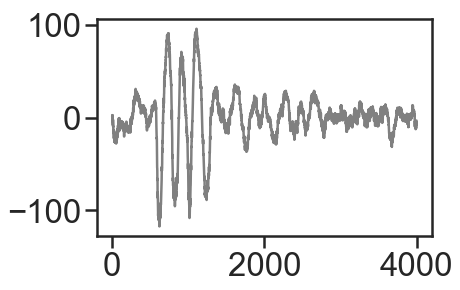

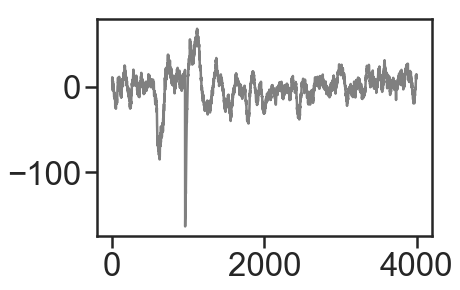

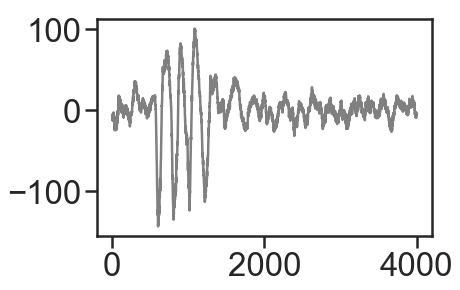

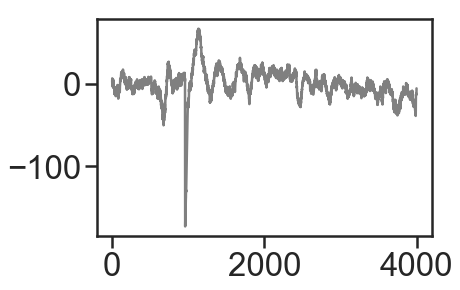

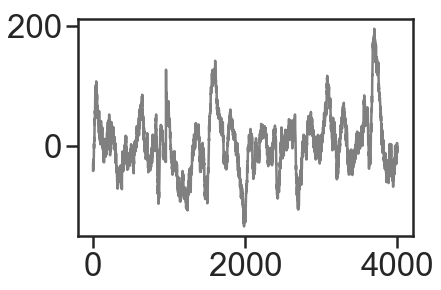

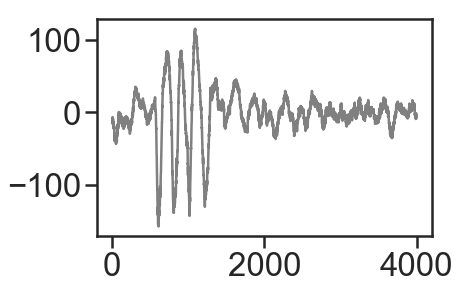

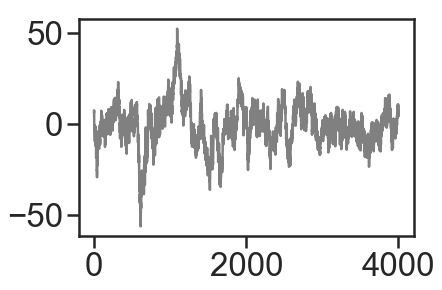

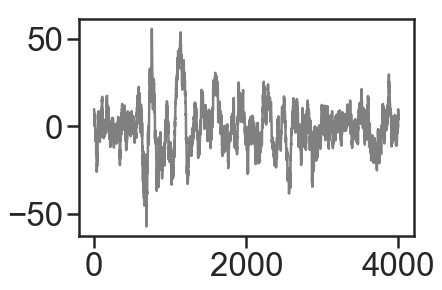

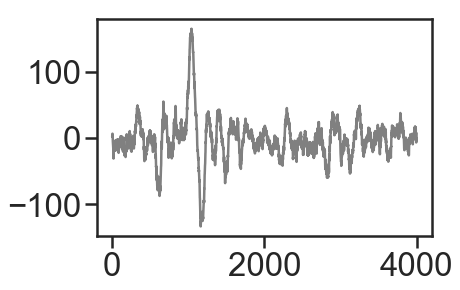

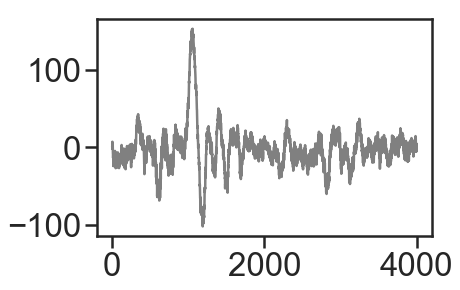

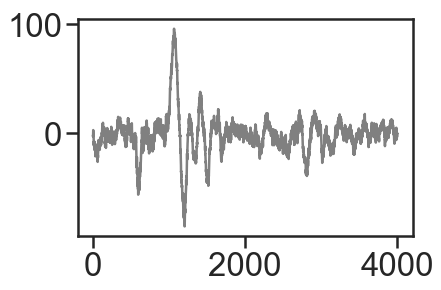

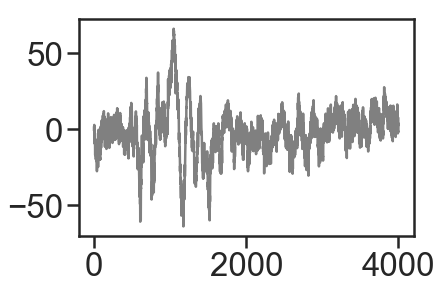

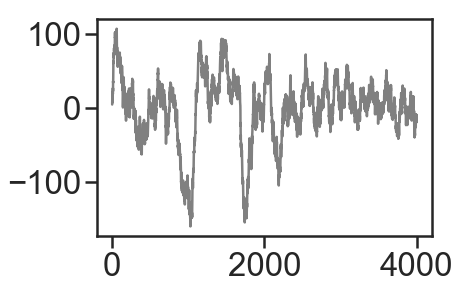

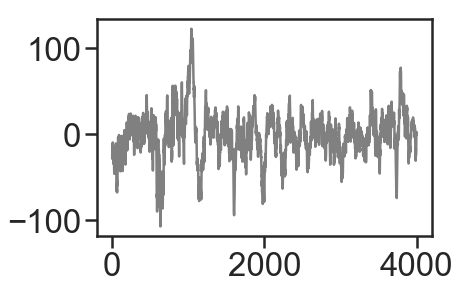

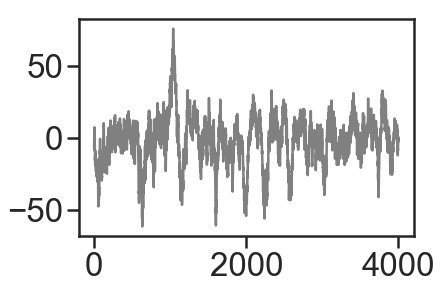

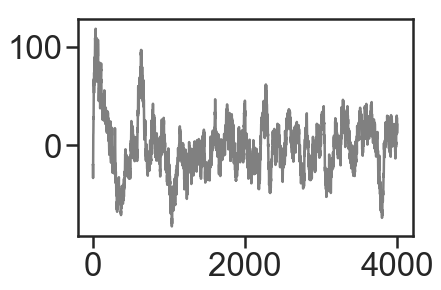

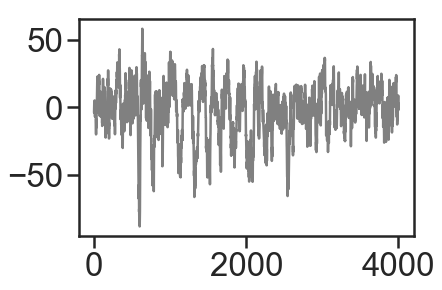

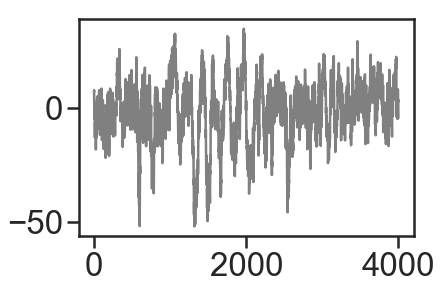

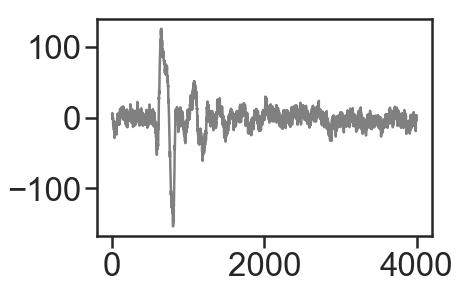

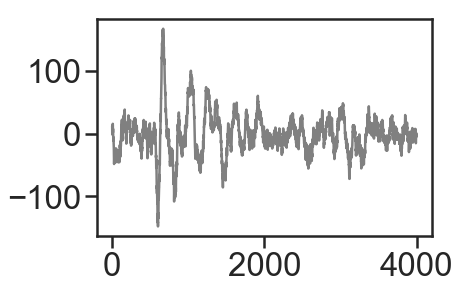

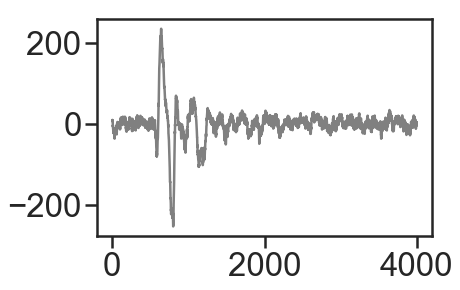

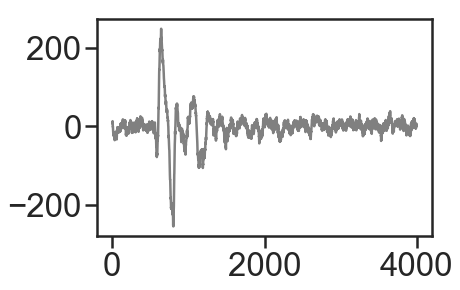

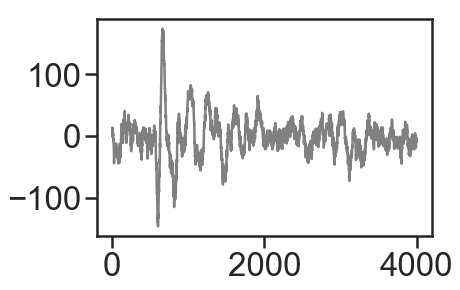

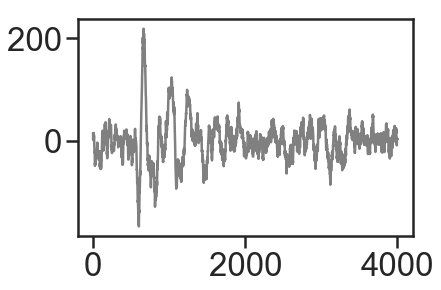

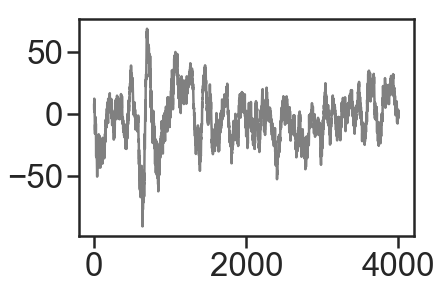

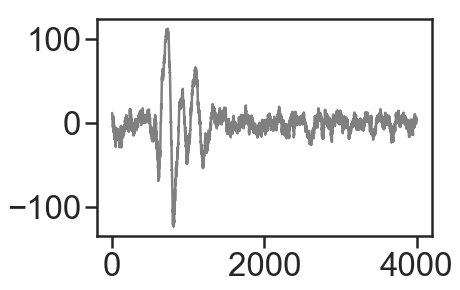

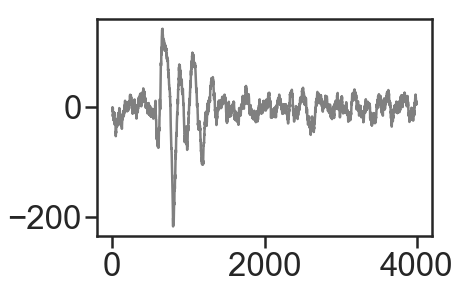

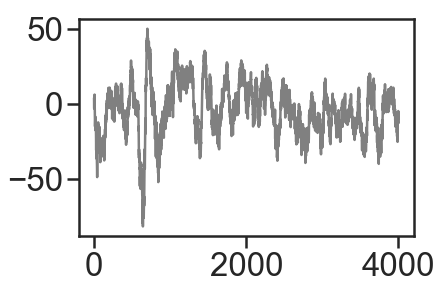

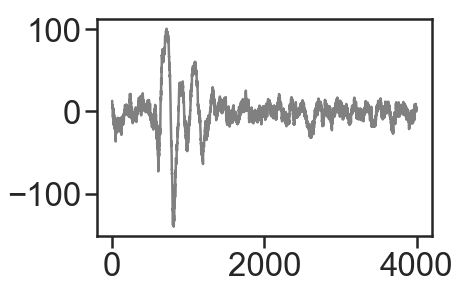

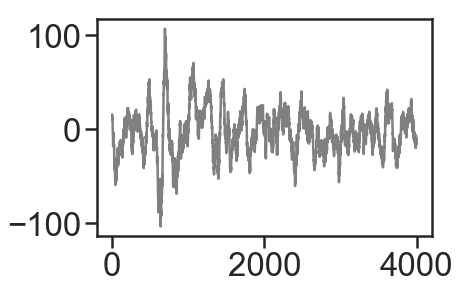

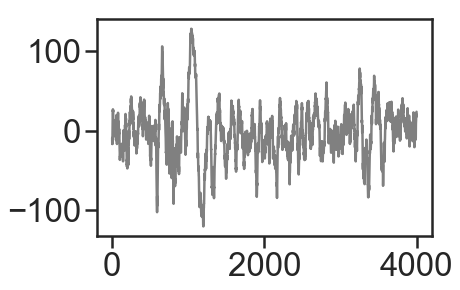

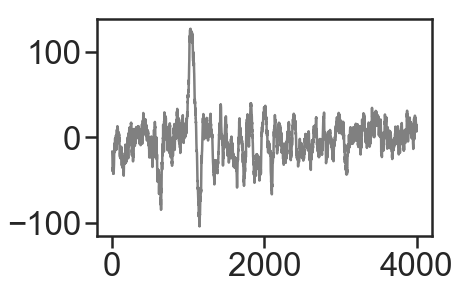

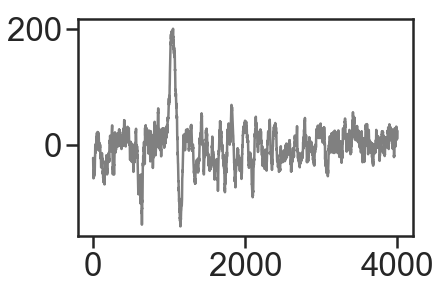

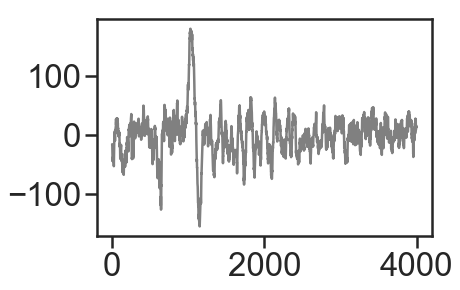

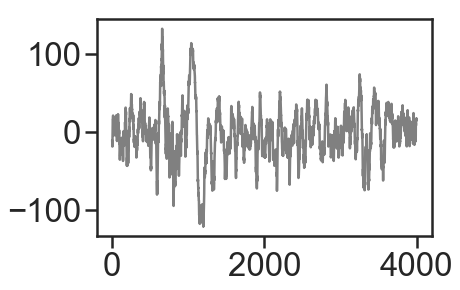

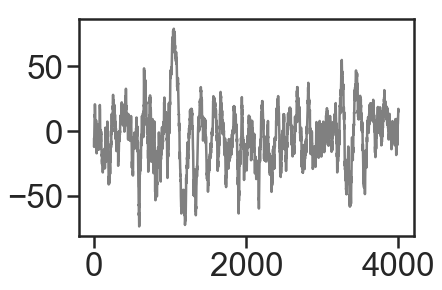

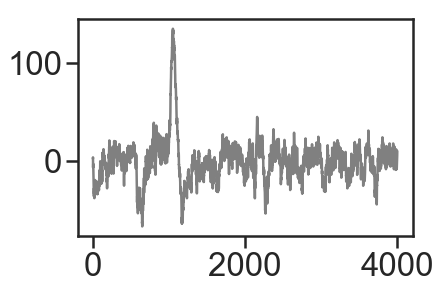

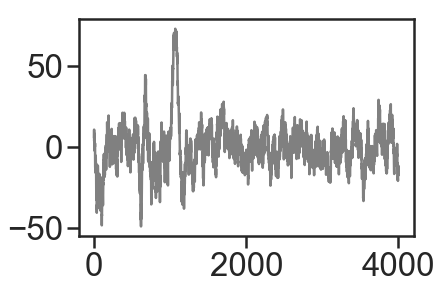

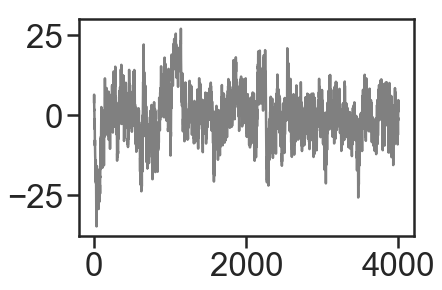

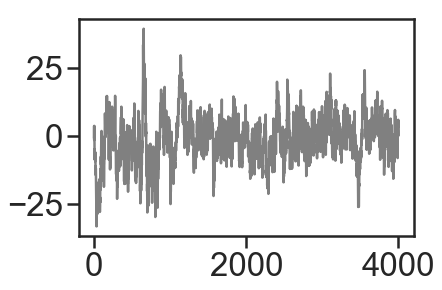

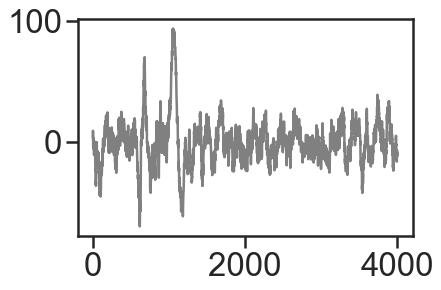

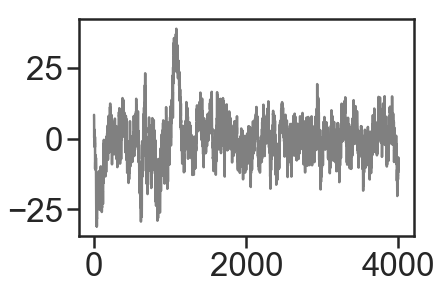

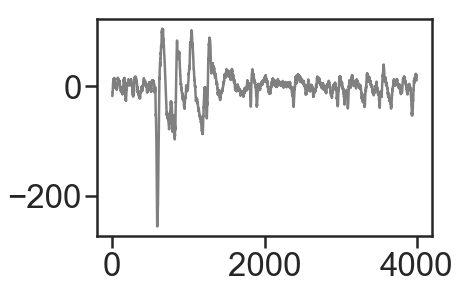

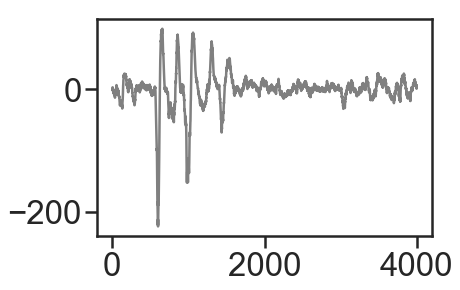

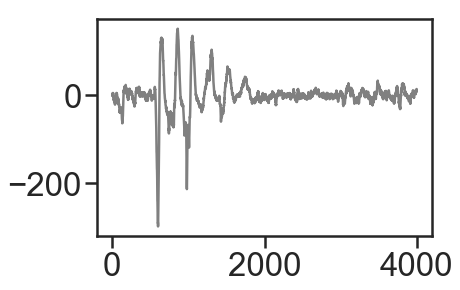

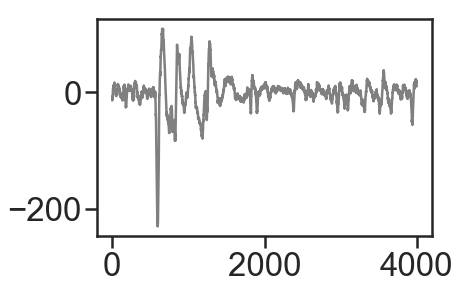

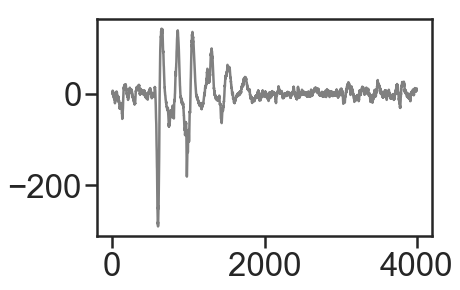

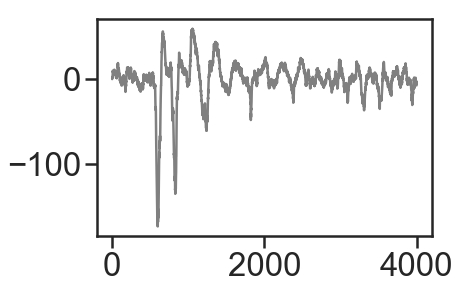

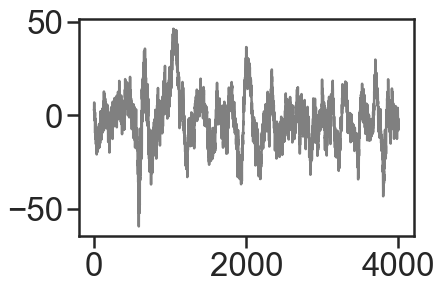

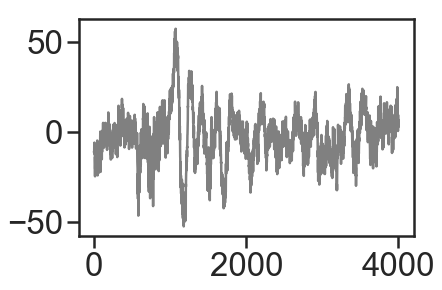

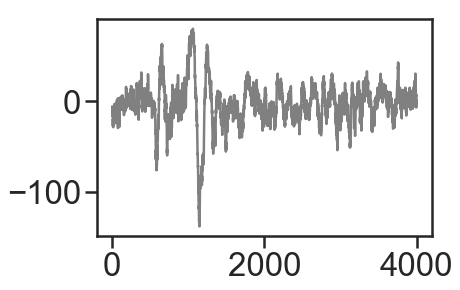

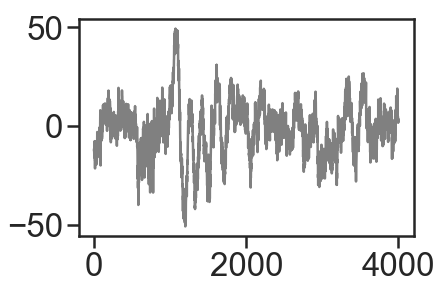

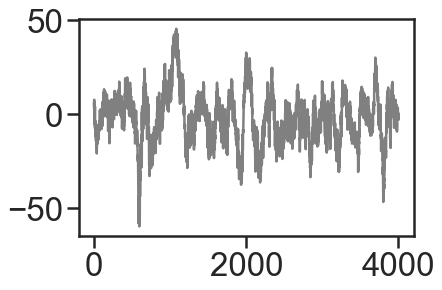

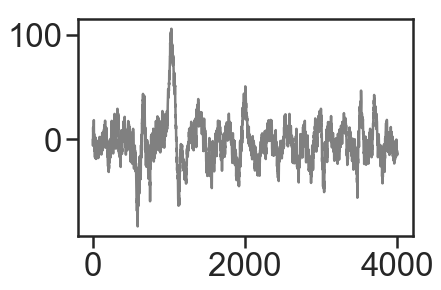

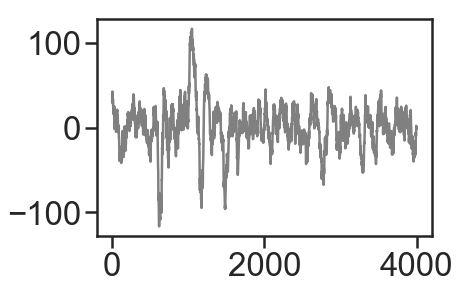

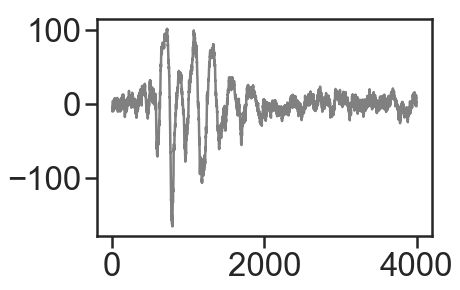

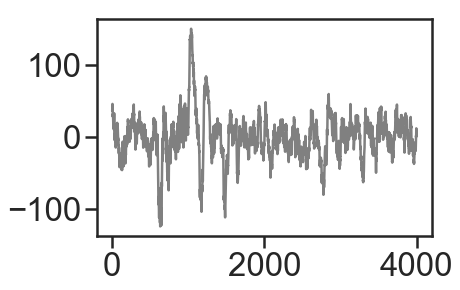

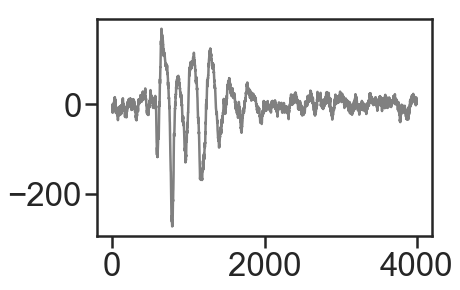

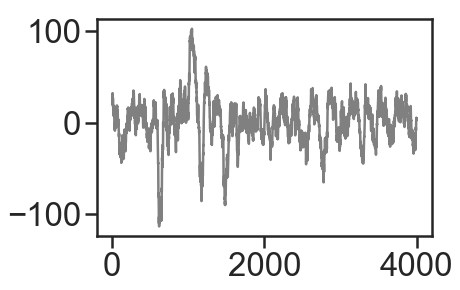

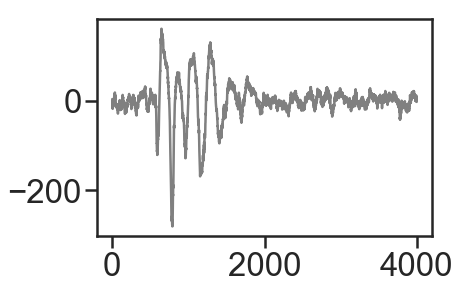

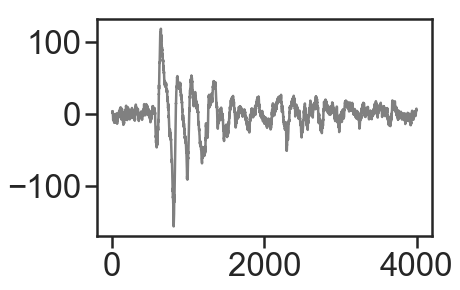

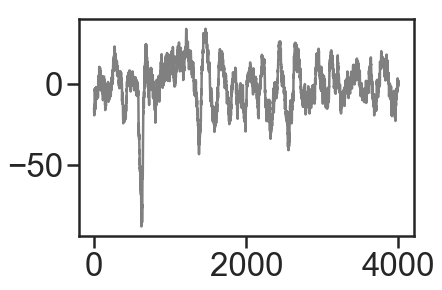

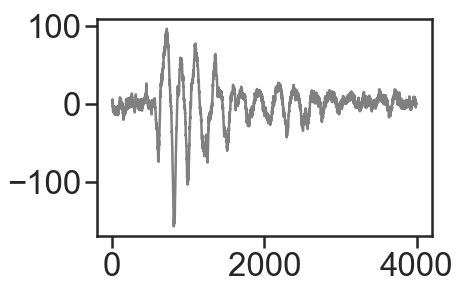

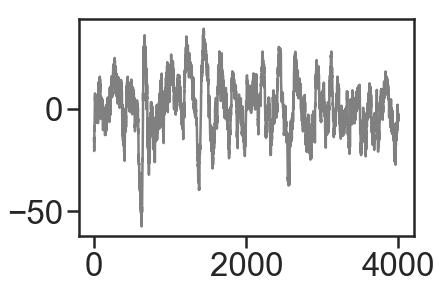

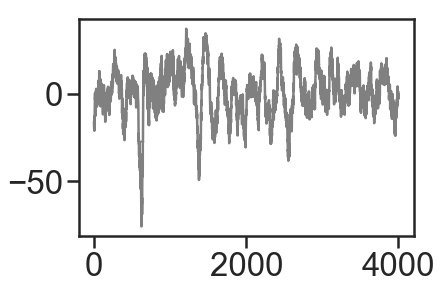

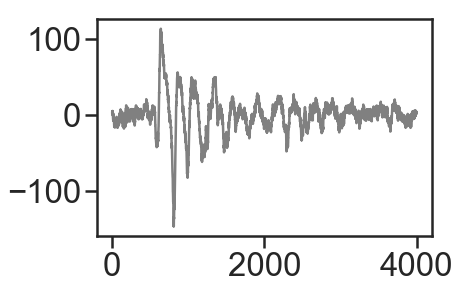

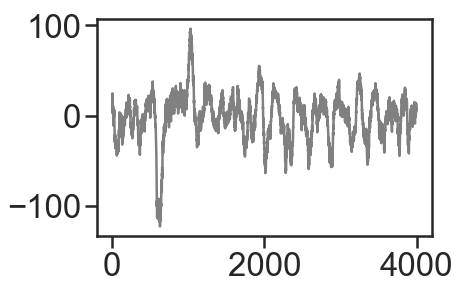

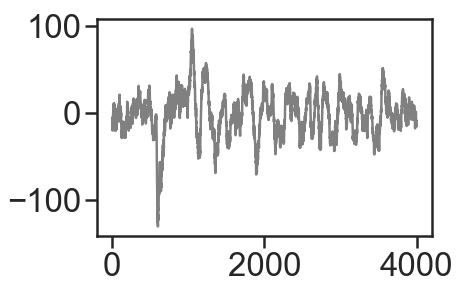

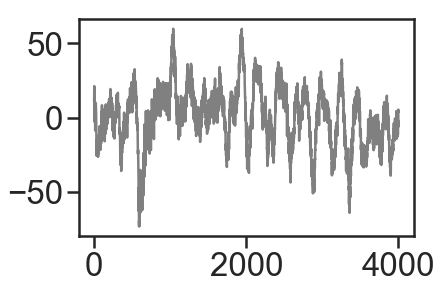

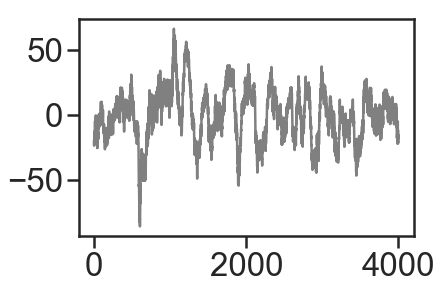

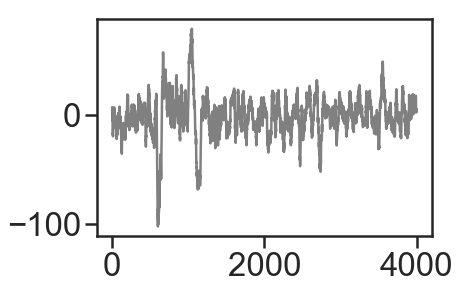

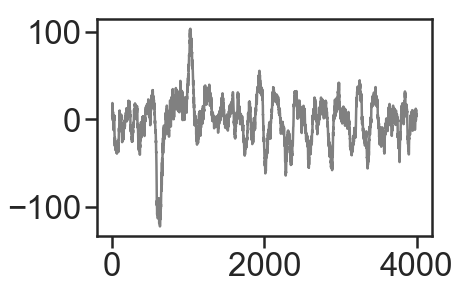

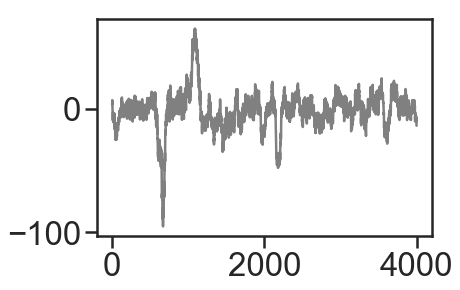

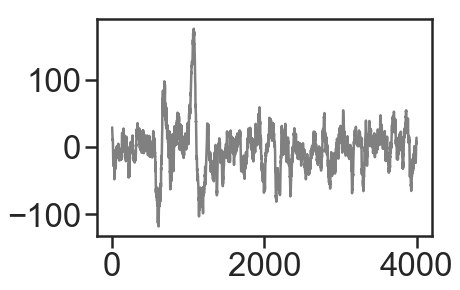

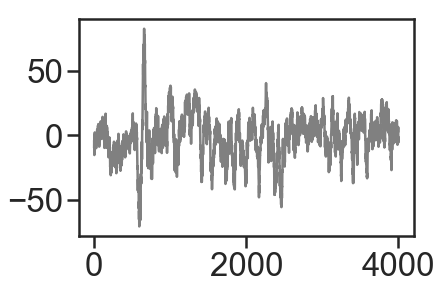

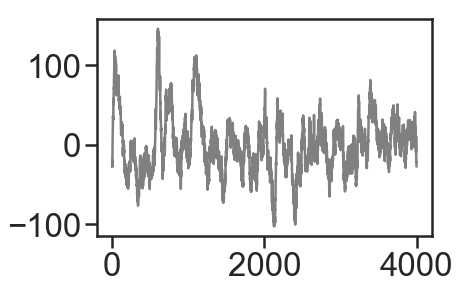

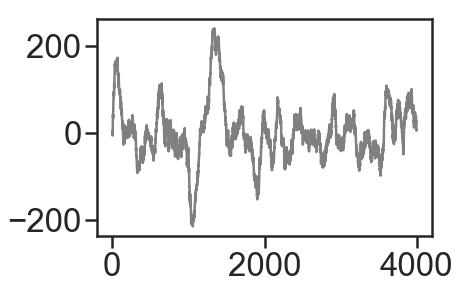

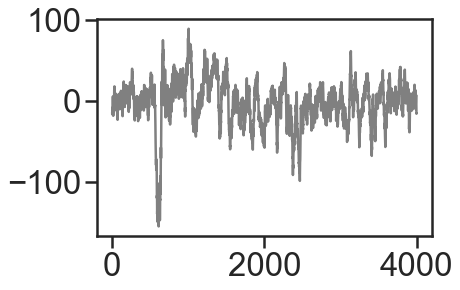

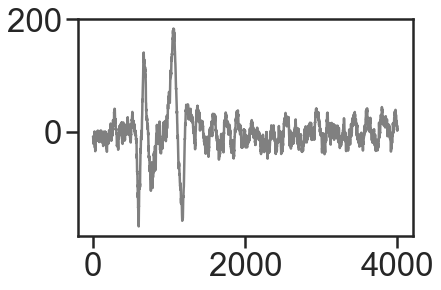

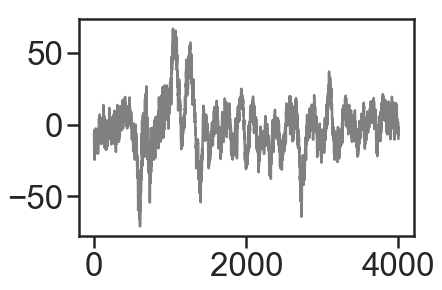

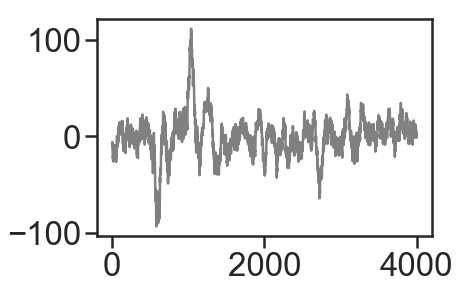

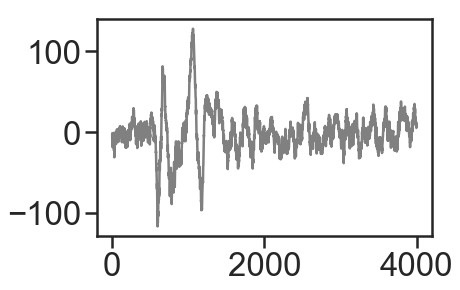

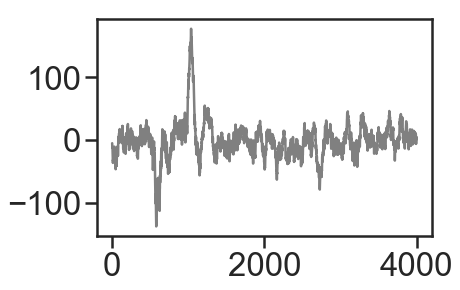

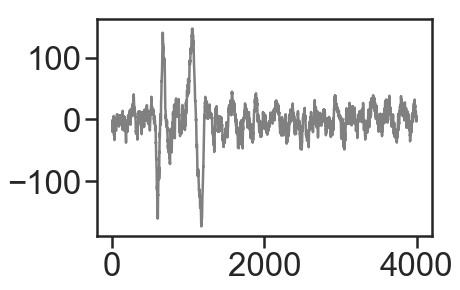

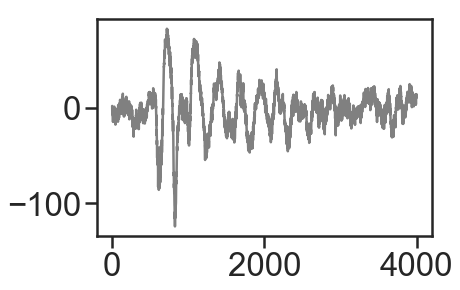

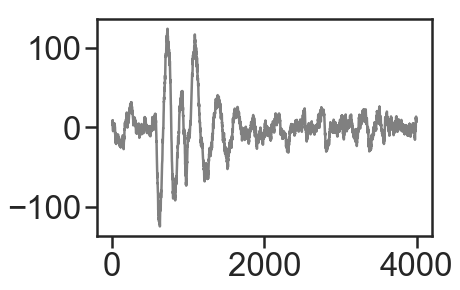

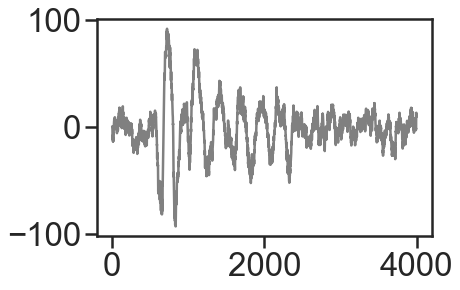

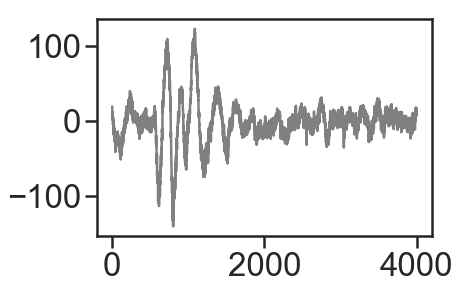

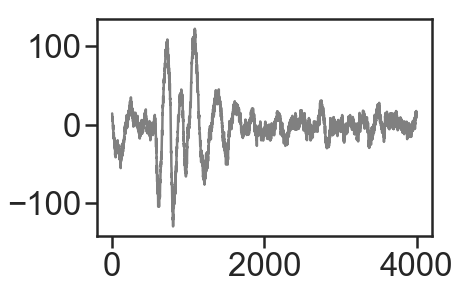

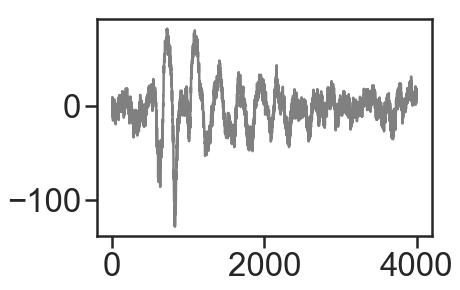

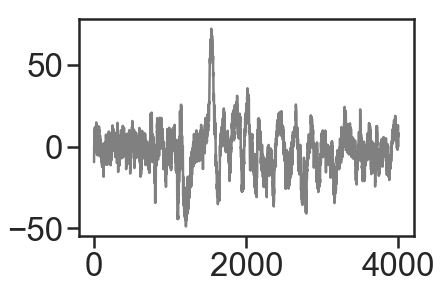

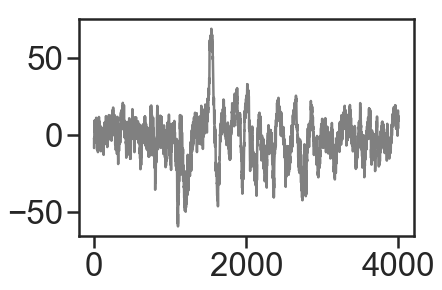

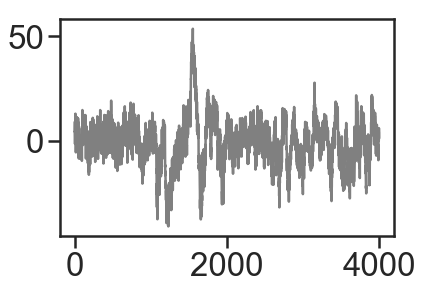

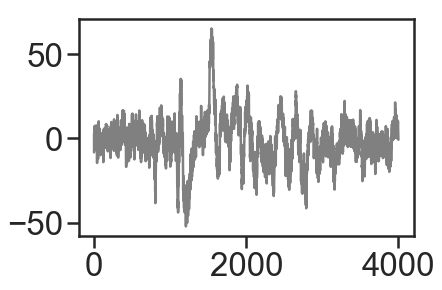

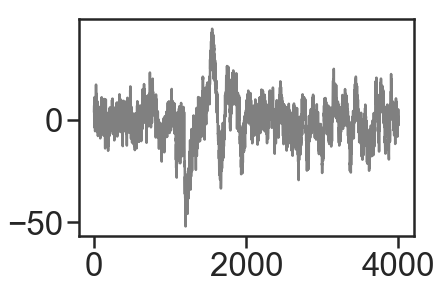

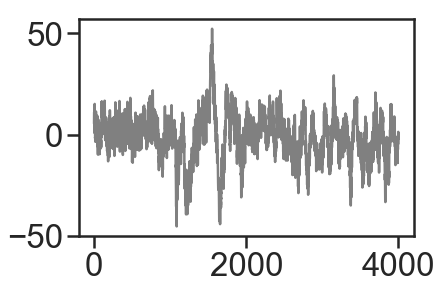

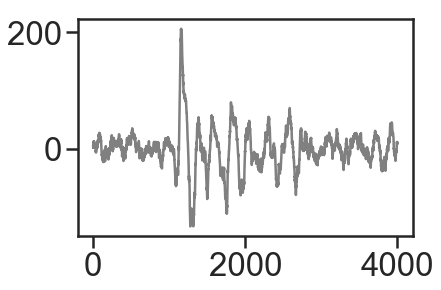

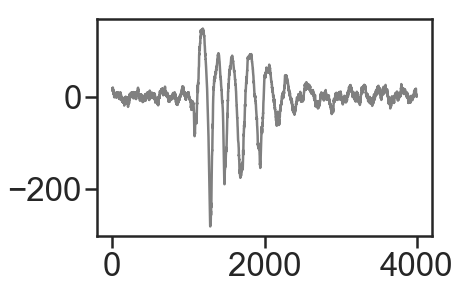

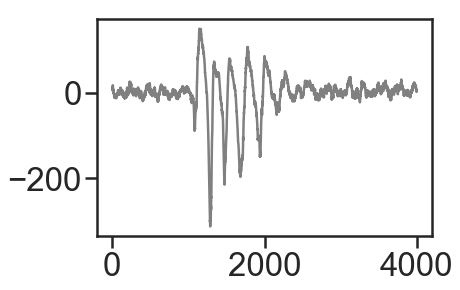

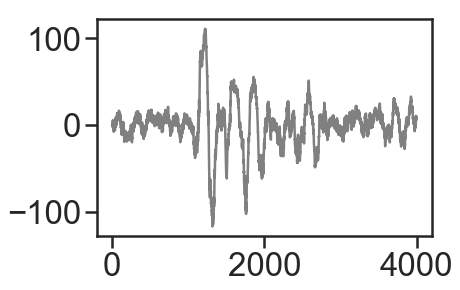

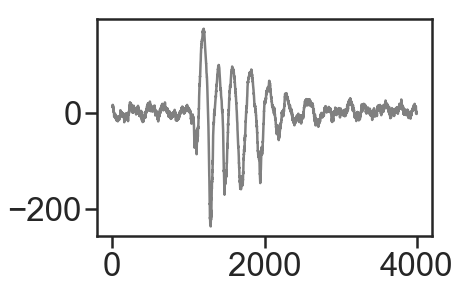

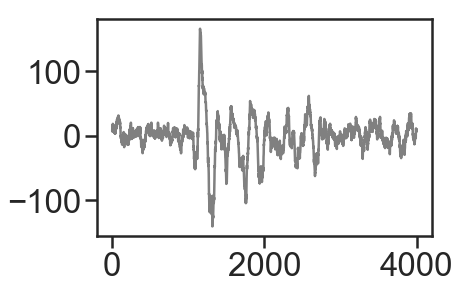

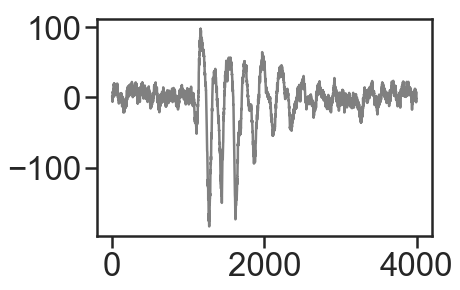

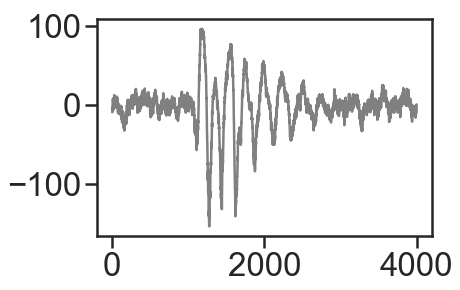

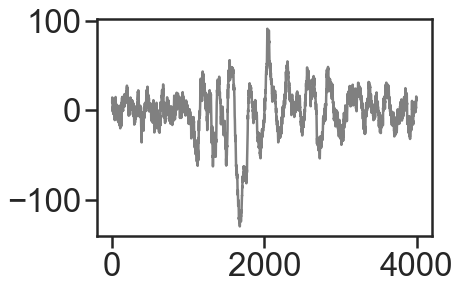

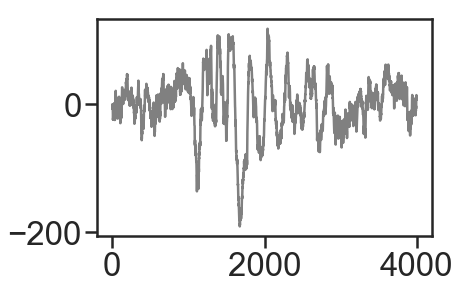

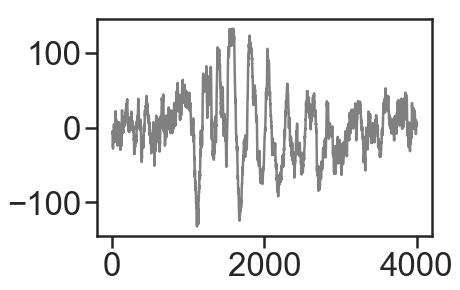

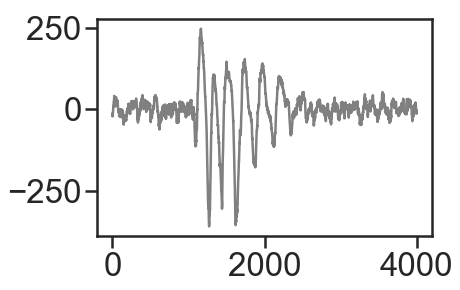

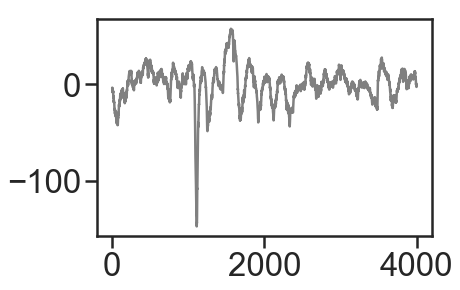

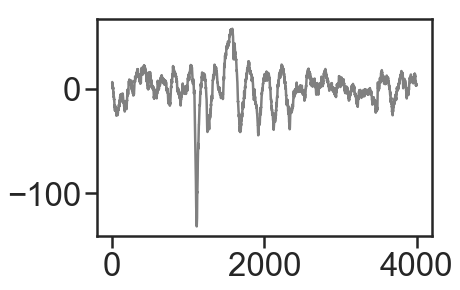

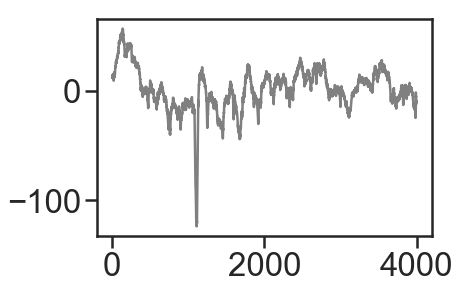

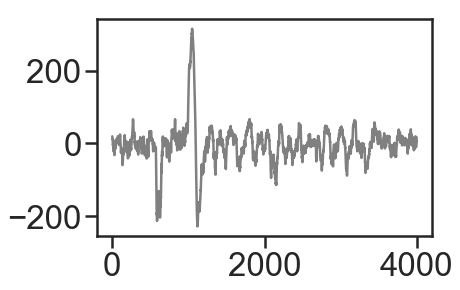

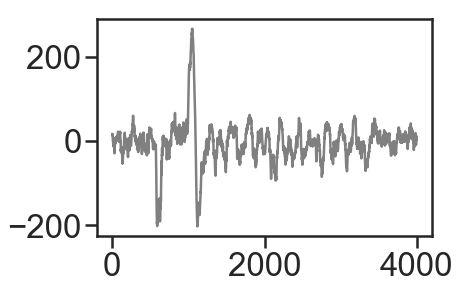

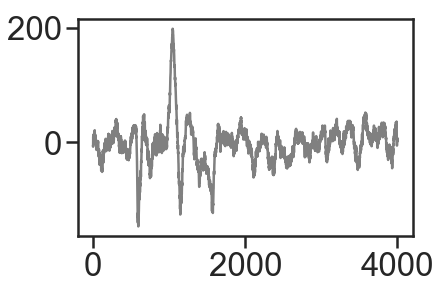

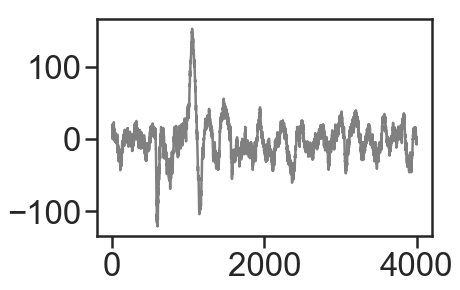

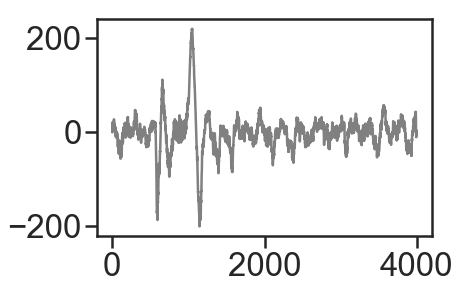

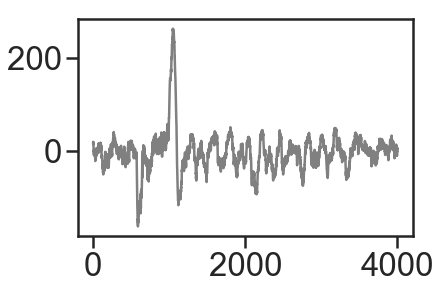

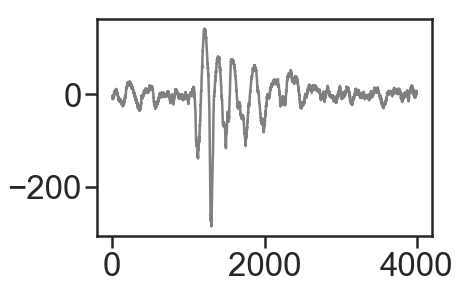

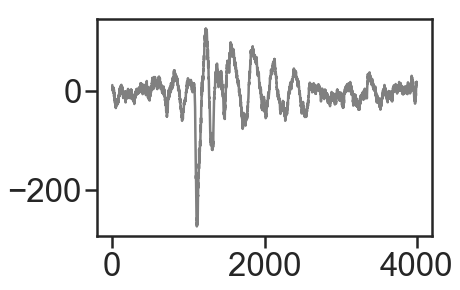

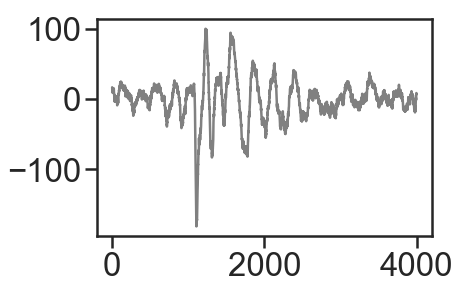

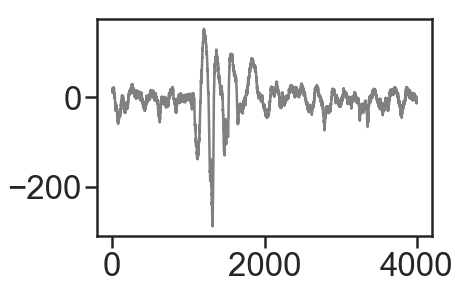

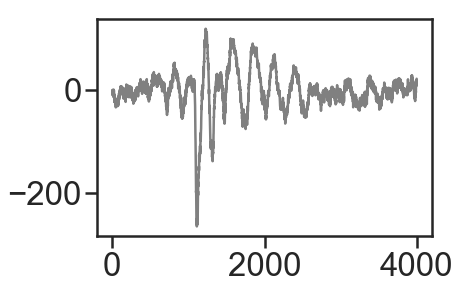

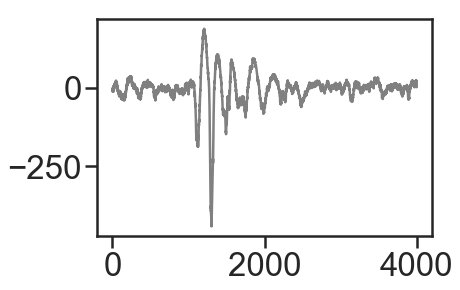

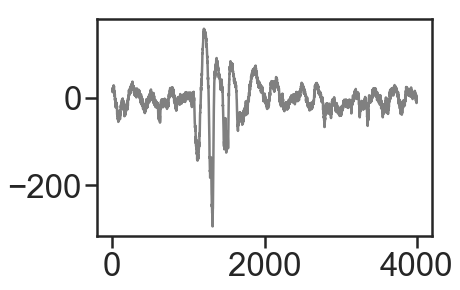

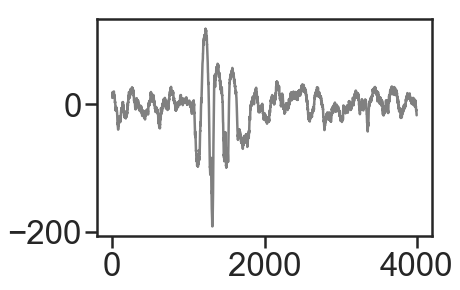

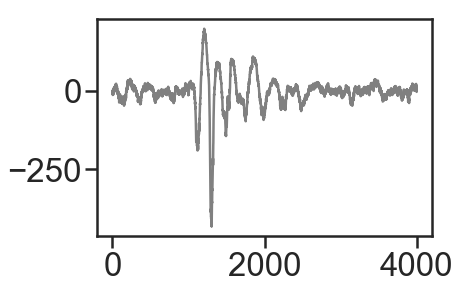

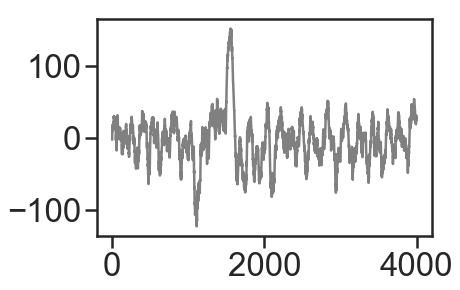

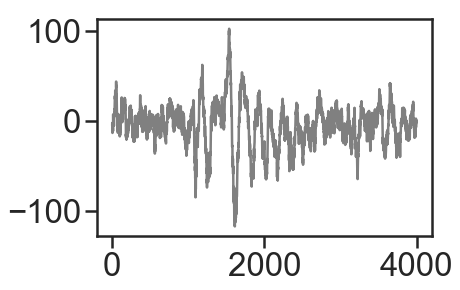

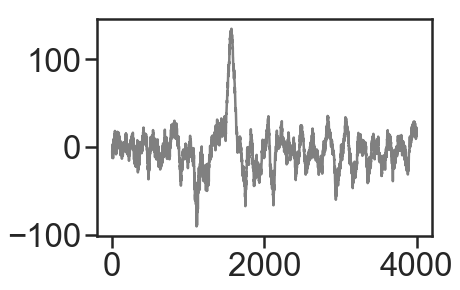

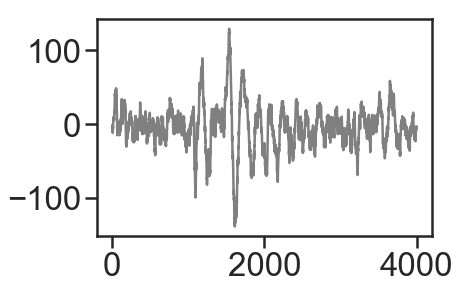

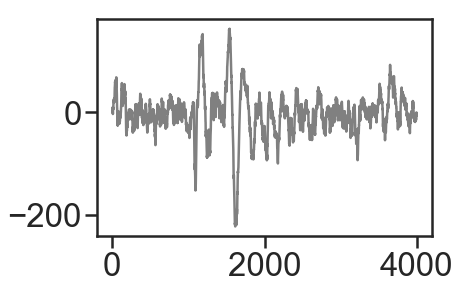

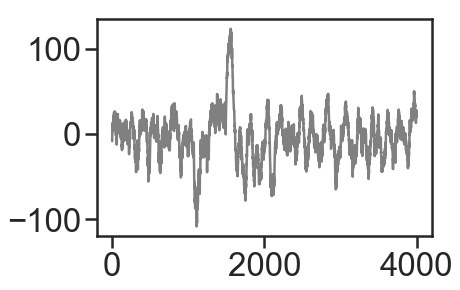

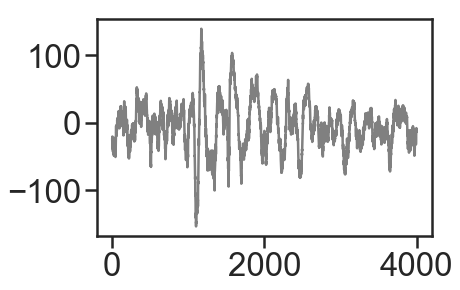

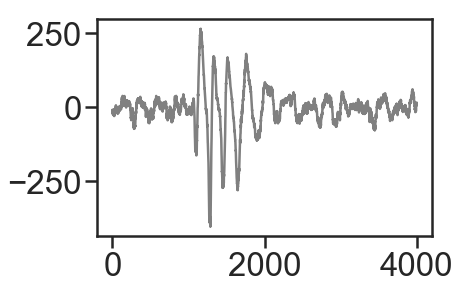

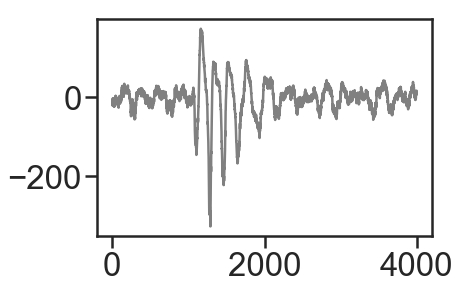

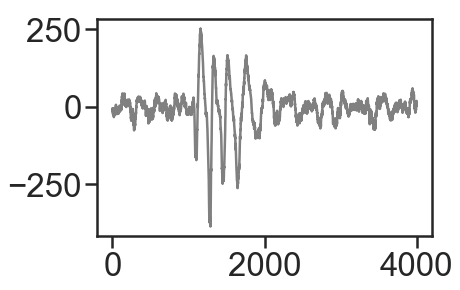

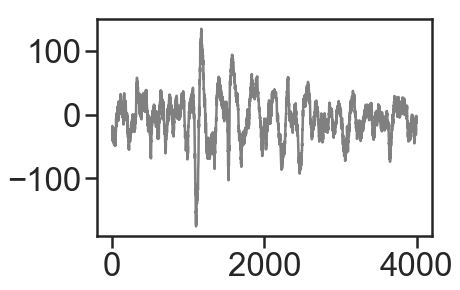

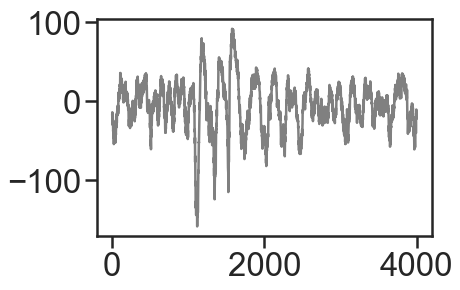

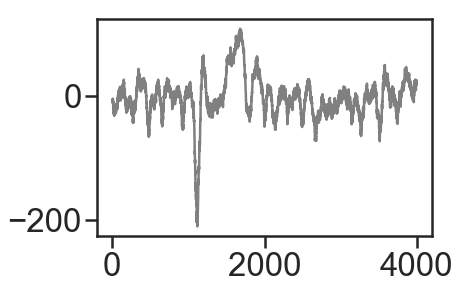

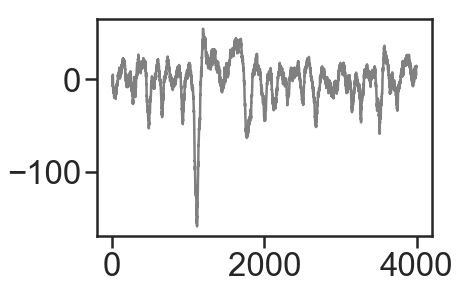

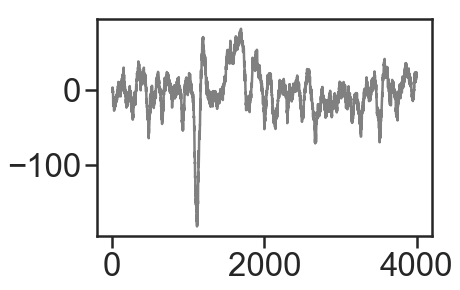

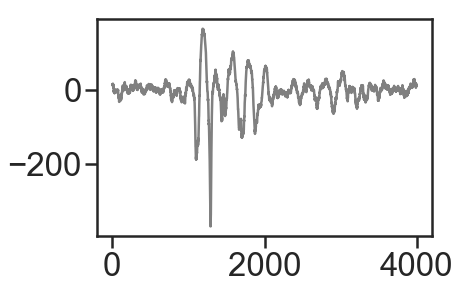

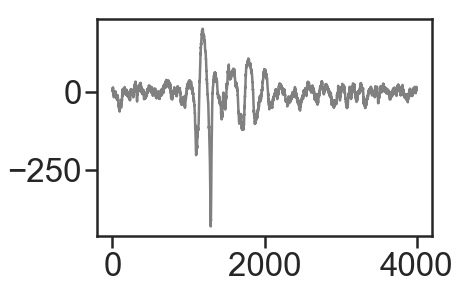

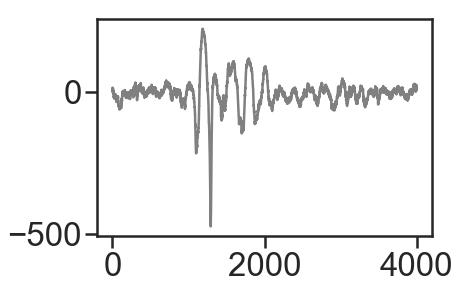

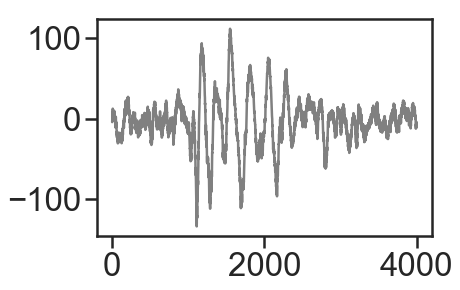

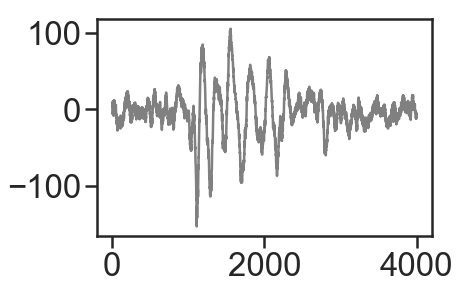

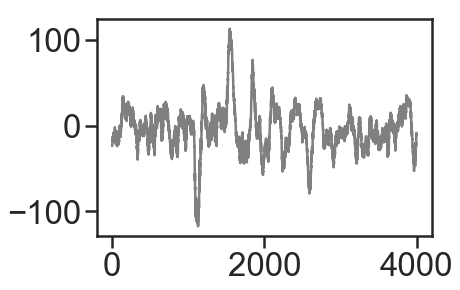

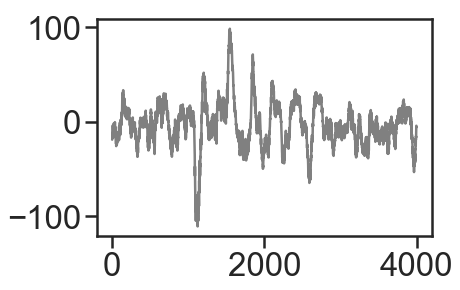

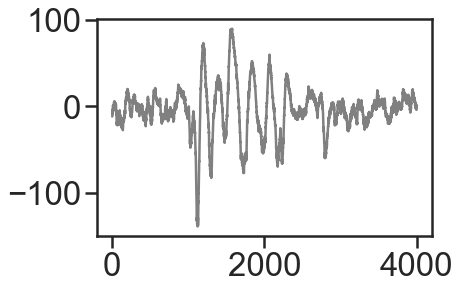

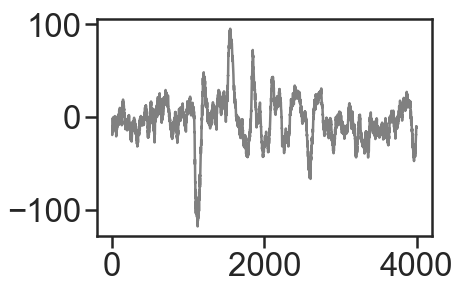

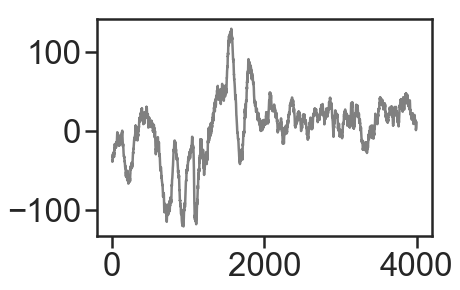

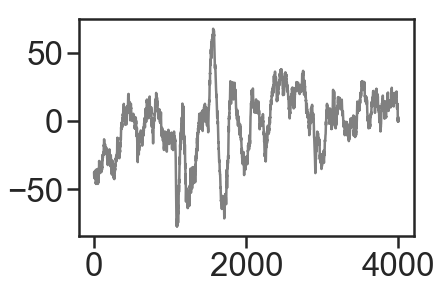

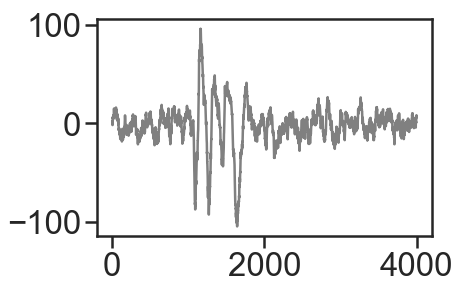

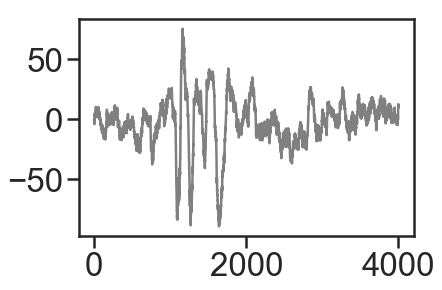

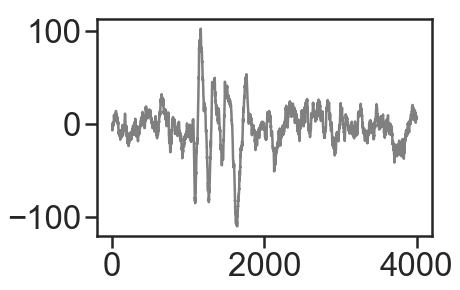

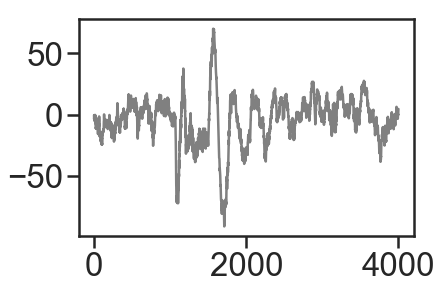

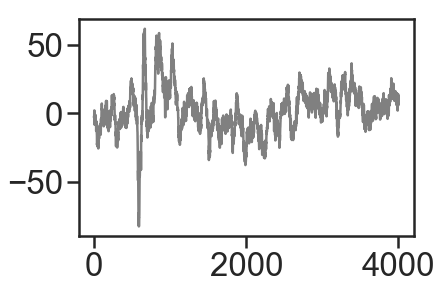

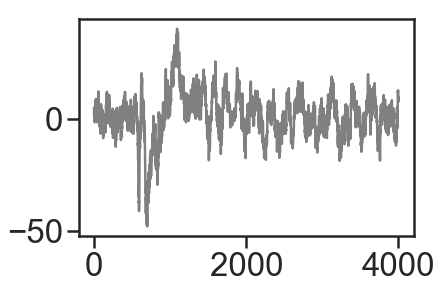

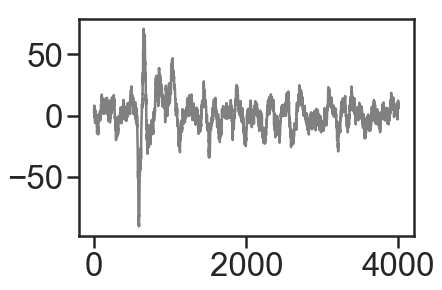

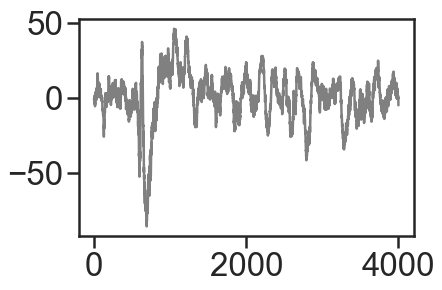

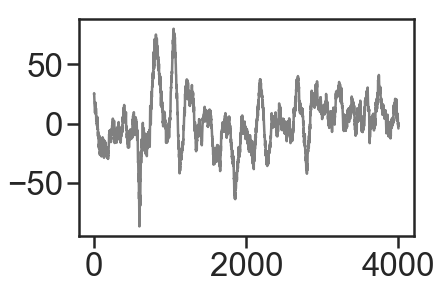

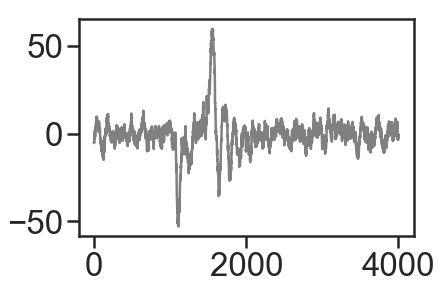

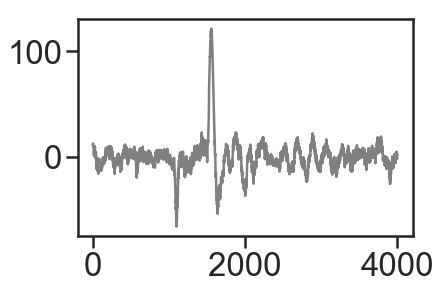

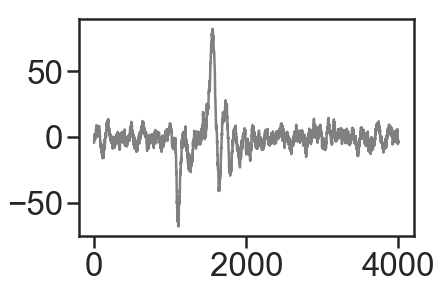

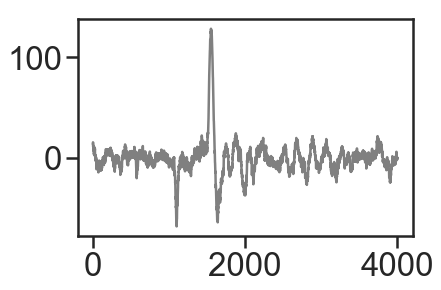

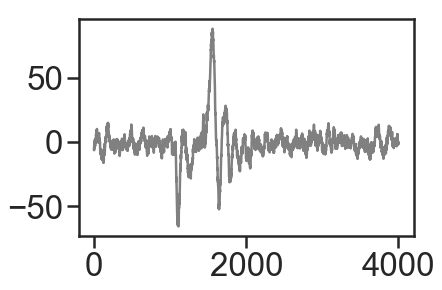

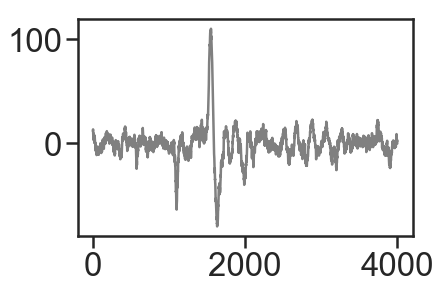

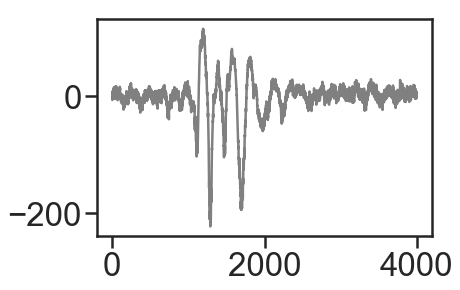

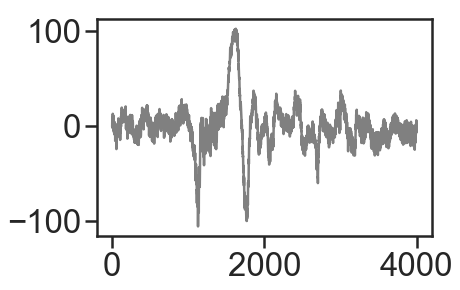

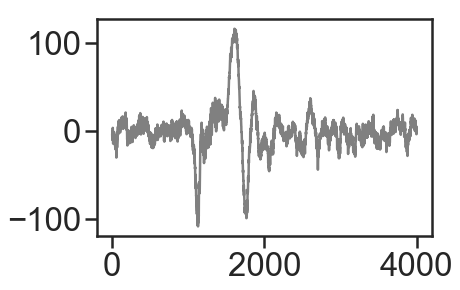

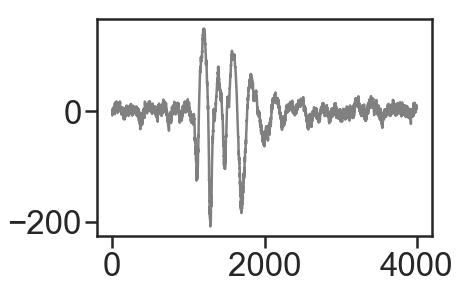

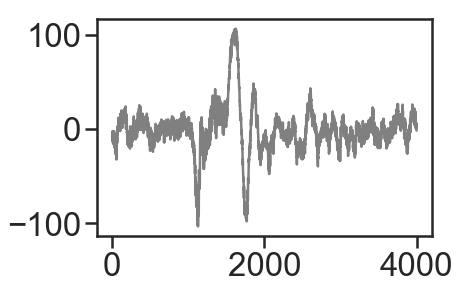

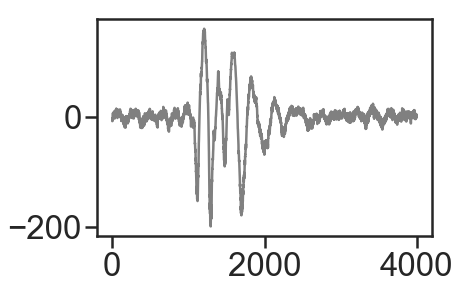

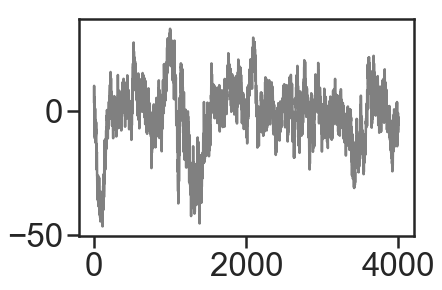

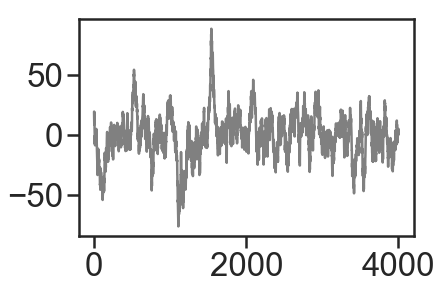

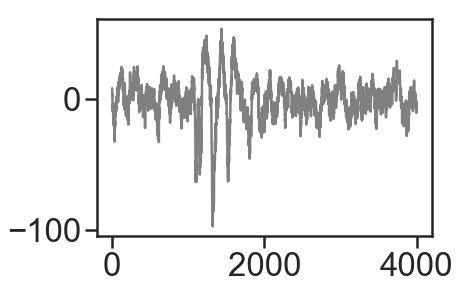

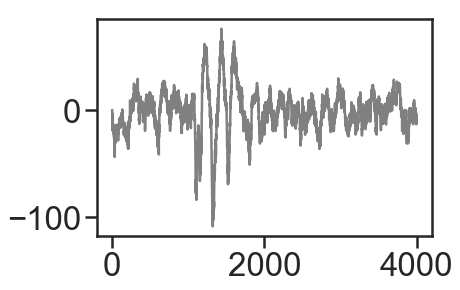

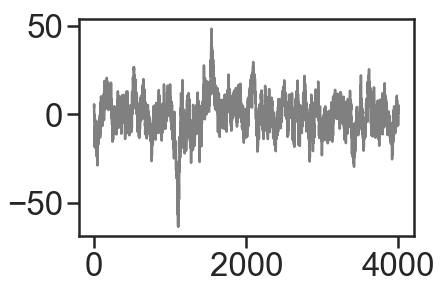

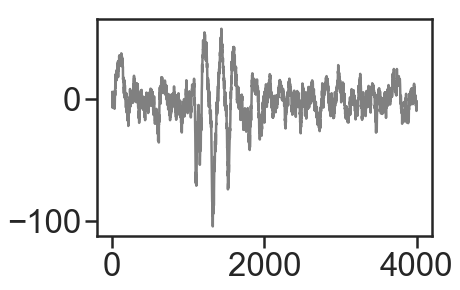

In [96]:
for fn in df_serta.fname.unique():
    plt.plot(df_serta[df_serta.fname == fn].lfp)
    plt.show()

In [39]:
df_sert_l4.to_pickle('sert_ko_stim1_training_l4-lfp,pkl')

In [5]:
novel_oddball = np.array([3, 3, 3, 3, 3, 3, 3, 3, 3, 9, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 
3, 9, 3, 3, 3, 3, 3, 9, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 9, 3, 3, 3, 3, 3, 
3, 3, 3, 3, 3, 9, 3, 3, 3, 9, 3, 3, 3, 3, 9, 3, 3, 3, 3, 3, 9, 3, 3, 3, 3, 3, 3, 
3, 3, 3, 3, 3, 3, 3, 9, 3, 3, 3, 9, 3, 3, 3, 3, 9, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 
3, 9, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 9, 3, 3, 3, 3, 3, 9, 3, 3, 
3, 3, 9, 3, 3, 3, 3, 9, 3, 3, 9, 3, 3, 9, 3, 3, 3, 3, 3, 9, 3, 3, 3, 3, 3, 3, 3, 
3, 9, 3, 3, 3, 3, 3, 9, 3, 3, 9, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 9, 3, 3, 3, 
3, 3, 3, 3, 9, 3, 3, 3, 3, 3, 3, 9, 3, 3, 3])

standard_control = np.array([4, 5, 3, 6, 5, 7, 0, 3, 7, 6, 7, 1, 2, 6, 7, 0, 5, 0, 7, 0, 7, 3, 2, 1, 7, 0, 6, 1, 3, 1, 4, 6, 6, 5, 1, 4, 4, 5, 2, 3, 0, 5, 2, 3, 4, 2, 6, 5, 6, 6, 3, 7, 0, 1, 4, 6, 4, 0, 6, 6, 7, 4, 3, 6, 1, 1, 5, 4, 0, 4, 0, 2, 6, 2, 6, 7, 7, 7, 3, 0, 1, 7, 6, 1, 3, 2, 3, 5, 7, 0, 1, 5, 2, 3, 4, 2, 4, 6, 0, 4, 3, 2, 4, 1, 2, 0, 5, 1, 5, 3, 4, 6, 3, 5, 2, 2, 7, 1, 6, 0, 0, 5, 4, 0, 1, 5, 0, 3, 7, 5, 7, 4, 6, 2, 0, 0, 1, 1, 0, 5, 3, 2, 4, 7, 0, 7, 5, 2, 7, 1, 2, 7, 3, 0, 2, 3, 6, 2, 7, 3, 5, 3, 4, 5, 3, 7, 4, 2, 6, 6, 2, 1, 3, 1, 4, 5, 0, 2, 2, 6, 1, 4, 5, 1, 6, 3, 0, 5, 3, 2, 5, 4, 1, 7, 4, 4, 1, 5, 7, 1])

sf_tuning = np.array([2, 0, 0, 4, 3, 3, 0, 4, 4, 3, 2, 5, 3, 2, 0, 4, 1, 0, 5, 2, 0, 
1, 0, 1, 3, 5, 2, 5, 1, 2, 0, 5, 2, 3, 5, 1, 0, 4, 3, 2, 5, 5, 3, 5, 
2, 0, 3, 3, 0, 3, 4, 5, 4, 1, 4, 0, 1, 5, 4, 1, 5, 3, 3, 5, 3, 3, 2, 
3, 2, 1, 1, 5, 1, 4, 1, 2, 3, 2, 4, 2, 1, 0, 5, 5, 2, 2, 4, 1, 4, 1, 
3, 1, 0, 4, 4, 4, 4, 0, 5, 4, 4, 0, 3, 5, 5, 2, 1, 3, 4, 1, 5, 0, 2, 
2, 0, 0, 0, 1, 2, 1])

loc_omission = np.array([3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 
0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 
3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 
3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 
3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 
3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 
3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 
3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0])

dir_seq = np.array([10, 7, 3, 2, 4, 8, 9, 5, 7, 3, 4, 8, 3, 2, 1, 8, 0, 4, 9, 11, 
10, 9, 1, 11, 4, 0, 7, 1, 2, 8, 2, 9, 11, 9, 6, 5, 10, 4, 9, 0, 7, 11, 9, 
5, 9, 10, 11, 6, 8, 9, 5, 4, 2, 8, 11, 2, 10, 3, 5, 1, 7, 0, 4, 9, 1, 5, 
11, 3, 5, 10, 1, 2, 9, 6, 2, 2, 11, 5, 10, 7, 3, 7, 4, 6, 8, 4, 1, 8, 0, 
11, 0, 6, 2, 11, 1, 10, 3, 8, 3, 1, 2, 10, 5, 3, 11, 1, 7, 3, 4, 7, 8, 4, 6, 
7, 11, 7, 0, 8, 6, 10, 4, 5, 7, 2, 10, 3, 5, 9, 8, 6, 3, 2, 0, 11, 0, 6, 10, 
0, 7, 4, 5, 0, 10, 6, 8, 10, 3, 11, 9, 0, 5, 1, 3, 7, 0, 6, 9, 1, 6, 10, 5, 
6, 11, 7, 0, 5, 1, 4, 1, 6, 8, 2, 9, 2, 8, 3, 0, 4, 6, 1])

In [687]:
# groups = {'ET#304': 1, 'ET#271': 1, 'ET#309': 2, 'ET#270': 2, 'ET#313': 1, 'ET#307': 2}
# groups = {'ET#970': 'b', 'ET#971': 'b', 'ET#972': 'b', 'ET#973': 'a', 'ET#974': 'a', 'ET#975': 'a', 'ET#758': 'a',
#          'ET#759': 'a'}
groups = {'479': 'wt', '480': 'fx', '481':'fx', '482': 'fx', '483': 'wt', '484': 'wt', '485':'wt', '486':'fx', 
          '013': 'wt', '014': 'fx', '016': 'fx', '017': 'wt', '018': 'fx', '019': 'wt', '020': 'wt', '022': 'fx',
         '023': 'wt', '024': 'fx', '025': 'fx', '026': 'fx', '027': 'fx', '028': 'fx', '029': 'wt', '030': 'fx', '031': 'fx', '032': 'fx', 
          '033': 'fx' , '034': 'fx', '035': 'wt', 'W00': 'wt', 'W01': 'wt',
 'W02': 'wt', 'W03': 'wt', 'W04': 'wt', 'W05':'wt'}


## Generate pkl for SF-vmmn data

In [172]:
ls = []

for fname in matches[:]:
    stim_type = ''
    et = fname.split('\\')[-1].split()[2][3:]
    side = 'left-1'
    paradigm = fname.split('\\')[-1].split()[-1].split('_')[2]
    
    if 'bad' in fname or 'sf' not in fname:
        continue
    print fname

    if 'nov' in paradigm:
        trial_type = novel_oddball
        idx_odd = np.where(trial_type==9)[0]
        pre_odd = idx_odd-1
        print 'novel oddball'
    elif 'omis' in paradigm:
        trial_type = loc_omission
        idx_odd = np.where(trial_type==0)[0]
        pre_odd = idx_odd-1
        print 'loc_omission'
    elif 'control' in paradigm:
        trial_type = standard_control
        print 'std control'
    elif 'tuning' in paradigm:
        trial_type = sf_tuning
        print 'tuning'
    else:
        print 'no paradigm'
        continue
        
    try:
        tmp =  pd.read_hdf(fname, key = 'raw') 
#         trial_length = pd.read_hdf(fname, key = 'trial_duration') 
    except:
        continue
    trial_length = 1000
    trials =  int(tmp.shape[1]/trial_length)
    
    times = np.linspace(0, trial_length/1e3, trial_length)
    df3_array=np.reshape(tmp.values,(np.shape(tmp)[0],trials, -1))
    df3_avg=np.mean(df3_array,1)
    df3_avg = pd.DataFrame(df3_avg).T        
    df3_avg['times'] = times
    negativity_ch_idx=df3_avg[(df3_avg['times']>=0.35) & (df3_avg['times']< 0.5)].ix[:,8:16].min().idxmin()
#     negativity_ch_idx = negativity_ch_idx - 4
    print negativity_ch_idx

    # plotting the spectra and FFR for the maximum negativity channel, the first trial
    
    ddf = tmp.values[negativity_ch_idx,:]
    
    ddf2=np.reshape(ddf,(trials, -1))
    print ddf2.shape
    ddf2 = pd.DataFrame(ddf2)
    
    if 'control' in paradigm or 'tuning' in paradigm:
        for j in np.unique(trial_type):
            stim_type = 'ctr'
            lfp = ddf2.iloc[np.where( trial_type == j)[0]].mean()
            tmp_df = pd.DataFrame({'et': et, 'lfp':lfp, 'paradigm': paradigm,  'stim1': stim_type + str(j), 
                        'layer': 'l2/3',
                           'side':side,    'fname':fname, 'times':times, 'ch_idx': negativity_ch_idx })
            ls.append(tmp_df)
    else:
        for j in np.unique(trial_type):
            if j == 3:
                stim_type = 'std'
                lfp = ddf2.iloc[pre_odd].mean()
            elif j == 9 or j == 0:
                stim_type = 'dev'
                lfp = ddf2.iloc[idx_odd].mean()
            else:
                continue
    #         if j==3 or j ==9:
    #             plt.plot(lfp)
    #             plt.show()
            tmp_df = pd.DataFrame({'et': et, 'lfp':lfp, 'paradigm': paradigm,  'stim1': stim_type + str(j), 
                                    'layer': 'l2/3',
                   'side':side,  'fname':fname, 'times':times, 'ch_idx': negativity_ch_idx })
            ls.append(tmp_df)
    
mmn_df4 = pd.concat(ls)
    

U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-odd\wheel sam set 12-18-18\W05\_2018.12.19 CC# ET#W05 Group pre t_004_sf-nov-odd_2018-12-19_18-48-51_100_CH1_0.h5
novel oddball


C:\Users\Chub_lab\Anaconda2\lib\site-packages\ipykernel_launcher.py:46: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


19
(200L, 1000L)
U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-odd\wheel sam set 12-18-18\W05\_2018.12.19 CC# ET#W05 Group pre t_004_sf-nov-odd_2018-12-19_18-48-51_100_CH1_2.h5
novel oddball
19
(200L, 1000L)
U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-odd\wheel sam set 12-18-18\W05\_2018.12.19 CC# ET#W05 Group pre t_003_sf-tuning_2018-12-19_18-37-45_100_CH1_1.h5
tuning
21
(120L, 1000L)
U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-odd\wheel sam set 12-18-18\W05\_2018.12.19 CC# ET#W05 Group pre t_004_sf-nov-odd_2018-12-19_18-48-51_100_CH1_1.h5
novel oddball
21
(200L, 1000L)
U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-odd\wheel sam set 12-18-18\W05\_2018.12.19 CC# ET#W05 Group pre t_003_sf-tuning_2018-12-19_18-37-45_100_CH1_2.h5
tuning
19
(120L, 1000L)
U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-odd\wheel sam set 12-18-18\W05\_2018.12.19 CC# ET#W05 Group pre t_003_sf-tuning_2018-12-19_18-37-45_100_CH1_0.h5
tuning
19
(120L, 1000L)
U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-odd\wh

20
(120L, 1000L)
U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-odd\wheel sam set 12-18-18\W01\_2018.12.19 CC# ET#W01 Group pre t_004_sf-nov-odd_2018-12-19_11-11-22_100_CH1_2.h5
novel oddball
20
(200L, 1000L)
U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-odd\wheel sam set 12-18-18\W01\_2018.12.19 CC# ET#W01 Group pre t_003_sf-tuning_2018-12-19_10-56-14_100_CH1_1.h5
tuning
21
(120L, 1000L)
U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-odd\wheel sam set 12-18-18\W01\_2018.12.19 CC# ET#W01 Group pre t_003_sf-tuning_2018-12-19_10-56-14_100_CH1_0.h5
tuning
20
(120L, 1000L)
U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-odd\wheel sam set 12-18-18\027\_2018.12.19 CC# ET#027 Group pre t_004_sf-nov-odd_2018-12-19_15-04-14_100_CH1_2.h5
novel oddball
20
(200L, 1000L)
U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-odd\wheel sam set 12-18-18\027\_2018.12.19 CC# ET#027 Group pre t_004_sf-nov-odd_2018-12-19_15-04-14_100_CH1_1.h5
novel oddball
21
(200L, 1000L)
U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-no

21
(200L, 1000L)
U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-odd\wheel sam set 12-18-18\W00\_2018.12.19 CC# ET#W00 Group pre t_004_sf-tuning_2018-12-19_09-52-35_100_CH1_1.h5
tuning
21
(120L, 1000L)


In [173]:
mmn_df4['group'] = mmn_df4.et.map(groups)

In [174]:
sorted(mmn_df4.group.unique())

['fx', 'wt']

In [175]:
mmn_df4.head()

ch_idx   et                                              fname layer  \
0      19  W05  U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-...  l2/3   
1      19  W05  U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-...  l2/3   
2      19  W05  U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-...  l2/3   
3      19  W05  U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-...  l2/3   
4      19  W05  U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-...  l2/3   

         lfp    paradigm    side stim1     times group  
0 -29.879212  sf-nov-odd  left-1  std3  0.000000    wt  
1 -29.292189  sf-nov-odd  left-1  std3  0.001001    wt  
2 -30.573633  sf-nov-odd  left-1  std3  0.002002    wt  
3 -30.922423  sf-nov-odd  left-1  std3  0.003003    wt  
4 -26.030399  sf-nov-odd  left-1  std3  0.004004    wt

## pkl file for standard ori vmmn

In [178]:
ls = []

oddball = np.array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 
3, 3, 3, 3, 3, 3,
 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
 3, 3, 3, 3, 3, 3, 3, 3, 3, 9, 3, 3, 3, 3, 3, 3, 9, 3, 3, 3, 3, 3,
 3, 3, 3, 3, 3, 9, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
 3, 3, 9, 3, 3, 3, 3, 3, 3, 9, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
 9, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 9, 3, 3, 3, 3, 3, 9, 3, 3,
 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 9, 3, 3, 3, 3, 9, 3, 3, 3, 3, 3, 3,
 3, 3, 9, 3, 3, 3, 3, 3, 3, 3, 9, 3, 3, 3, 3, 3, 3, 3, 9, 3, 3, 3,
 3, 3, 3, 3, 3, 9, 3, 3, 3, 3, 3, 9, 3, 3, 3, 3, 9, 3, 3, 3, 3, 3,
 3, 3, 3, 3, 9, 3, 3, 3, 3, 3, 3, 3, 3, 3, 9, 3, 3, 3, 3, 3, 3, 3,
 9, 3, 3, 3, 9, 3, 3, 3, 3, 3, 9, 3, 3, 3, 3, 3, 9, 3, 3, 3, 3, 3,
 3, 3, 3, 9, 3, 3, 3, 3, 3, 9, 3, 3, 3, 3, 3, 3, 3, 9, 3, 3, 3, 3,
 3, 3, 9, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 9, 3, 3, 3, 3, 3, 9, 3,
 3, 3, 3, 3, 3, 3, 3, 9, 3, 3, 3, 3, 3, 9])

control = np.array([8, 12, 4, 9, 4, 10, 12, 8, 2, 10, 4, 9, 9, 4, 3, 2, 10, 2, 4, 10, 8, 4, 10, 10, 12, 3, 10, 2, 3, 10, 9, 2, 8, 6, 2, 10, 12, 9, 9, 2, 6, 4, 10, 12, 12, 12, 3, 6, 4, 4, 12, 6, 3, 6, 4, 10, 3, 3, 6, 3, 8, 3, 12, 6, 9, 12, 10, 3, 8, 8, 12, 6, 9, 9, 3, 10, 2, 6, 10, 4, 12, 9, 2, 10, 9, 4, 3, 2, 9, 12, 2, 8, 8, 8, 12, 8, 9, 2, 8, 6, 10, 8, 10, 2, 8, 9, 8, 9, 9, 3, 4, 2, 8, 4, 2, 3, 4, 8, 12, 4, 6, 10, 12, 9, 8, 8, 3, 2, 6, 6, 3, 10, 4, 10, 2, 9, 10, 6, 3, 10, 8, 12, 9, 3, 8, 4, 2, 8, 4, 8, 12, 4, 6, 12, 10, 10, 9, 4, 12, 10, 3, 6, 2, 9, 4, 12, 2, 12, 3, 2, 6, 9, 6, 8, 2, 4, 3, 2, 6, 9, 2, 8, 12, 6, 10, 6, 9, 6, 6, 8, 2, 4, 9, 3, 9, 6, 12, 10, 2, 12, 3, 8, 6, 3, 3, 12, 3, 12, 6, 9, 6, 12, 3, 8, 4, 9, 12, 2, 2, 2, 9, 10, 12, 8, 4, 4, 6, 10, 10, 6, 9, 8, 3, 3, 4, 4, 3, 4, 2, 6])

control_old = np.array([10,  2, 10,  8,  9,  9,  2,  2, 10,  4,  3,  2, 10,  4,  9,  3,  3,
        4,  9,  2,  8,  9,  3, 10,  2,  4,  8, 10,  9,  9,  3, 10,  2,  2,
        2,  4,  2,  3,  8,  8,  3,  3,  4,  2, 10, 10, 10,  3,  3,  8,  8,
        4,  4,  9,  2,  9, 10,  8, 10,  8, 10,  8,  3,  2,  3,  9,  4,  3,
        4,  3,  2,  2, 10,  4,  8,  8,  2,  8,  9,  9,  4,  2, 10,  3,  9,
        3,  2, 10,  3,  2,  3,  8,  4,  9,  3, 10,  9,  4, 10,  8,  2, 10,
        8, 10,  4,  4,  4,  2, 10,  9,  4, 10,  9,  9,  9,  4,  3, 10,  3,
       10, 10,  9,  8,  4,  4,  2,  4,  3,  2,  9, 10,  2,  9,  3, 10,  8,
        8,  4,  4,  3,  2,  3,  4, 10,  9, 10,  2,  8, 10,  9,  8, 10,  2,
        4, 10,  2,  8,  9,  2,  8,  3, 10,  8, 10,  4,  4,  8,  4,  8,  9,
        3,  9,  2,  3,  4,  3,  4,  3,  8,  8,  3,  9,  3,  2,  9,  4, 10,
       10,  9,  4,  2,  4,  3,  2,  8,  3,  8,  8, 10,  9,  2,  3,  9,  4,
        4, 10,  4,  4,  2,  4,  8,  9,  8, 10,  8,  2,  8,  3,  2,  2,  2,
        8,  3, 10,  3,  8,  3,  2, 10,  9,  3,  9, 10,  2,  3,  8,  8,  9,
        9,  9,  8,  9,  9,  9,  9,  4,  4,  2,  4,  2,  4,  9, 10,  4,  3,
        3,  8,  8, 10,  8,  8,  8,  3,  9,  9, 10,  8,  3, 10, 10,  2,  9,
        4,  8,  8,  2,  3,  9,  2,  9, 10,  3, 10,  4,  3,  3,  4, 10,  2,
        4,  9,  4,  8,  9,  2,  8,  2,  4,  3,  2])

for fname in matches:
    paradigm = fname.split('\\')[-1].split()[-1].split('_')[2]
    exp = fname.split('\\')[-1].split()[-1].split('_')[1]
    et = fname.split('\\')[-1].split()[0]
    rec = fname.split('\\')[-1].split()[-1].split('_')[0]
    
#     if 'oddball' not in paradigm:
#         continue
    print fname

    if 'odd' in paradigm:
        trial_type = oddball
        idx_odd = np.where(trial_type==9)[0]
        pre_odd = idx_odd-1
        print 'ori oddball'
    elif 'control' in paradigm:
        trial_type = control
        print 'control'
    else:
        print 'no paradigm'
        continue
        
    try:
        tmp =  pd.read_hdf(fname, key = 'raw') 
#         trial_length = pd.read_hdf(fname, key = 'trial_duration') 
    except:
        continue
    trial_length = 1000
    trials =  int(tmp.shape[1]/trial_length)
    if trials != 300:
        continue
    else:
        print 'good'
    times = np.linspace(0, trial_length/1e3, trial_length)
    df3_array=np.reshape(tmp.values,(np.shape(tmp)[0],trials, -1))
    df3_avg=np.mean(df3_array,1)
    df3_avg = pd.DataFrame(df3_avg).T        
    df3_avg['times'] = times
    negativity_ch_idx=df3_avg[(df3_avg['times']>=0.35) & (df3_avg['times']< 0.45)].ix[:,8:16].min().idxmin()
#     negativity_ch_idx = negativity_ch_idx - 4
    print negativity_ch_idx

    # plotting the spectra and FFR for the maximum negativity channel, the first trial
    
    ddf = tmp.values[negativity_ch_idx,:]
    
    ddf2=np.reshape(ddf,(trials, -1))
    print ddf2.shape
    ddf2 = pd.DataFrame(ddf2)
    
    if 'control' in paradigm:
        for j in np.unique(trial_type):
            lfp = ddf2.iloc[np.where( trial_type == j)[0]].mean()
            tmp_df = pd.DataFrame({'et': et, 'lfp':lfp, 'paradigm': paradigm,  'stim1': 'std' + str(j), 
                           'rec':rec,     'fname':fname, 'times':times })
            ls.append(tmp_df)
    else:
        for j in np.unique(trial_type):
            if j == 3 or j == 1:
                lfp = ddf2.iloc[pre_odd].mean()
            elif j == 9 or j == 2:
                lfp = ddf2.iloc[idx_odd].mean()
            else:
                continue
    #         if j==3 or j ==9:
    #             plt.plot(lfp)
    #             plt.show()
            tmp_df = pd.DataFrame({'et': et, 'lfp':lfp, 'paradigm': paradigm,  'stim1':'odd'+ str(j), 'rec':rec, 
                   'fname':fname, 'times':times })
            ls.append(tmp_df)
    
mmn_ori = pd.concat(ls)
    

U:\Data\pak6\figures\LFP\probe_64DA\WT\vmmn-ori\set2\MVM5 left\_MVM5 left cl eye_006_ori-odd-05_2018-10-20_16-02-09_100_CH1_0.h5
novel oddball
good
15
(300L, 1000L)
U:\Data\pak6\figures\LFP\probe_64DA\WT\vmmn-ori\set2\MVM5 left\_MVM5 left cl eye_009_ori-rev-odd-025_2018-10-20_16-38-57_100_CH1_1.h5
novel oddball


C:\Users\Chub_lab\Anaconda2\lib\site-packages\ipykernel_launcher.py:76: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


good
15
(300L, 1000L)
U:\Data\pak6\figures\LFP\probe_64DA\WT\vmmn-ori\set2\MVM5 left\_MVM5 left cl eye_008_ori-odd-025_2018-10-20_16-26-24_100_CH1_2.h5
novel oddball
good
13
(300L, 1000L)
U:\Data\pak6\figures\LFP\probe_64DA\WT\vmmn-ori\set2\MVM5 left\_MVM5 left cl eye_006_ori-odd-05_2018-10-20_16-02-09_100_CH1_2.h5
novel oddball
good
13
(300L, 1000L)
U:\Data\pak6\figures\LFP\probe_64DA\WT\vmmn-ori\set2\MVM5 left\_MVM5 left cl eye_004_ori-control-05_2018-10-20_15-36-32_100_CH1_1.h5
control
good
15
(300L, 1000L)
U:\Data\pak6\figures\LFP\probe_64DA\WT\vmmn-ori\set2\MVM5 left\_MVM5 left cl eye_005_ori-rev-odd-05_2018-10-20_15-49-41_100_CH1_1.h5
novel oddball
good
15
(300L, 1000L)
U:\Data\pak6\figures\LFP\probe_64DA\WT\vmmn-ori\set2\MVM5 left\_MVM5 left cl eye_007_ori-control-025_2018-10-20_16-13-56_100_CH1_2.h5
control
good
13
(300L, 1000L)
U:\Data\pak6\figures\LFP\probe_64DA\WT\vmmn-ori\set2\MVM5 left\_MVM5 left cl eye_004_ori-control-05_2018-10-20_15-36-32_100_CH1_0.h5
control
good
15
(3

In [36]:
mmn_ori.head()

et                                              fname       lfp  \
0  _MVM2  U:\Data\pak6\figures\LFP\probe_64DA\WT\vmmn-or...  9.088136   
1  _MVM2  U:\Data\pak6\figures\LFP\probe_64DA\WT\vmmn-or...  9.577866   
2  _MVM2  U:\Data\pak6\figures\LFP\probe_64DA\WT\vmmn-or...  2.852516   
3  _MVM2  U:\Data\pak6\figures\LFP\probe_64DA\WT\vmmn-or...  0.701210   
4  _MVM2  U:\Data\pak6\figures\LFP\probe_64DA\WT\vmmn-or...  0.564705   

         paradigm   rec stim1     times  
0  ori-rev-odd-05  left  odd3  0.000000  
1  ori-rev-odd-05  left  odd3  0.001001  
2  ori-rev-odd-05  left  odd3  0.002002  
3  ori-rev-odd-05  left  odd3  0.003003  
4  ori-rev-odd-05  left  odd3  0.004004

In [25]:
df_hdac3.et.unique().size

10

##  .pkl for trial-based LFP analysis

In [673]:
ls = []
trial_length = 1000
trials = sf_tuning.size
times = np.linspace(0, trial_length/1e3, trial_length)

for fname in matches[:]: 
    df2 = 0
    et = fname.split('\\')[-2].split()[0]
    side =  fname.split('\\')[-1].split()[-1].split('_')[0]
    rec = et+side
    
    try:
        tmp =  pd.read_hdf(fname, key = 'raw') 
#         trial_length = pd.read_hdf(fname, key = 'trial_duration') 
    except:
        continue
    
    df3_array = np.reshape(tmp.values,(np.shape(tmp)[0],trials, -1))
    df3_avg = np.mean(df3_array,1)
    df3_avg = pd.DataFrame(df3_avg).T        
    df3_avg.loc[:,'times'] = times
    negativity_ch_idx = df3_avg[(df3_avg['times']>=0.35) & (df3_avg['times']< 0.5)].ix[:,8:16].min().idxmin()
    # convert to long form df
    df = pd.DataFrame(df3_array[negativity_ch_idx]).T
    df.columns = sf_tuning
    df.loc[:, 'times'] = times
    df2 = pd.melt(df, id_vars = 'times', var_name = 'stim1', value_name = 'lfp')
    df2 = df2.round(4)
    df2.loc[:, 'et'], df2.loc[:, 'side'], df2.loc[:, 'rec'], df2.loc[:, 'fname'] = et, side, rec, fname
    ls.append(df2)


C:\Users\Chub_lab\Anaconda2\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [674]:
master_sf = pd.concat(ls)
master_sf.head()

times stim1      lfp   et    side        rec  \
0  0.000     2  -7.5660  017  left-2  017left-2   
1  0.001     2  -6.4277  017  left-2  017left-2   
2  0.002     2 -29.9320  017  left-2  017left-2   
3  0.003     2 -34.9621  017  left-2  017left-2   
4  0.004     2 -36.7808  017  left-2  017left-2   

                                               fname  
0  U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-...  
1  U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-...  
2  U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-...  
3  U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-...  
4  U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-...

In [682]:
master_df.to_pickle('master_fx_mmn_sf-tuning_bytrial.pkl')

In [678]:
master_df = pd.concat([tmp, tmp2, tmp3])

In [683]:
master_df.head()

times stim1      lfp   et    side        rec  \
0  0.000     2  -7.5660  017  left-2  017left-2   
1  0.001     2  -6.4277  017  left-2  017left-2   
2  0.002     2 -29.9320  017  left-2  017left-2   
3  0.003     2 -34.9621  017  left-2  017left-2   
4  0.004     2 -36.7808  017  left-2  017left-2   

                                               fname  
0  U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-...  
1  U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-...  
2  U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-...  
3  U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-...  
4  U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-...

## Generate CSD pkl file

### Stim1 training

In [47]:
times.size

4000

discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783

discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783

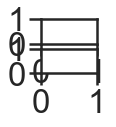

In [74]:
ls2 = []
times = np.linspace(0, 1.0, 4000)
trial_length = 4000
f, ax = plt.subplots(2, figsize = (1,1))
for fname in matches[:]:
    if 'bad' in fname:
        continue

    tmp_df = 0
    
    et = fname.split('\\')[-2].split()[0]
    training = fname.split('\\')[-2].split()[-1]
    if 'pre' in training or '1' in training:
        training = 'pre'
    else:
        training = 'post'
    stim1 =  fname.split('\\')[-1].split('_')[3][:3]
    
    ls = []

    try:
        tmp =  pd.read_hdf(fname, key = 'raw') 
    except:
        continue
    trials =  int(tmp.shape[1]/trial_length)


    csd_tmp = np.split(tmp, int(trials), axis = 1)
    csd_input = np.dstack(csd_tmp)
    

    csd_tmp = csd_input.mean(axis = 2)

    csd_tmp = pd.DataFrame(csd_tmp)
    csd_tmp = csd_tmp - csd_tmp.median(axis = 0)

    csd = oem.df_CSD_analysis( np.array(csd_tmp), ax, 
                      Channel_Number=np.shape(csd_tmp)[0], show_plot=False)
    tmp_df = pd.DataFrame(csd).stack().reset_index()
    tmp_df.columns = ['csd_step', 'samples', 'csd']
    tmp_df['et'] = et
#     tmp_df['paradigm'] = paradigm
    tmp_df['stim1'] = stim1
    tmp_df['fname'] = fname
    tmp_df['times'] = tmp_df['samples']/1000
    tmp_df['training'] = training 
    
    ls.append(tmp_df)

    
    tmp_df2 = pd.concat(ls)
    ls2.append(tmp_df2)
    
csd_df2 = pd.concat(ls2)
    

In [75]:
csd_df2.et.unique()

array(['488', '489', '367', '369', '378', '380', '377'], dtype=object)

In [79]:
# adjust time: stim1 at 1s. 380 pre, 377, 378 post
# stim1 at 0.5s: 009, 010 pre, rest at 1s
v = '378'
csd_df2.loc[((csd_df2.et == v) & (csd_df2.training == 'post')), 'times'] = csd_df2.loc[((csd_df2.et == v) 
                                                    & (csd_df2.training == 'post')), 'times'] - 0.50
csd_df2 = csd_df2.round({'times': 3})

In [58]:
# for probe 64DB, adjust times
for i,v in enumerate((sorted(csd_df2[csd_df2.et.str.startswith('0')].et.unique()))[:]):
    csd_df2.loc[((csd_df2.et == v) & (csd_df2.training == 'post')), 'times'] = csd_df2.loc[((csd_df2.et == v) 
                                                               & (csd_df2.training == 'post')), 'times'] - 0.50
    csd_df2 = csd_df2.round({'times': 3})

### Oddball

U:\Data\pak6\figures\LFP\probe_64DB\Thy1_FX\sf-nov-odd\481 right-2\_481 right_001_sf-tuning_2018-11-05_16-16-58_100_CH1_0.h5
tuning
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a =

discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783

discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
U:\Data\pak6\figures\LFP\probe_64DB\Thy1_FX\sf-nov-odd\486 left-2\_486 left_002_sf-nov-odd_2018-11-09_17-17-02_100_CH1_0.h5
novel oddball
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
U:\Data\pak6\figures\LFP\probe_64DB\Thy1_FX\sf-nov-odd\482 right-1\_482 right_006_opto-chirp_2018-11-05_11-44-33_100_CH1_0.h5
no paradigm
U:\Data\pak6\figures

discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
U:\Data\pak6\figures\LFP\probe_64DB\Thy1_FX\sf-nov-odd\479 right-2\_479 right_006_opto-chirp_2018-11-05_13-23-37_100_CH1

discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783

discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
U:\Data\pak6\figures\LFP\probe_64DB\Thy1_FX\sf-nov-odd\486 right-1\_486 right_004_sf-nov-odd_2018-11-08_16-57-36_100_CH1_2.h5
novel oddball
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
U:\Data\pak6\figures\LFP\probe_64DB\Thy1_FX\sf-nov-odd\486 right-1\_486 right_006_opto-ramp_2018-11-08_17-10-37_100_CH1_1.h5
no paradigm
U:\Data\pak6\figure

discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
U:\Data\pak6\figures\LFP\probe_64DB\Thy1_FX\sf-nov-odd\483 left-2\_483 left_002_sf-nov-odd_2018-11-09_11-04-07_100_CH1_0

discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
U:\Data\pak6\figures\LFP\probe_64DB\Thy1_FX\sf-nov-odd\484 left-2\_484 left_001_sf-tuning_2018-11-09_14-24-58_100_CH1_2.h5
tuning
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [

discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783

discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
U:\Data\pak6\figures\LFP\probe_64DB\Thy1_FX\sf-nov-odd\480 right-2\_480 right_006_opto-chirp_2018-11-05_15-07-56_100_CH1_2.h5
no paradigm
U:\Data\pak6\figures\LFP\probe_64DB\Thy1_FX\sf-nov-odd\480 right-2\_480 right_006_opto-chirp_2018-11-05_15-07-56_100_CH1_0.h5
no paradigm
U:\Data\pak6\figures\LFP\probe_64DB\Thy1_FX\sf-nov-odd\480 left-1\_480 left_002_sf-nov-odd_2018-11-04_19-22-17_100_CH1_0.h5
novel oddball
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]
discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.4

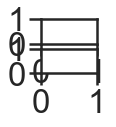

In [201]:
ls2 = []
times = np.linspace(0, 1.0, 1000)
f, ax = plt.subplots(2, figsize = (1,1))
for fname in matches:
    if 'bad' in fname:
        continue
    elif 'sf' in fname:
        print fname
    else:
        continue
    tmp_df = 0
    target_trials = ''
    stim_type = ''
    et = fname.split('\\')[-1].split()[0][1:]
    side = fname.split('\\')[-1].split()[1].split('_')[0]
    paradigm = fname.split('\\')[-1].split()[1].split('_')[2]
    
    ls = []

    if 'nov' in paradigm:
        trial_type = novel_oddball
        idx_odd = np.where(trial_type==9)[0]
        pre_odd = idx_odd-1
        print 'novel oddball'
    elif 'omis' in paradigm:
        trial_type = loc_omission
        idx_odd = np.where(trial_type==0)[0]
        pre_odd = idx_odd-1
        print 'loc_omission'
    elif 'control' in paradigm:
        trial_type = standard_control
        print 'std control'
    elif 'tuning' in paradigm:
        trial_type = sf_tuning
        print 'tuning'
    else:
        print 'no paradigm'
        continue
        
    try:
        tmp =  pd.read_hdf(fname, key = 'raw') 
    except:
        continue
    trials =  int(tmp.shape[1]/1000)


    csd_tmp = np.split(tmp, int(trials), axis = 1)
    csd_input = np.dstack(csd_tmp)
    
    if 'control' in paradigm or 'tuning' in paradigm:
        for j in np.unique(trial_type):
            stim_type = 'ctr'
            target_trials = np.where( trial_type == j)[0]
            csd_tmp = csd_input[:,:, target_trials].mean(axis = 2)
          
            csd_tmp = pd.DataFrame(csd_tmp)
            csd_tmp = csd_tmp - csd_tmp.median(axis = 0)

            csd = oem.df_CSD_analysis( np.array(csd_tmp), ax, 
                              Channel_Number=np.shape(csd_tmp)[0], show_plot=False)
            tmp_df = pd.DataFrame(csd).stack().reset_index()
            tmp_df.columns = ['csd_step', 'samples', 'csd']
            tmp_df['et'] = et
            tmp_df['paradigm'] = paradigm
            tmp_df['stim1'] = stim_type + str(j)
            tmp_df['fname'] = fname
            tmp_df['times'] = tmp_df['samples']/1000
            tmp_df['side'] = side 
            ls.append(tmp_df)
    else:
        for j in np.unique(trial_type):
            if j == 3:
                stim_type = 'std'
                csd_tmp = csd_input[:,:, pre_odd].mean(axis = 2)
            elif j == 9 or j == 0:
                stim_type = 'dev'
                csd_tmp = csd_input[:,:, idx_odd].mean(axis = 2)
            else:
                continue
            csd_tmp = pd.DataFrame(csd_tmp)
            csd_tmp = csd_tmp - csd_tmp.median(axis = 0)

            csd = oem.df_CSD_analysis( np.array(csd_tmp), ax, 
                              Channel_Number=np.shape(csd_tmp)[0], show_plot=False)
            tmp_df = pd.DataFrame(csd).stack().reset_index()
            tmp_df.columns = ['csd_step', 'samples', 'csd']
            tmp_df['et'] = et
            tmp_df['paradigm'] = paradigm
            tmp_df['stim1'] = stim_type + str(j)
            tmp_df['fname'] = fname
            tmp_df['times'] = tmp_df['samples']/1000
            tmp_df['side'] = side 
            ls.append(tmp_df)
    
    tmp_df2 = pd.concat(ls)
    ls2.append(tmp_df2)
    
csd_df2 = pd.concat(ls2)
    

In [76]:
csd_df2['group'] = csd_df2.et.map(sert_groups)
csd_df2.head()

csd_step  samples            csd   et stim1  \
0         0        0 -110087.682685  488   G-N   
1         0        1 -162997.229142  488   G-N   
2         0        2 -138371.268964  488   G-N   
3         0        3 -250630.303792  488   G-N   
4         0        4  -65249.603462  488   G-N   

                                               fname  times training group  
0  U:\Data\pak6\figures\LFP\probe_64DA\SERT KO\st...  0.000     post    wt  
1  U:\Data\pak6\figures\LFP\probe_64DA\SERT KO\st...  0.001     post    wt  
2  U:\Data\pak6\figures\LFP\probe_64DA\SERT KO\st...  0.002     post    wt  
3  U:\Data\pak6\figures\LFP\probe_64DA\SERT KO\st...  0.003     post    wt  
4  U:\Data\pak6\figures\LFP\probe_64DA\SERT KO\st...  0.004     post    wt

In [483]:
csd_df.paradigm.unique()

array(['sf-nov-odd', 'sf-tuning', 'sf-loc-omis'], dtype=object)

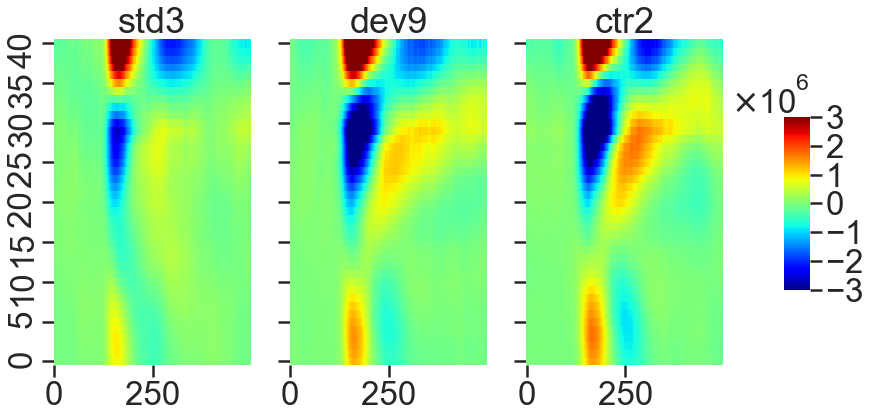

In [490]:
cond = 'stim1'
data = csd_df
_data = data[(data.paradigm.str.contains('odd'))
              | (data.stim1 == 'ctr2') 
               ] 
_data = _data[ (_data.times > 0.25)  & (_data.times < 0.75)]

n = sorted(_data[cond].unique())[::-1]

f,ax = plt.subplots(1, len(n), figsize = (12,6), sharey= True, sharex=True,facecolor = 'w')
cbar_ax = f.add_axes([.97, .3, .03, .4])
formatter = tkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-3, 3))

for idx, val in enumerate(n):
    hm_input = _data[_data[cond] == val].groupby(['csd_step', 
            'times']).mean().reset_index().pivot('csd_step', 'times', 'csd').values
    sns.heatmap(hm_input, cmap = 'jet',  annot=False, xticklabels = 250,  yticklabels = 5,
                ax = ax[idx], cbar=idx == 0,
                vmin = -3.0e6, vmax = 3.0e6, robust = True,   
                cbar_ax = None if idx else cbar_ax,  cbar_kws={"format": formatter}
               )
    ax[idx].invert_yaxis()
    ax[idx].set_title(val)
    
# plt.savefig("hm-csd-cbar.png", transparent=True)

In [511]:
sorted(_data[(_data.times == 0.4) & (_data.csd < -6e6)].csd_step.unique())

[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]

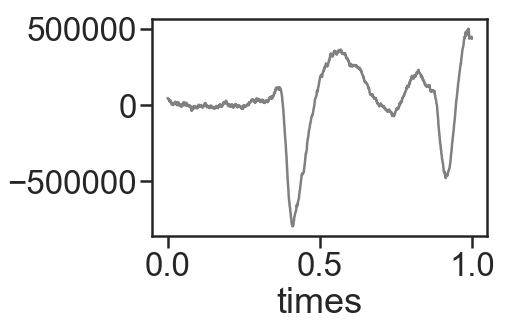

In [114]:
tmp = _data[(_data.csd_step > 6) 
            & (_data.csd_step<30) 
            & (_data.stim1 == 'ctr2')
           ]
tmp.groupby('times').mean().csd.plot()

In [106]:
df_serta.stim1.unique()

array(['G-1', 'G-N'], dtype=object)

In [107]:
df_serta.groupby(['group', 'et', 'paradigm']).fname.unique()

KeyError: 'paradigm'

In [7]:
path = r"U:\Data_Analysis\pak6\Analysis of LFP\fx_mmn_paper-lfp_master.pkl"
lfp_df = pd.read_pickle(path)

path = r"U:\Data_Analysis\pak6\Analysis of LFP\FX mmn paper\fx_mmn_paper-csd_master.pkl"
csd_df = pd.read_pickle(path)

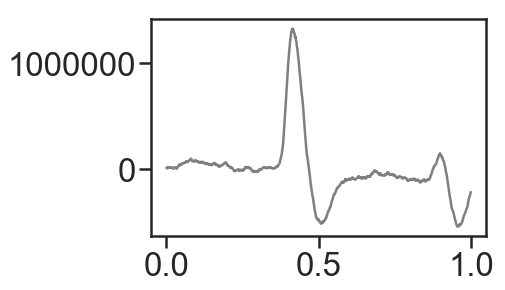

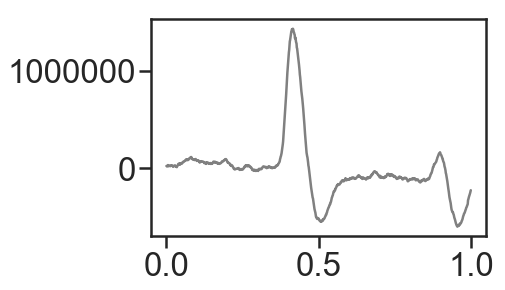

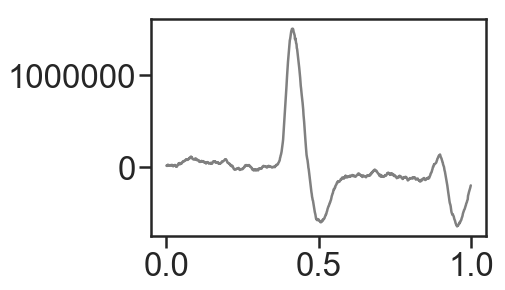

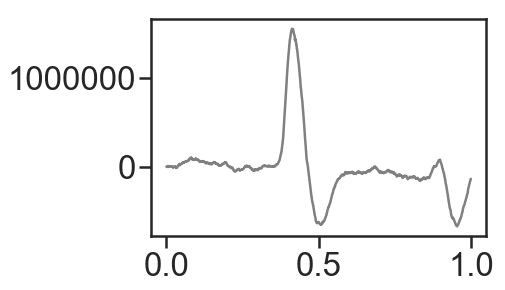

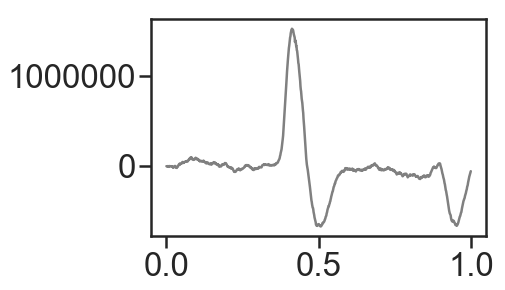

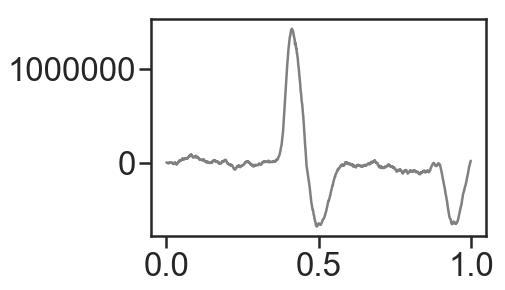

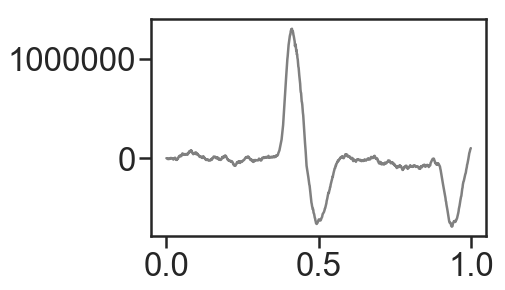

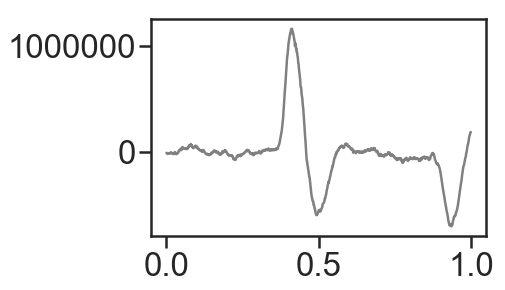

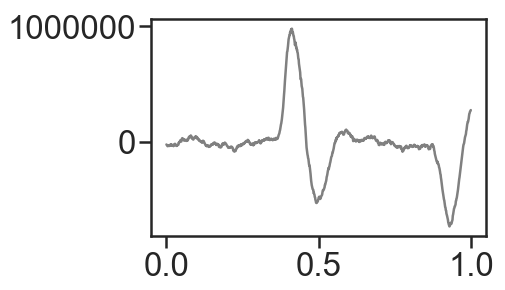

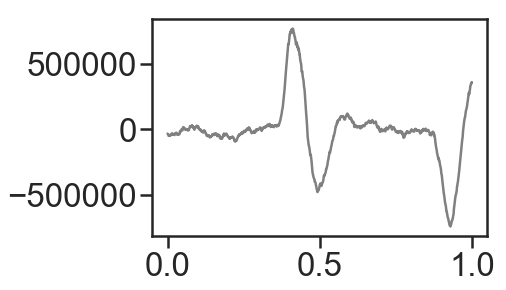

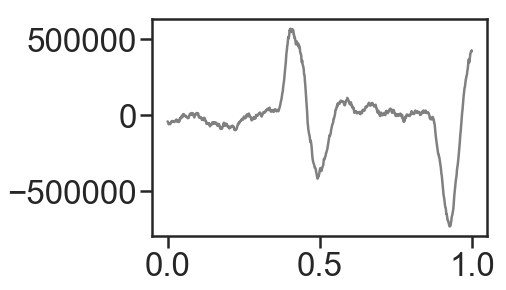

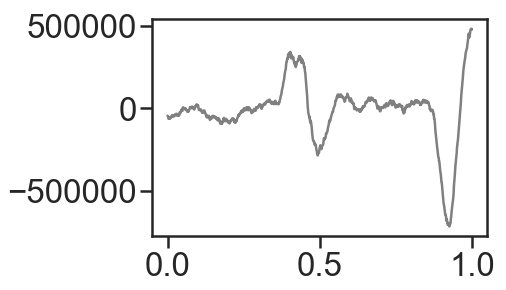

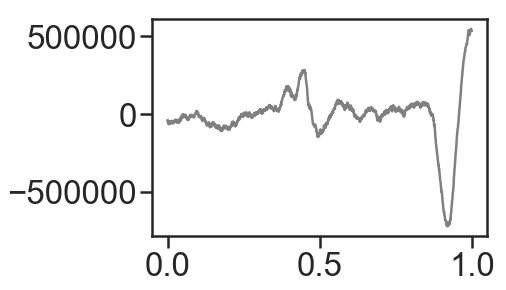

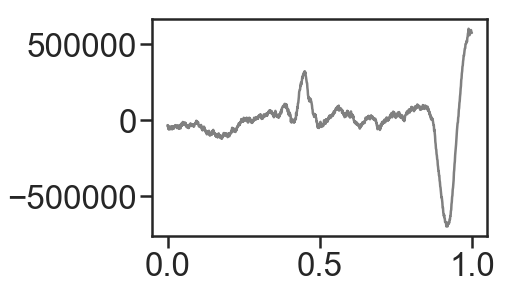

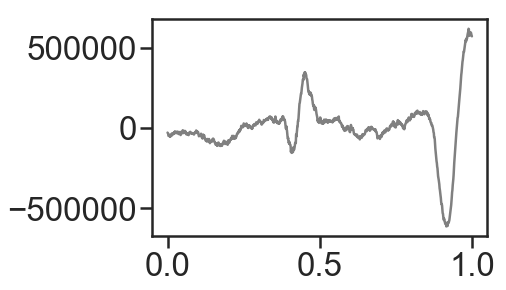

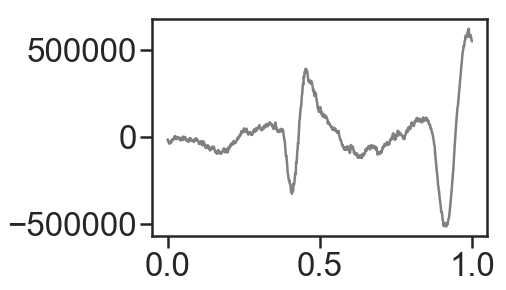

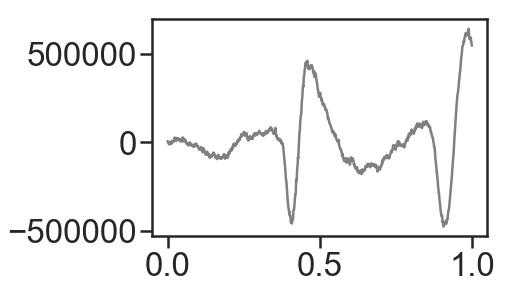

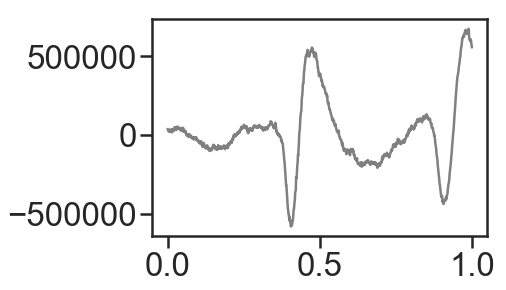

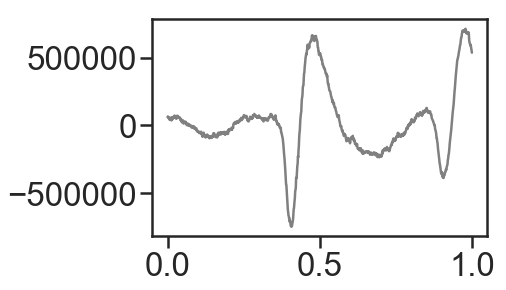

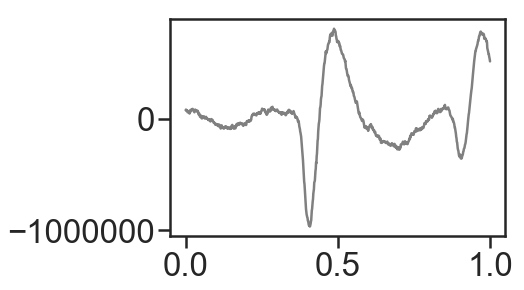

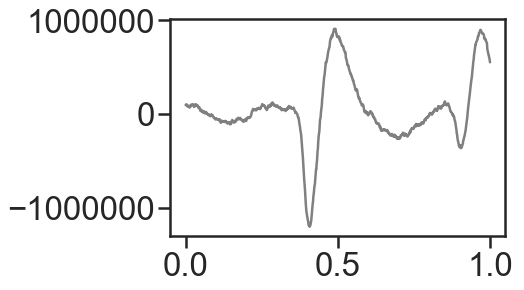

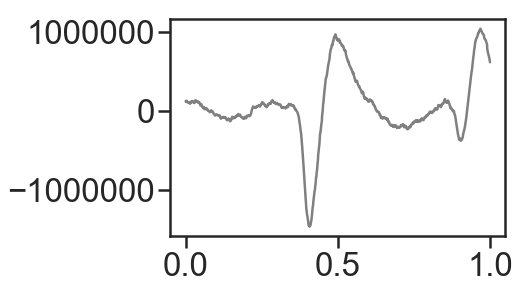

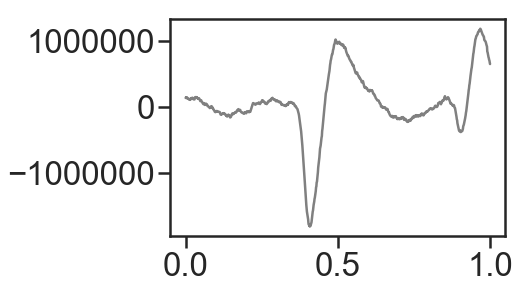

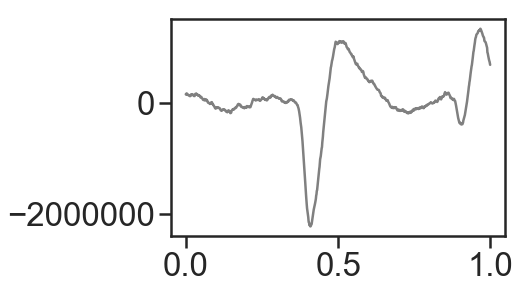

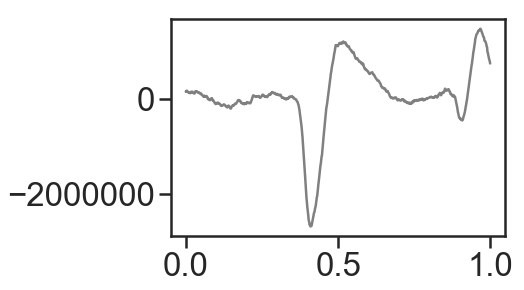

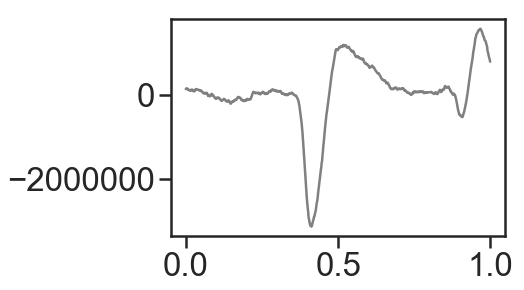

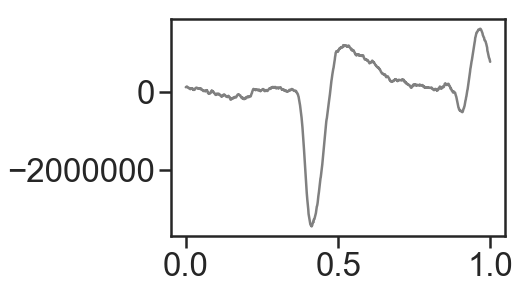

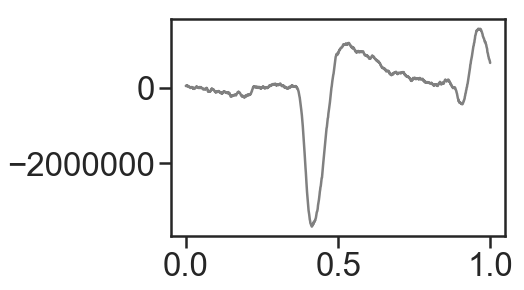

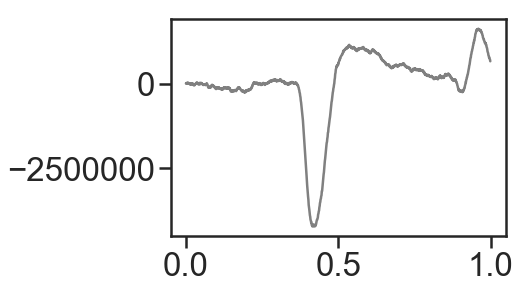

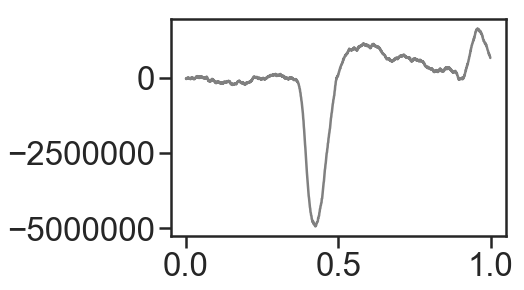

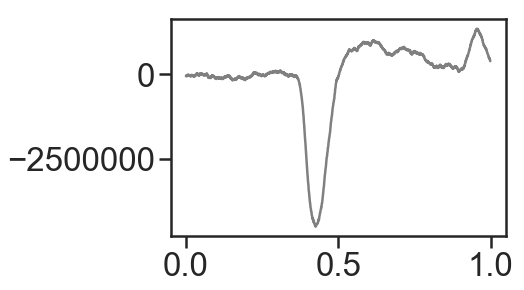

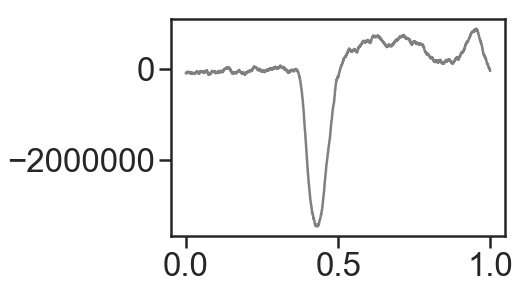

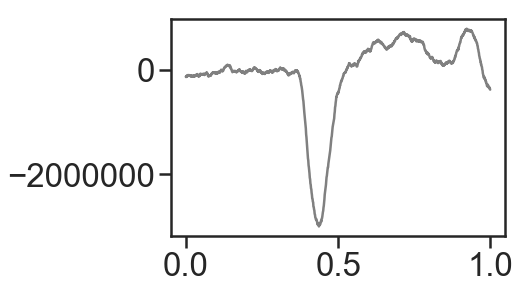

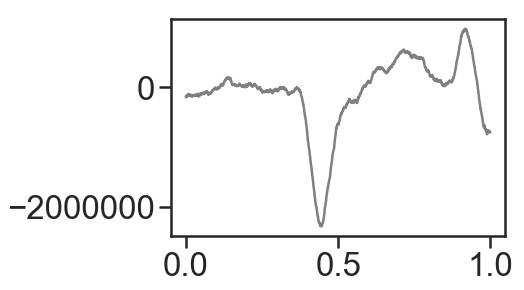

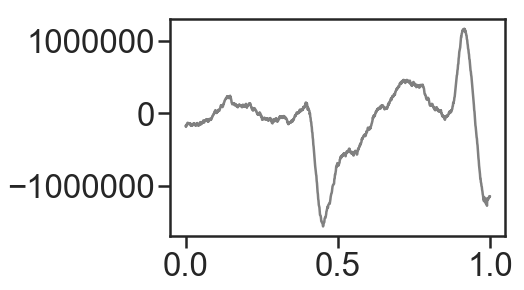

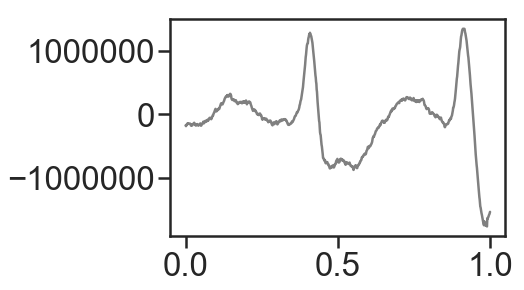

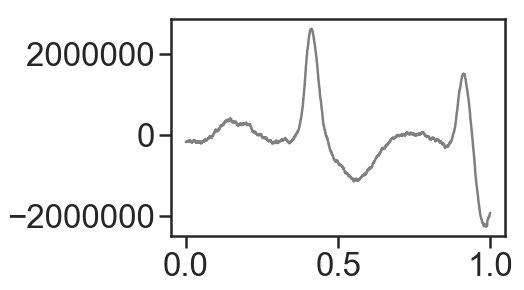

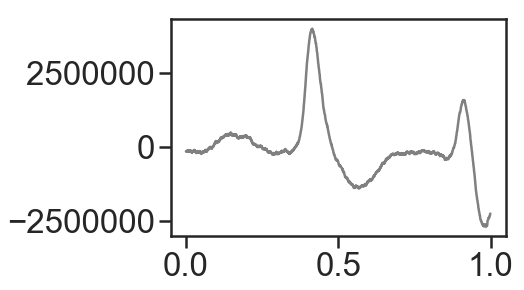

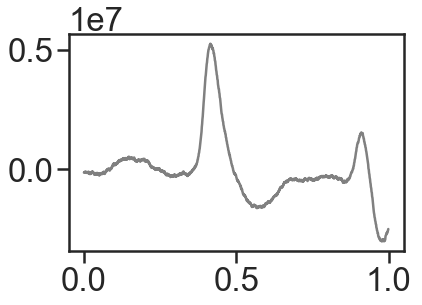

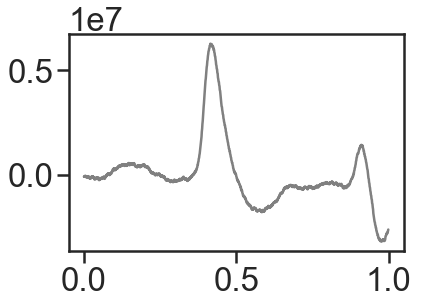

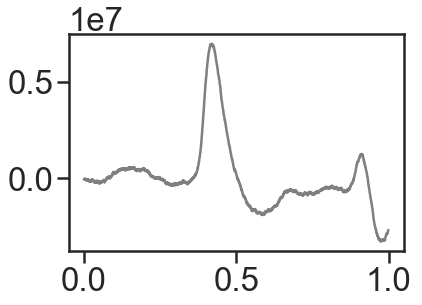

In [21]:
tmp = csd_df[csd_df.stim1 == 'dev9']
for i in sorted(tmp.csd_step.unique()[:]):
    plt.plot((tmp[tmp.csd_step == i].groupby('times').mean().csd))
    plt.show()
sns.despine()

In [540]:
csd_df.loc[:, 'layer'] = 'un'
csd_df.loc[csd_df['csd_step'] < 11, 'layer'] = 'l6'
csd_df.loc[(csd_df['csd_step'] >= 11) & (csd_df['csd_step'] < 22), 'layer'] = 'l5'
csd_df.loc[(csd_df['csd_step'] >= 22) & (csd_df['csd_step'] <= 30), 'layer'] = 'l4'
# csd_df.loc[(csd_df['csd_step'] >= 24) & (csd_df['csd_step'] <= 32), 'layer'] = 'l5'
csd_df.loc[csd_df['csd_step'] > 30, 'layer'] = 'l2/3'

In [5]:
path = r"U:\Data_Analysis\pak6\Analysis of LFP\SERT KO project\sert_l4_lfp_master.pkl"
sert_df = pd.read_pickle(path)

In [12]:
lfp_df.paradigm.unique()

array(['sf-tuning', 'sf-loc-omis', 'sf-nov-odd', 'loc-omis'], dtype=object)

## Analysis of Tuning

In [71]:
ls2 = []
times = np.linspace(0, 1.0, 1000)

groups = {'ET#304': 1, 'ET#271': 1, 'ET#309': 2, 'ET#270': 2, 'ET#313': 1, 'ET#307': 2}
sf_seq = [2, 0, 0, 4, 3, 3, 0, 4, 4, 3, 2, 5, 3, 2, 0, 4, 1, 0, 5, 2, 0, 
1, 0, 1, 3, 5, 2, 5, 1, 2, 0, 5, 2, 3, 5, 1, 0, 4, 3, 2, 5, 5, 3, 5, 
2, 0, 3, 3, 0, 3, 4, 5, 4, 1, 4, 0, 1, 5, 4, 1, 5, 3, 3, 5, 3, 3, 2, 
3, 2, 1, 1, 5, 1, 4, 1, 2, 3, 2, 4, 2, 1, 0, 5, 5, 2, 2, 4, 1, 4, 1, 
3, 1, 0, 4, 4, 4, 4, 0, 5, 4, 4, 0, 3, 5, 5, 2, 1, 3, 4, 1, 5, 0, 2, 
2, 0, 0, 0, 1, 2, 1]

contrast_seq = [1, 0.25, 0.125, 1, 0.0625, 1, 1, 0.5, 0.0625, 0.125, 0.5, 
0.125, 0.5, 0.5, 0.125, 0.125, 0.5, 0.25, 0.5, 0.0625, 1, 0.0625, 0.5, 1, 
1, 0.125, 1, 0.125, 0.125, 0.25, 0.0625, 0.0625, 0.125, 0.5, 0.125, 0.5, 
0.0625, 1, 1, 0.25, 0.25, 1, 1, 0.25, 0.125, 1, 0.25, 0.5, 0.0625, 0.5, 
0.125, 0.0625, 0.25, 0.0625, 0.25, 0.5, 0.25, 0.5, 0.125, 0.125, 1, 1, 
0.5, 0.5, 0.125, 1, 0.25, 0.0625, 0.25, 0.25, 1, 1, 0.25, 0.5, 0.5, 0.125, 
1, 0.125, 0.0625, 0.125, 0.25, 0.0625, 0.25, 0.0625, 0.0625, 0.0625, 0.5, 
0.125, 0.25, 0.5, 0.0625, 0.25, 0.5, 0.0625, 0.25, 1, 0.0625, 0.0625, 0.25, 0.125]

exp_type = dir_seq
for fname in sorted(matches)[:3]:
    print fname
#     et = fname.split('\\')[-1].split('_')[1].split()[0]
#     rec = fname.split('\\')[-1].split('_')[2]
#     paradigm = fname.split('\\')[-1].split('_')[3]
    
    ls = []

    try:
        tmp =  pd.read_hdf(fname, key = 'raw') 
    except:
        continue
    trials =  int(tmp.shape[1]/1000)

    df3_array=np.reshape(tmp.values,(np.shape(tmp)[0],trials, -1))
    df3_avg=np.mean(df3_array,1)
    df3_avg = pd.DataFrame(df3_avg).T        
    df3_avg['times'] = times
    negativity_ch_idx=df3_avg[(df3_avg['times']>=0.35) & (df3_avg['times']< 0.45)].ix[:,8:16].min().idxmin()
#     negativity_ch_idx = negativity_ch_idx - 4
    print negativity_ch_idx
    # plotting the spectra and FFR for the maximum negativity channel, the first trial
    ddf = tmp.values[negativity_ch_idx,:]
    ddf2=np.reshape(ddf,(trials, 1000))
    ddf2 = pd.DataFrame(ddf2)
    ddf2['trial'] = exp_type[:ddf2.shape[0]]
    for j in ddf2.trial.unique():
    
        lfp = ddf2[ddf2.trial==j].iloc[:,:].mean().drop('trial')
#         if j==3 or j ==9:
#             plt.plot(lfp)
#             plt.show()
        tmp_df = pd.DataFrame({ 'lfp':lfp, 'paradigm': '12-dir', 'stim1':j, 'abs_times': times + j*1,
                               'fname':fname, 'times':times })
        ls.append(tmp_df)
    tmp_df2 = pd.concat(ls)
    ls2.append(tmp_df2)
    
df_tuning = pd.concat(ls2)
    

U:\Data\pak6\figures\LFP\probe_64DA\WT\kic-ori\_KIC13-right_003_12-drifting_2019-04-10_12-40-38_100_CH1_0.h5


C:\Users\Chub_lab\Anaconda2\lib\site-packages\ipykernel_launcher.py:40: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


15
U:\Data\pak6\figures\LFP\probe_64DA\WT\kic-ori\_KIC13-right_003_12-drifting_2019-04-10_12-40-38_100_CH1_1.h5
15
U:\Data\pak6\figures\LFP\probe_64DA\WT\kic-ori\_KIC13-right_003_12-drifting_2019-04-10_12-40-38_100_CH1_2.h5
15


In [16]:
ddf2.trial.unique()

array([10,  7,  3,  2,  4,  8,  9,  5,  1,  0, 11,  6], dtype=int64)

In [509]:
groups = {'205':1, '206':1, '207':1, '212':3, '213':3, '214':3 }
con_tuning['group'] = con_tuning.et.map(groups)

In [15]:
idx = int(lfp_df.shape[0]/1000)*[np.arange(0,1,0.001)]
lfp_df['times']= np.concatenate(idx)


In [188]:
sns.pal

ch_idx   et                                              fname layer  \
0      20  023  U:\Data\pak6\figures\LFP\probe_64DB\FX\sf-nov-...  l2/3   
1      20  023  U:\Data\pak6\figures\LFP\probe_64DB\FX\sf-nov-...  l2/3   
2      20  023  U:\Data\pak6\figures\LFP\probe_64DB\FX\sf-nov-...  l2/3   
3      20  023  U:\Data\pak6\figures\LFP\probe_64DB\FX\sf-nov-...  l2/3   
4      20  023  U:\Data\pak6\figures\LFP\probe_64DB\FX\sf-nov-...  l2/3   

         lfp   paradigm     side stim1     times group  
0  32.940136  sf-tuning  right-1  ctr0  0.000000    wt  
1  34.479971  sf-tuning  right-1  ctr0  0.001001    wt  
2  39.066755  sf-tuning  right-1  ctr0  0.002002    wt  
3  38.885455  sf-tuning  right-1  ctr0  0.003003    wt  
4  32.082107  sf-tuning  right-1  ctr0  0.004004    wt

## Load data

In [8]:
path = r"U:\Data_Analysis\pak6\Analysis of LFP\SERT KO project\lfp_l4_sert_master.pkl"
df_sert = pd.read_pickle(path)

In [53]:
# tmp = df_sert[df_sert.group == 'wt']
df_tmp = pd.concat([tmp, df_hdac]).reset_index(drop = True)

In [9]:
df_master = sert_df

In [112]:
df_sert_master = pd.concat([df_sert_da, df_sert_db])

In [8]:
sert_df.groupby(['group', 'et', 'training']).fname.unique()

group  et     training
het    006    post        [U:\Data\pak6\figures\LFP\probe_64DB\SERT KO\s...
       007    post        [U:\Data\pak6\figures\LFP\probe_64DB\SERT KO\s...
              pre         [U:\Data\pak6\figures\LFP\probe_64DB\SERT KO\s...
       008    post        [U:\Data\pak6\figures\LFP\probe_64DB\SERT KO\s...
              pre         [U:\Data\pak6\figures\LFP\probe_64DB\SERT KO\s...
       377    post        [U:\Data\pak6\figures\LFP\probe_64DA\SERT KO\s...
       931    post        [U:\Data\pak6\figures\LFP\probe_64DB\SERT KO\s...
              pre         [U:\Data\pak6\figures\LFP\probe_64DB\SERT KO\s...
       936    post        [U:\Data\pak6\figures\LFP\probe_64DB\SERT KO\s...
              pre         [U:\Data\pak6\figures\LFP\probe_64DB\SERT KO\s...
       944    post        [U:\Data\pak6\figures\LFP\probe_64DB\SERT KO\s...
              pre         [U:\Data\pak6\figures\LFP\probe_64DB\SERT KO\s...
       959    post        [U:\Data\pak6\figures\LFP\probe_64DB\SE

## Plotting avg traces

In [69]:
# adjust time: stim1 at 1s. 380 pre, 378, 378 post
# stim1 at 0.5s: 009, 010 pre, rest at 1s
v = '380'
df_serta.loc[((df_serta.et == v) & (df_serta.training == 'pre')), 'times'] = df_serta.loc[((df_serta.et == v) 
                                                    & (df_serta.training == 'pre')), 'times'] - 0.50
df_serta = df_serta.round({'times': 3})

In [46]:
df_master = pd.concat([df_sert, df_sert_l4])

In [201]:
df_master.to_pickle('sert_l4_lfp_master.pkl')

In [25]:
colors_training = ['gray', 'crimson']
colors_group = [ 'k', 'blue', 'magenta']

In [36]:
for i,v in enumerate((sorted(df_sert_l4.et.unique()))[:]):
    df_sert_l4.loc[((df_sert_l4.et == v)), 'times'] = df_sert_l4.loc[((df_sert_l4.et == v)), 'times'] - 0.50
    df_sert_l4 = df_sert_l4.round({'times': 3})

In [55]:
for i,v in enumerate((sorted(df_tmp[df_tmp.group == 'hdac'].et.unique()))):
    df_tmp.loc[((df_tmp.et == v) ), 'times'] = df_tmp.loc[((df_tmp.et == v)) , 'times'] - 0.50
#     df_tmp.loc[((df_tmp.et == v) ), 'times'] = df_tmp.loc[((df_tmp.et == v) ), 'times'].round({'times': 3})

(-350, 250)

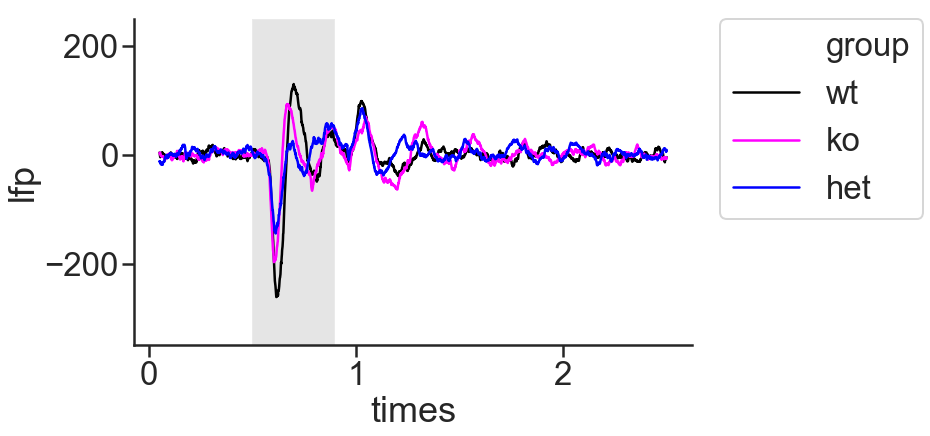

In [11]:
plt.figure(figsize=(10, 6), facecolor='w')
data = df_master
data = data[(data.stim1.str.contains('N') )
#               & (data.stim1 == 'G-1') 
            & (data.training == 'post')
               ] 
# data = data[(data.paradigm.str.contains('odd')) | (data.stim1 == 'ctr2')]
# data = data[(data.times > 0) & (data.times < 1.5) ]

colors_training = ['gray', 'crimson']
colors_group = [ 'k', 'magenta', 'blue']
# colors_group = ['k', 'coral']
# colors_stim = ['gray', 'crimson', 'green']
# data = data[(data.group != 'wat') & (data.layer == 'l4')]

# # data = data[data.rec.str.contains('1')]

data = data[(data.times > 0.05) & (data.times < 2.5)]
# data['abs_times'] = data['stim1'].str.split('ctr', expand = True)[1].astype('int')*0.3 + data['times']
# data = data[(data.stim1 == 1) | (data.stim1 == 3)]
# data = data[data.et == data.et.unique()[3]]
# print data.et.unique()
# data = data.groupby(['group' ,'stim1', 'rec']).mean().reset_index()
data = data.sort_values(by=['group', 'training'], ascending=[ False, False])

sns.lineplot( x = 'times',  y = 'lfp', data = data,
               legend = 'full', hue = 'group', 
             palette = colors_group,
           estimator = np.nanmean, ci = None
            )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
sns.despine()
# plt.axhline(y = 0)
# plt.axvline(x = 0.5)
plt.axvspan(0.5, 0.9, facecolor="gray",alpha=0.2) 
# plt.xlim(0, 1)
plt.ylim(-350, 250)
# plt.savefig("line-sert-l4-gn-post.pdf", transparent=True)

In [40]:
data.head()

group stim1   et  times  ch_idx       lfp
0    fx  ctr2  014  0.051    12.5  1.324569
1    fx  ctr2  014  0.052    12.5  5.640525
2    fx  ctr2  014  0.053    12.5  7.866965
3    fx  ctr2  014  0.054    12.5  7.722270
4    fx  ctr2  014  0.055    12.5  3.657946

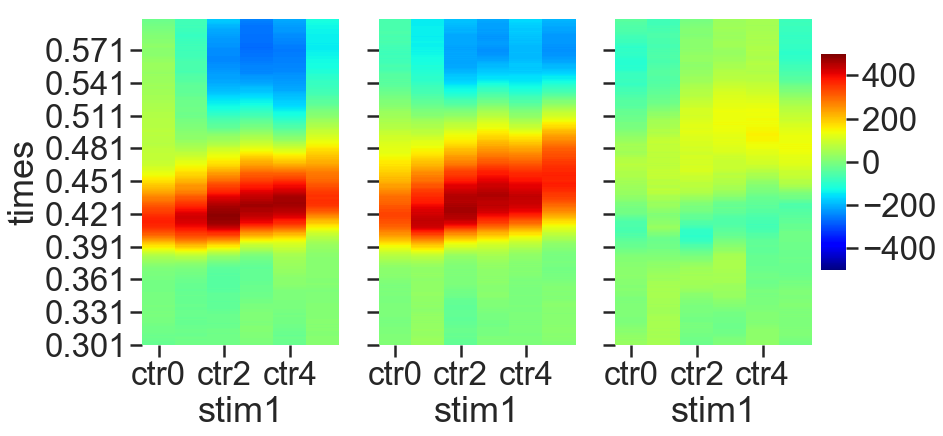

In [64]:
f, ax = plt.subplots( 1, 3, sharey = True, figsize =(12,6))
cbar_ax = f.add_axes([.91, .3, .03, .5])
vmin, vmax = -500, 500
data = lfp_df[(lfp_df.stim1.str.contains('ctr')) & (lfp_df.times > 0.3) 
              & (lfp_df.times < 0.6) & (lfp_df.layer == 'l2/3')]
tmp = data.groupby(['group', 'stim1', 'times']).lfp.mean().reset_index()
tmp2 = tmp[tmp.group == 'wt'].pivot('times', 'stim1', 'lfp')
tmp3 = tmp[tmp.group == 'fx'].pivot('times', 'stim1', 'lfp')
sns.heatmap(tmp2, cmap = 'jet', ax = ax[0], cbar = False, vmin = vmin, vmax = vmax)
sns.heatmap(tmp3, cmap = 'jet', ax = ax[1], cbar = False,  vmin = vmin, vmax = vmax)
sns.heatmap(tmp3.sub(tmp2), cmap = 'jet', ax = ax[2],  vmin = vmin, vmax = vmax, cbar_ax = cbar_ax)
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[0].invert_yaxis()
# plt.savefig("hm-l23-sf_by_time.pdf", transparent=True)

In [14]:
lfp_df.layer.unique()

array(['l2/3', 'l4', 'l5/6'], dtype=object)

In [7]:
csd_df.head()

csd_step  samples            csd   et    paradigm stim1  \
0         0        0 -225913.118921  W05  sf-nov-odd  std3   
1         0        1 -224364.457510  W05  sf-nov-odd  std3   
2         0        2 -227178.272052  W05  sf-nov-odd  std3   
3         0        3 -217139.648463  W05  sf-nov-odd  std3   
4         0        4 -215437.704080  W05  sf-nov-odd  std3   

                                               fname  times    side group  \
0  U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-...  0.000  left-1    wt   
1  U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-...  0.001  left-1    wt   
2  U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-...  0.002  left-1    wt   
3  U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-...  0.003  left-1    wt   
4  U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-...  0.004  left-1    wt   

  layer    zscore  
0    l2 -0.389039  
1    l2 -0.385551  
2    l2 -0.391889  
3    l2 -0.369278  
4    l2 -0.365445

In [91]:
Mean = csd_df.groupby(['fname', 'csd_step']).csd.transform('mean')    
Std = csd_df.groupby(['fname', 'csd_step']).csd.transform('std')
csd_df['zscore'] = (csd_df.csd.values - Mean) / Std

In [547]:
tmp

group         rec layer stim1           csd
262    wt   013left-2  l2/3  std3 -6.868478e+06
265    wt   013left-2    l4  std3 -2.907634e+06
268    wt   013left-2    l5  std3 -2.417113e+06
271    wt   013left-2    l6  std3 -2.848365e+06
274    wt   017left-2  l2/3  std3 -1.433176e+06
277    wt   017left-2    l4  std3 -1.509146e+06
280    wt   017left-2    l5  std3 -1.761203e+06
283    wt   017left-2    l6  std3 -1.271748e+06
286    wt  017right-1  l2/3  std3 -2.319002e+06
289    wt  017right-1    l4  std3 -4.258594e+06
292    wt  017right-1    l5  std3 -9.587307e+05
295    wt  017right-1    l6  std3 -6.874746e+05
298    wt   019left-2  l2/3  std3 -2.184865e+06
301    wt   019left-2    l4  std3 -1.916903e+06
304    wt   019left-2    l5  std3 -1.644808e+06
307    wt   019left-2    l6  std3 -1.230750e+06
310    wt  019right-1  l2/3  std3 -1.360611e+06
313    wt  019right-1    l4  std3 -1.608005e+06
316    wt  019right-1    l5  std3 -7.291863e+05
319    wt  019right-1    l6  std3 -4.642512e+05
322    wt   020left-2  l2/3  std3 -1.471682e+06
325    wt   020left-2    l4  std3 -1.543850e+06
328    wt   020left-2    l5  std3 -1.648801e+06
331    wt   020left-2    l6  std3 -9.918309e+05
334    wt  020right-1  l2/3  std3 -1.719287e+06
337    wt  020right-1    l4  std3 -3.353430e+06
340    wt  020right-1    l5  std3 -8.171187e+05
343    wt  020right-1    l6  std3 -3.316159e+05
346    wt   023left-2  l2/3  std3 -1.687965e+06
349    wt   023left-2    l4  std3 -2.850425e+06
..    ...         ...   ...   ...           ...
174    fx   034left-1    l5  ctr2 -1.094130e+06
175    fx   034left-1    l6  ctr2 -1.212293e+06
176    fx     480left  l2/3  ctr2 -9.575441e+06
179    fx     480left    l4  ctr2 -9.262035e+06
182    fx     480left    l5  ctr2 -1.572871e+06
185    fx     480left    l6  ctr2 -1.050885e+06
188    fx    480right  l2/3  ctr2 -4.206108e+06
191    fx    480right    l4  ctr2 -3.074469e+06
194    fx    480right    l5  ctr2 -1.978357e+06
197    fx    480right    l6  ctr2 -2.894864e+06
200    fx     481left  l2/3  ctr2 -1.674341e+06
203    fx     481left    l4  ctr2 -2.001221e+06
206    fx     481left    l5  ctr2 -6.713394e+05
209    fx     481left    l6  ctr2 -7.794595e+05
212    fx    481right  l2/3  ctr2 -2.155633e+06
215    fx    481right    l4  ctr2 -1.640547e+06
218    fx    481right    l5  ctr2 -8.200846e+05
221    fx    481right    l6  ctr2 -1.620762e+06
224    fx    482right  l2/3  ctr2 -7.368412e+06
227    fx    482right    l4  ctr2 -1.843886e+06
230    fx    482right    l5  ctr2 -2.021666e+06
233    fx    482right    l6  ctr2 -1.830394e+06
236    fx     486left  l2/3  ctr2 -2.681664e+06
239    fx     486left    l4  ctr2 -2.078151e+06
242    fx     486left    l5  ctr2 -6.054352e+05
245    fx     486left    l6  ctr2 -6.959702e+05
248    fx    486right  l2/3  ctr2 -3.008380e+06
251    fx    486right    l4  ctr2 -6.057484e+06
254    fx    486right    l5  ctr2 -1.507795e+06
257    fx    486right    l6  ctr2 -1.043432e+06

[548 rows x 5 columns]

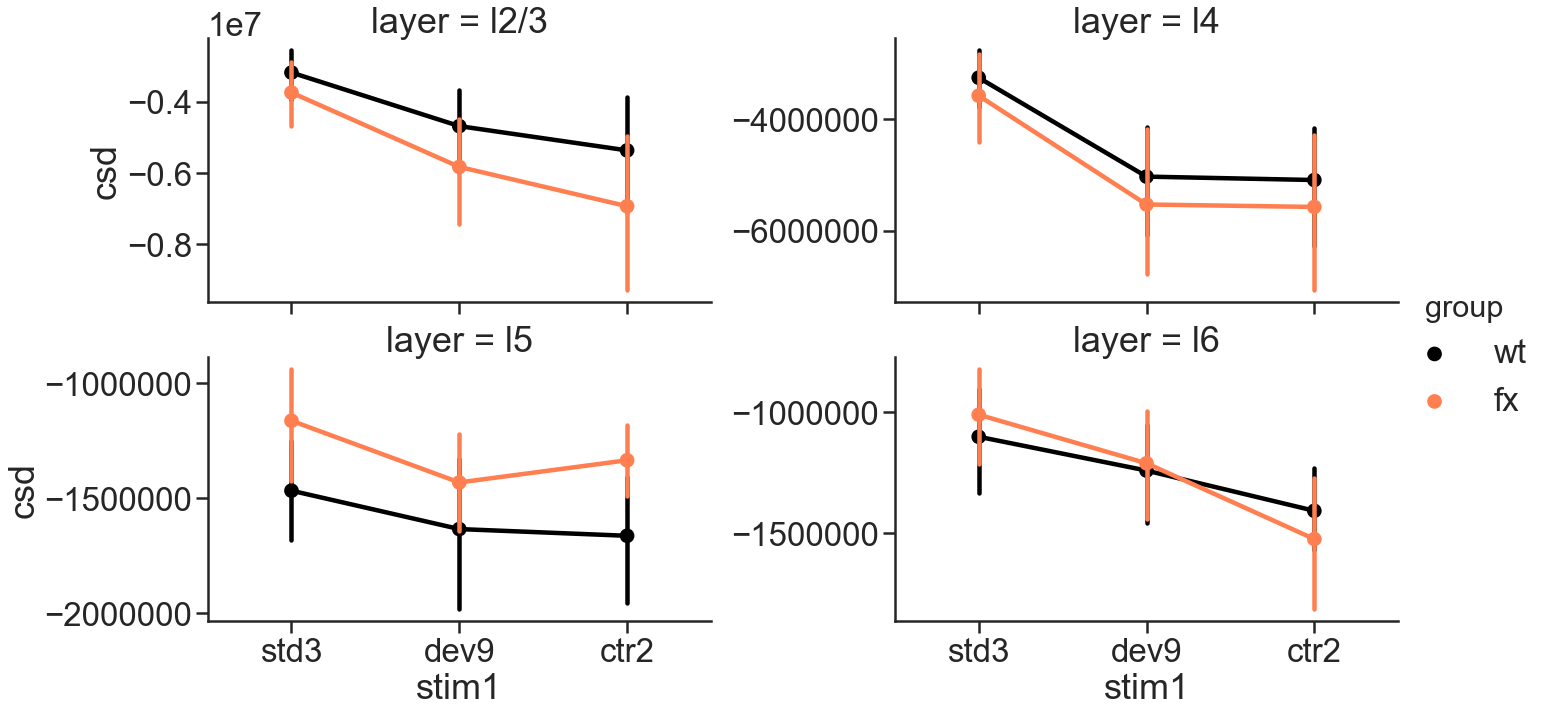

In [546]:
data = csd_df[(csd_df.paradigm.str.contains('odd') )
              | (csd_df.stim1.str.contains('ctr2'))
             ]
data = data[(data.times > 0.35) & (data.times < 0.7)]
data = data.groupby(['group', 'rec', 'layer' ,'stim1', 'csd_step']).min().reset_index()
tmp = data.groupby(['group', 'rec', 'layer' ,'stim1']).csd.mean().reset_index()
tmp = tmp.sort_values(by=['group', 'stim1'], ascending=[ False, False])
sns.factorplot(x = 'stim1', y = 'csd', data = tmp, palette = colors_group,
              hue = 'group', height = 5, aspect = 2,
                col = 'layer', col_wrap = 2, sharey = False,
              )
# plt.savefig("point-csd-across-layers.pdf", transparent=True)

002


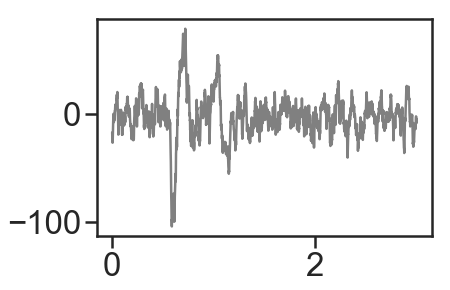

005


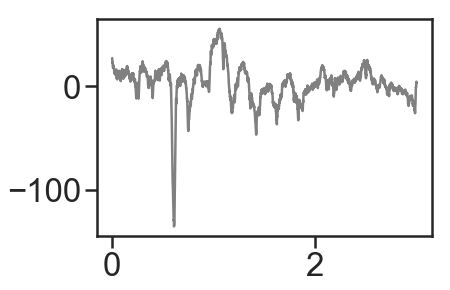

010


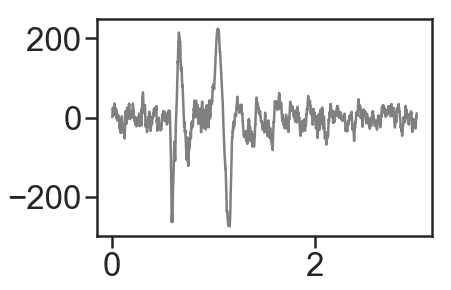

008


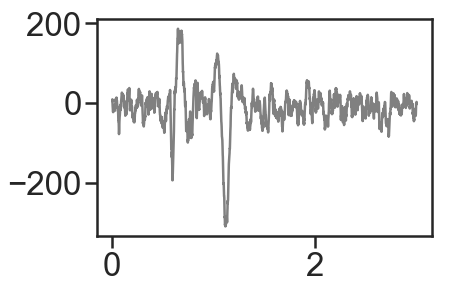

003


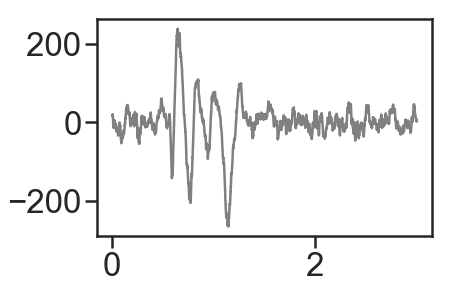

009


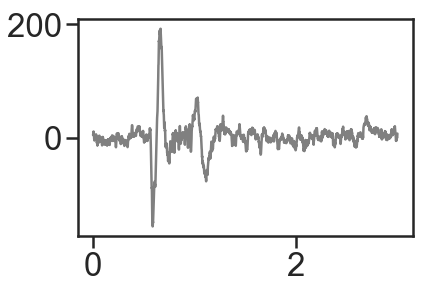

007


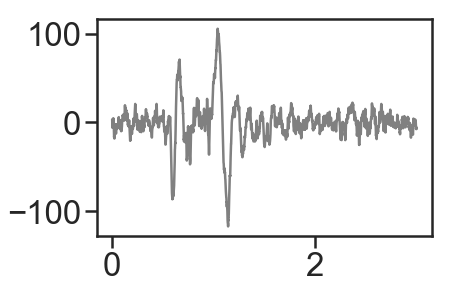

In [30]:
tmp = df_sert[(df_sert.stim1 == '1') & (df_sert.training == 'right1') 
              & (df_sert.times > 0) & (df_sert.times < 3)
             ]
for et in tmp.et.unique():
    print et
    tmp2 = tmp[tmp.et == et]
    plt.plot(tmp2.groupby('times').lfp.mean())
    plt.show()
#     break

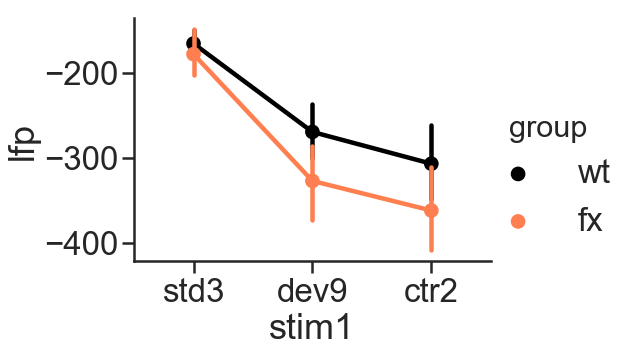

In [446]:
fig_inp = data[(data.times > 0.35) & (data.times < 0.5)]
colors = ['green', 'crimson', 'gray']
fig_inp = fig_inp.groupby([ 'rec', 'stim1']).min().reset_index()
fig_inp = fig_inp.sort_values(by = ['stim1', 'group'], ascending= [False, False])
g = sns.factorplot(x = "stim1", y = "lfp",   data = fig_inp,  kind = 'point', ci = 68, 
                   palette = colors_group, hue = 'group',
#                    capsize = 0.02, saturation = 1,
                   height = 5, aspect = 1.5 )
# plt.savefig("vep_bar_fx_mmn_l4.pdf", transparent=True)

In [50]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

C:\Users\Chub_lab\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [63]:
fig_inp['lfp_tr'] = abs(fig_inp.lfp)**0.4
model = ols('lfp_tr ~ C(group)*C(stim1)', fig_inp).fit()

# Seeing if the overall model is significant
print("Overall model F", model.df_model,model.df_resid, model.fvalue, model.f_pvalue)

('Overall model F', 5.0, 92.0, 5.480972188354772, 0.00018450645818584424)


In [64]:
# Durban-Watson: autocorrelation: 2(no), 0-2 (positive), 2-4 (negative)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lfp_tr   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     5.481
Date:                Thu, 19 Dec 2019   Prob (F-statistic):           0.000185
Time:                        13:46:20   Log-Likelihood:                -206.56
No. Observations:                  98   AIC:                             425.1
Df Residuals:                      92   BIC:                             440.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          10.4256      0.498     20.915      0.000       9.436      11.416
C(group)[T.wt]                     -0.9159      0.705     -1.299      0.197      -2.316       0.484
C(stim1)[T.dev9]                   -0.4152      0.728     -0.570      0.570      -1.861       1.031
C(stim1)[T.std3]                   -2.6800      0.728     -3.681      0.000      -4.126      -1.234
C(group)[T.wt]:C(stim1)[T.dev9]    -0.0983      1.013     -0.097      0.923      -2.111       1.915
C(group)[T.wt]:C(stim1)[T.std3]     0.6747      1.013      0.666      0.507      -1.338       2.687
==============================================================================
Omnibus:                        3.020   Durbin-Watson:                   1.394
Prob(Omnibus):                  0.221   Jarque-Bera (JB):                2.879
Skew:                           0.416   Prob(JB):                        0.237
Kurtosis:                       2.894   Cond. No.                         9.74
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
res = sm.stats.anova_lm(model, typ= 2)
res

sum_sq    df          F    PR(>F)
C(group)            12.948463   1.0   3.065307  0.083313
C(stim1)            98.509448   2.0  11.660138  0.000031
C(group):C(stim1)    2.840950   2.0   0.336271  0.715304
Residual           388.626153  92.0        NaN       NaN

In [66]:
model2 = ols('lfp_tr ~ C(group)+ C(stim1)', fig_inp).fit()

# Seeing if the overall model is significant
print("Overall model F", model2.df_model,model2.df_resid, model2.fvalue, model2.f_pvalue)

('Overall model F', 3.0, 94.0, 9.038412506866676, 2.561750902310726e-05)


In [67]:
res2 = sm.stats.anova_lm(model2, typ= 2)
res2

sum_sq    df          F    PR(>F)
C(group)   12.948463   1.0   3.109215  0.081100
C(stim1)   98.509448   2.0  11.827160  0.000026
Residual  391.467103  94.0        NaN       NaN

In [78]:
fig_inp['cond'] = fig_inp['stim1'] + fig_inp['group']

In [101]:
fig_inp.groupby(['group', 'et']).stim1.unique()

group  et 
fx     014    [std3, dev9, ctr2]
       016    [std3, dev9, ctr2]
       022    [std3, dev9, ctr2]
       024    [std3, dev9, ctr2]
       025    [std3, dev9, ctr2]
       026    [std3, dev9, ctr2]
       027    [std3, dev9, ctr2]
       028    [std3, dev9, ctr2]
       030    [std3, dev9, ctr2]
       031    [std3, dev9, ctr2]
       032                [ctr2]
       033    [std3, dev9, ctr2]
       034                [ctr2]
       480    [std3, dev9, ctr2]
       481    [std3, dev9, ctr2]
       482    [std3, dev9, ctr2]
       486    [std3, dev9, ctr2]
wt     013    [std3, dev9, ctr2]
       017    [std3, dev9, ctr2]
       019    [std3, dev9, ctr2]
       020    [std3, dev9, ctr2]
       023    [std3, dev9, ctr2]
       029    [std3, dev9, ctr2]
       035    [std3, dev9, ctr2]
       479    [std3, dev9, ctr2]
       483    [std3, dev9, ctr2]
       484    [std3, dev9, ctr2]
       485    [std3, dev9, ctr2]
       W00    [std3, dev9, ctr2]
       W01    [std3, dev9, ctr2]

In [447]:
wt_std = fig_inp[(fig_inp.stim1 == 'std3') & (fig_inp.group == 'wt')].lfp.dropna().values
wt_dev = fig_inp[(fig_inp.stim1 == 'dev9') & (fig_inp.group == 'wt')].lfp.dropna().values
wt_ctr = fig_inp[(fig_inp.stim1 == 'ctr2') & (fig_inp.group == 'wt')].lfp.dropna().values

fx_std = fig_inp[(fig_inp.stim1 == 'std3') & (fig_inp.group == 'fx')].lfp.dropna().values
fx_dev = fig_inp[(fig_inp.stim1 == 'dev9') & (fig_inp.group == 'fx')].lfp.dropna().values
fx_ctr = fig_inp[(fig_inp.stim1 == 'ctr2') & (fig_inp.group == 'fx')].lfp.dropna().values

print np.mean(wt_std), sstat.sem(wt_std)
print np.mean(wt_dev), sstat.sem(wt_dev)
print np.mean(wt_ctr), sstat.sem(wt_ctr)


print (len(wt_std), len(fx_std))

# print sstat.kruskal(x1, x2, x3)

p1 =  sstat.mannwhitneyu(wt_std, wt_dev)[1]
p2 = sstat.mannwhitneyu(wt_std, wt_ctr)[1]
p3 =  sstat.mannwhitneyu(wt_dev, wt_ctr)[1]

p4 =  sstat.mannwhitneyu(fx_std, fx_dev)[1]
p5 =  sstat.mannwhitneyu(fx_std, fx_ctr)[1]
p6 =  sstat.mannwhitneyu(fx_dev, fx_ctr)[1]

p7 =  sstat.mannwhitneyu(wt_std, fx_std)[1]
p8 =  sstat.mannwhitneyu(wt_dev, fx_dev)[1]
p9 =  sstat.mannwhitneyu(wt_ctr, fx_ctr)[1]

pvals = np.array((p1, p2, p3, p4, p5, p6, p7, p8, p9))
adj = statsmodels.stats.multitest.multipletests(pvals, method='holm')
print pvals
print adj[1]

-165.89926419651795 16.173392860098712
-269.85818024495455 33.235238712778205
-307.238559053415 45.1389776387033
(24, 21)
[0.0045 0.0008 0.258  0.0041 0.0024 0.3711 0.4955 0.1968 0.225 ]
[0.0289 0.007  0.9839 0.0289 0.0192 0.9839 0.9839 0.9839 0.9839]


[0.0096 0.0008 0.2243 0.0045 0.0023 0.3389 0.44   0.0931 0.1208]
[0.0575 0.0069 0.6729 0.0314 0.0185 0.6779 0.6779 0.4657 0.4831]


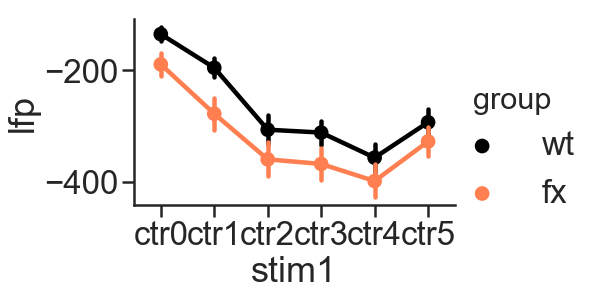

In [76]:
fig_inp = lfp_df[(lfp_df.times > 0.4) & (lfp_df.times < 0.45)]
fig_inp = fig_inp[fig_inp.paradigm.str.contains('tun') & (fig_inp.layer == 'l4')]
fig_inp = fig_inp.groupby(['group', 'stim1', 'fname' ]).lfp.min().reset_index()
# fig_inp = fig_inp[(fig_inp.stim1.str.contains('ctr') )
#               & (fig_inp.layer == 'l5/6') 
#                 & (data.paradigm.str.contains('025')) 
#                 & (data.et == data.et.unique()[4])
#                ]   

fig_inp = fig_inp.sort_values(by = ['stim1', 'group'], ascending = [True, False])
g = sns.catplot(x="stim1", y="lfp",   data= fig_inp,  kind = 'point', ci = 68, 
                  hue = 'group', palette = ['k', 'coral'],
#                    capsize = 0.02, saturation = 1,
                   height = 5, aspect=1.5 )
# plt.ylim(-1500, 0)
plt.savefig('point-lfp-sf_tuning-04-045.pdf', transparent=True)

In [77]:
val = 'lfp'
cond = 'stim1'

ls = []
# for lay in sorted(fig_inp['layer'].unique()):
#     print lay
for l in sorted(fig_inp[cond].unique()):

    stat_inp = fig_inp[fig_inp[cond] == l]
    x1 = stat_inp[(stat_inp.group == 'wt')   ][val].dropna().values
    x2 = stat_inp[(stat_inp.group == 'fx')   ][val].dropna().values

#     x3 = stat_inp[(stat_inp.group == 'wt') & (stat_inp.n_type == 'fs')][val].dropna().values
#     x4 = stat_inp[(stat_inp.group == 'fx') & (stat_inp.n_type == 'fs')][val].dropna().values

    print '\t', l
    wt_mean, wt_sem = np.mean(x1), sstat.sem(x1)
    fx_mean, fx_sem = np.mean(x2), sstat.sem(x2)
#     print 'wt, fs', len(x3) ,np.mean(x3), sstat.sem(x3)
#     print 'fx, fs', len(x4) ,np.mean(x4), sstat.sem(x4)

    x1_x2 = sstat.mannwhitneyu(x1, x2)

    data_tmp = pd.DataFrame({ 'stim1': l, 
'mean': [wt_mean, fx_mean], 'sem': [wt_sem, fx_sem], 
'n_ch': [len(x1), len(x2)], 'group': ['wt', 'fx'], 'p_val': [x1_x2[1], x1_x2[1]], 
            'u_stat': [x1_x2[0], x1_x2[0]]
                })
    ls.append(data_tmp)
    print '------------------------'
stat_table = pd.concat(ls)

	ctr0
------------------------
	ctr1
------------------------
	ctr2
------------------------
	ctr3
------------------------
	ctr4
------------------------
	ctr5
------------------------


In [78]:
stat_table

group  interval        mean  n_ch     p_val        sem stim1  u_stat
0    wt  0.4-0.45 -135.789167    72  0.072996  13.624214  ctr0  2131.0
1    fx  0.4-0.45 -189.929586    69  0.072996  21.018427  ctr0  2131.0
0    wt  0.4-0.45 -195.981104    72  0.055001  16.652044  ctr1  2096.0
1    fx  0.4-0.45 -278.211953    69  0.055001  27.938027  ctr1  2096.0
0    wt  0.4-0.45 -306.765770    72  0.102356  26.091000  ctr2  2176.0
1    fx  0.4-0.45 -359.771114    69  0.102356  30.143904  ctr2  2176.0
0    wt  0.4-0.45 -311.868075    72  0.129658  20.842180  ctr3  2210.0
1    fx  0.4-0.45 -368.017666    69  0.129658  28.882207  ctr3  2210.0
0    wt  0.4-0.45 -356.771368    72  0.158618  25.098180  ctr4  2241.0
1    fx  0.4-0.45 -398.603510    69  0.158618  28.943351  ctr4  2241.0
0    wt  0.4-0.45 -293.469849    72  0.196053  22.418773  ctr5  2276.0
1    fx  0.4-0.45 -327.760477    69  0.196053  25.713446  ctr5  2276.0

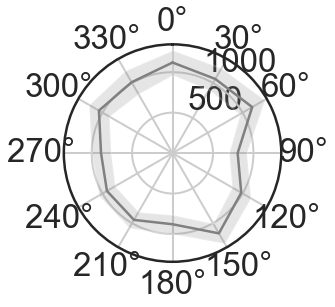

In [73]:
fig_inp['angle'] = fig_inp['stim1']*30
fig_inp['lfp'] = abs(fig_inp['lfp'])
tmp1 = fig_inp.groupby('angle').mean().reset_index()
std = fig_inp.groupby('angle').sem().reset_index()
tmp2 = tmp1.append(tmp1.iloc[0])
std2 = std.append(std.iloc[0])
ax = plt.subplot(111, projection='polar')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.plot((tmp2.angle/360)*2*np.pi, abs(tmp2.lfp))
tmp2['a'] = tmp2.lfp + std2.lfp
tmp2['b'] = tmp2.lfp - std2.lfp
ax.fill_between((tmp2.angle/360)*2*np.pi, tmp2.a, tmp2.b, alpha=0.2)
ax.set_xticks(np.arange(0,2*np.pi,np.pi/6))


In [214]:
path = r"U:\Data_Analysis\pak6\Analysis of LFP\FX mmn paper\fx_var-odd_lfp_11-22-18.pkl"
set1 = pd.read_pickle(path)
path = r"U:\Data_Analysis\pak6\Analysis of LFP\FX mmn paper\fx_var-odd_lfp_12-18-18.pkl"
set2 = pd.read_pickle(path)
path = r"U:\Data_Analysis\pak6\Analysis of LFP\FX mmn paper\thy1-fx_var-odd_lfp.pkl"
set3 = pd.read_pickle(path)

In [75]:
dir_seq.size/12

15.0000

In [215]:
mmn_df = pd.concat([set1, set2, set3]).reset_index(drop = True)

013 wt left-2 sf-nov-odd 15


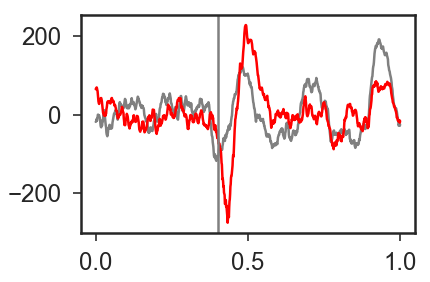

013 wt left-2 sf-loc-omis 14


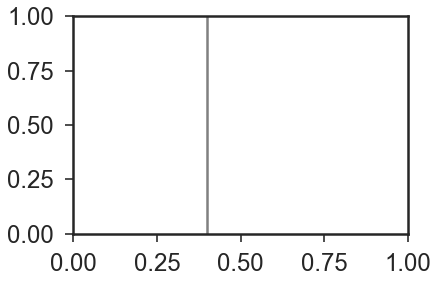

014 fx left-2 sf-tuning 13


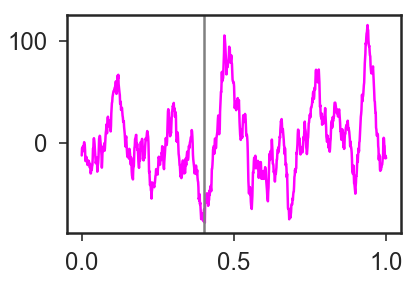

014 fx left-2 sf-tuning 15


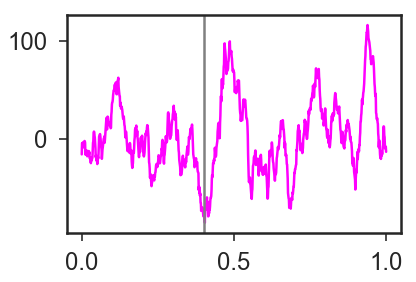

014 fx left-2 sf-tuning 13


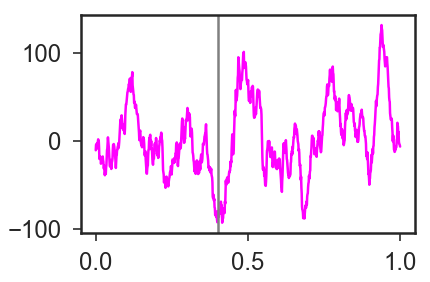

014 fx left-2 sf-nov-odd 13


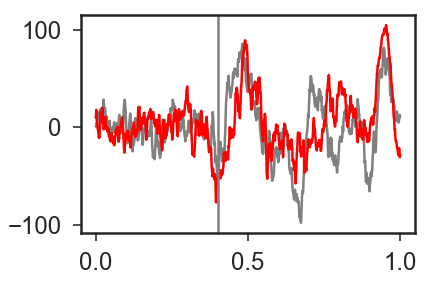

014 fx left-2 sf-nov-odd 14


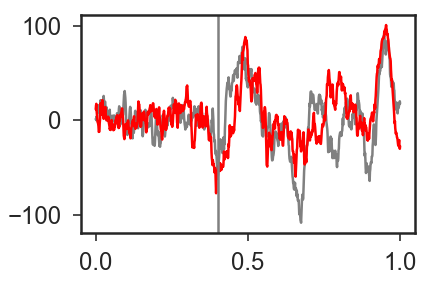

014 fx left-2 sf-nov-odd 13


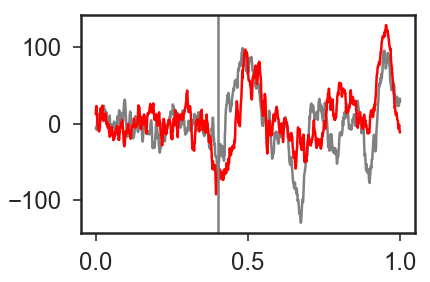

014 fx left-2 sf-loc-omis 13


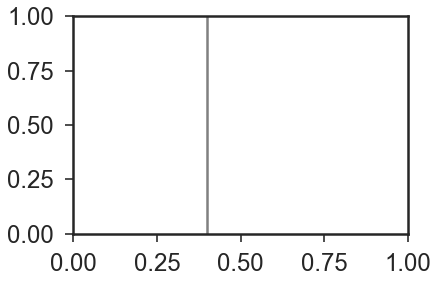

014 fx left-2 sf-loc-omis 14


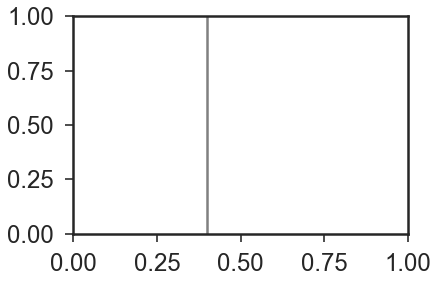

014 fx left-2 sf-loc-omis 13


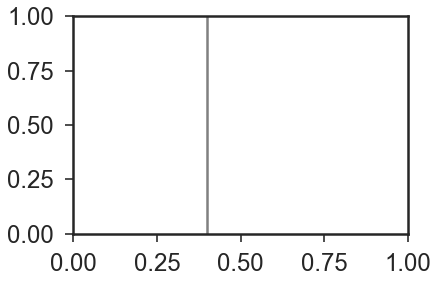

In [220]:
x = np.arange(0, 1, 0.001)
for fname in sorted(mmn_df3.fname.unique()[160:]):
    tmp = mmn_df3[(mmn_df3.fname == fname)]
    try:
        print tmp.et.values[0], tmp.group.values[0], tmp.side.values[0] , tmp.paradigm.values[0],tmp.l4_ch.values[0]
    except:
        print 'no'
    ctr = tmp[tmp.stim1 == 'ctr2'].lfp.values
    std = tmp[(tmp.stim1 == 'std3') & (tmp.paradigm == 'sf-nov-odd')].lfp.values
    dev = tmp[tmp.stim1 == 'dev9'].lfp.values
    if ctr.shape[0] > 0:
        plt.plot(x, ctr, c = 'magenta')
    if std.shape[0] > 1:
        plt.plot(x, std, c = 'gray')
        plt.plot(x, dev, c = 'r')
    plt.axvline(x = 0.4)
    plt.show()
    
    
    

In [300]:
np.diff(tmp.T.dropna().T.iloc[0].index.values)*1e3

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [294]:
# f, ax = plt.subplots()
tmp = data[data.stim1 == 'std3'].dropna().pivot(index = 'fname', columns= 'times' ,values = 'lfp') 
# tf, time, frex, tf3d = oem.tf_cmw(ax, tmp, show=True, log_scale=False)

In [181]:
colors_training = ['gray', 'crimson']
colors_group = [ 'k', 'blue', 'magenta']

C:\Users\Chub_lab\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':
C:\Users\Chub_lab\Anaconda2\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\Users\Chub_lab\Anaconda2\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


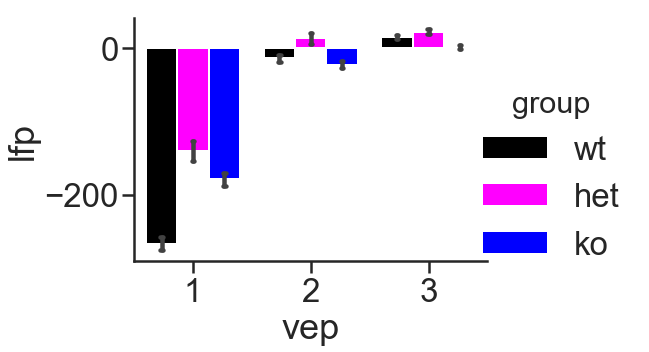

In [24]:
# data = mmn_exp[mmn_exp.paradigm =='paired-oddball']
data = df_master
data = data[(data.stim1.str.contains('N'))
#               & (data.layer == 'l4') 
            & (data.training == 'post')
               ] 

vep1 = data[(data.times>0.53) & (data.times<0.63)]
vep1 = vep1.ix[vep1.groupby([ 'stim1' ,'et']).lfp.idxmin().values]

vep1.loc[:, 'vep'] = 1

vep2 = data[(data.times > 0.73) & (data.times < 0.83)]
vep2 = vep2.ix[vep2.groupby('et').lfp.idxmin().values]

vep2.loc[:, 'vep'] = 2

vep3 = data[(data.times > 0.93) & (data.times < 1.03)]
vep3 = vep3.ix[vep3.groupby('et').lfp.idxmin().values]

vep3.loc[:, 'vep'] = 3

out = pd.concat([vep1, vep2, vep3])
# _data = band_df
g = sns.factorplot(x="vep", y="lfp", hue ='group',  data=out,  kind = 'bar', ci = 68, 
                   palette = colors_group, hue_order = ['wt', 'het', 'ko'],
                   capsize = 0.02, saturation = 1,
                   size = 5, aspect=1.5 )

# plt.savefig('bar-sert-g1-pre-l4.pdf', transparent=True)

In [27]:
tf_out3.head()

cond variable  index     value
0  het    alpha      0  1.382060
1  het    alpha      1  3.588158
2  het    alpha      2  7.689298
3  het    alpha      3  2.426396
4  het    alpha      4  1.273027

In [35]:
cond = 'variable'
val = 'value'
_inp = tf_out3
for l in sorted(_inp[cond].unique()):
    stat_inp = _inp[_inp[cond] == l]
#     stat_inp = stat_inp.groupby(['cond', 'et']).mean().reset_index()
    x1 = stat_inp[(stat_inp.cond == 'wt')   ][val].dropna().values
    x2 = stat_inp[(stat_inp.cond == 'het')   ][val].dropna().values
    x3 = stat_inp[(stat_inp.cond == 'ko')   ][val].dropna().values

    print '\t', l
    print 'wt mean sem', np.mean(x1), sstat.sem(x1)
    print 'het mean sem', np.mean(x2), sstat.sem(x2)
    print 'ko mean sem', np.mean(x3), sstat.sem(x3)
    print len(x1), len(x2), len(x3)
    
    print sstat.kruskal(x1, x2, x3)
    print sstat.mannwhitneyu(x1, x2)
    print sstat.mannwhitneyu(x1, x3)
    print sstat.mannwhitneyu(x2, x3)
    print '------------------------'

	alpha
wt mean sem 3.4614602392424096 0.5114461046717771
het mean sem 2.922542309459411 0.4046243758338872
ko mean sem 3.359428693216982 0.3413907153285875
7 6 9
KruskalResult(statistic=0.828157349896486, pvalue=0.6609489490959439)
MannwhitneyuResult(statistic=20.0, pvalue=0.47152833548352147)
MannwhitneyuResult(statistic=30.0, pvalue=0.45785019676566124)
MannwhitneyuResult(statistic=16.0, pvalue=0.10796246947007015)
------------------------
	beta
wt mean sem 3.2699921991125853 0.4016305620904357
het mean sem 2.272429731615712 0.31718841879133813
ko mean sem 2.365949395018123 0.14798484381443364
7 6 9
KruskalResult(statistic=4.57745153397326, pvalue=0.10139558116930138)
MannwhitneyuResult(statistic=8.0, pvalue=0.037072765555703414)
MannwhitneyuResult(statistic=15.0, pvalue=0.045168795869826826)
MannwhitneyuResult(statistic=22.0, pvalue=0.29794154528258887)
------------------------
	hg
wt mean sem 1.4196979567965873 0.226445371554941
het mean sem 1.9558583098498774 0.3481271354886385
ko

C:\Users\Chub_lab\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
C:\Users\Chub_lab\Anaconda2\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


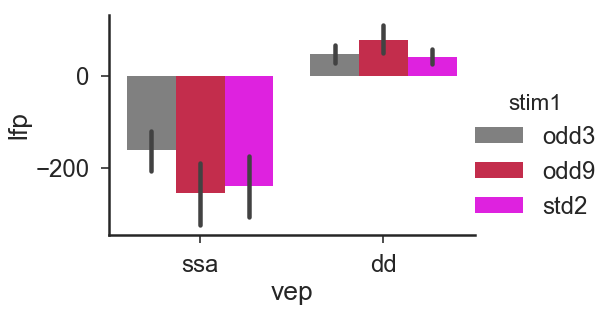

In [50]:
#test = master_df[master_df.training=='pre'].reset_index()
test = data

vep1 = test[(test.times>0.37) & (test.times<0.47)]
vep1 = vep1.ix[vep1.groupby([ 'stim1' ,'fname']).lfp.idxmin().values]
vep1 = vep1.groupby([ 'stim1' ,'fname']).min()
vep1 = vep1.reset_index()
vep1['vep'] = 'ssa'

vep2 = test[(test.times>0.6) & (test.times<0.7)]
vep2 = vep2.ix[vep2.groupby(['stim1' ,'fname']).lfp.idxmax().values]
vep2 = vep2.groupby( ['stim1', 'fname']).max()
vep2 = vep2.reset_index()
vep2['vep'] = 'dd'

# vep3 = test[(test.times>0.93) & (test.times<1.03)]
# vep3 = vep3.ix[vep3.groupby('fname').lfp.idxmin().values]
# vep3 = vep3.groupby('fname').min()
# vep3['vep'] = 3

# vep4 = test[(test.times>1.15) & (test.times<1.25)]
# vep4 = vep4.ix[vep4.groupby('fname').lfp.idxmin().values]
# vep4 = vep4.groupby('fname').min()
# vep4['vep'] = 4

# vep5 = test[(test.times>1.38) & (test.times<1.48)]
# vep5 = vep5.ix[vep5.groupby('fname').lfp.idxmin().values]
# vep5 = vep5.groupby('fname').min()
# vep5['vep'] = 5



out = pd.concat([vep1, vep2])
# out = out.sort_values(by=['group'])
# _data = band_df
g = sns.factorplot(x="vep", y="lfp", hue ='stim1',  data=out,  kind = 'bar', ci = 95, 
#                     capsize = 0.02, saturation = 1,
                   size = 5, aspect=1.5 )
# plt.ylim(-700, 700)
# plt.savefig('sf-vmmn-l4vep_quant-groupb.pdf', transparent=True)
# plt.savefig('sert_ko_amp_vep_all.png', transparent=True)


In [60]:
print sstat.wilcoxon(vep1[vep1.stim1 == 3].lfp, vep1[vep1.stim1 == 9].lfp )
print sstat.wilcoxon(vep2[vep2.stim1 == 3].lfp, vep2[vep2.stim1 == 9].lfp )


WilcoxonResult(statistic=0.0, pvalue=5.606116527496013e-06)
WilcoxonResult(statistic=33.0, pvalue=0.00017832142786159102)


In [31]:
df_hdac3.to_pickle('lfp_l4_hdac.pkl')

In [5]:
path = r"U:\Data_Analysis\pak6\Analysis of LFP\fx-mmn-paper-tf_power.pkl"
tf_df = pd.read_pickle(path)

In [6]:
tf_df.head()

cond variable  index      value group layer
0  ctr2    alpha      0   5.923677    wt  l2/3
1  ctr2    alpha      1   2.842235    wt  l2/3
2  ctr2    alpha      2   2.549978    wt  l2/3
3  ctr2    alpha      3  27.667553    wt  l2/3
4  ctr2    alpha      4  25.108228    wt  l2/3

## TF analysis

In [ ]:
data = mmn_df
data = data[(data.paradigm.str.contains('odd') )
              | (data.stim1.str.contains('ctr2')) 
#                 | (data.stim1.str.contains('std')) 
#                 & (data.et == data.et.unique()[4])
               ]   

data = data[(data.group == 'fx') & (data.layer == 'l4')]
data = data[(data.times>0) & (data.times<0.95)]

In [79]:
_data

group     et         ch        lfp     times
23    wt  S-WT4  15.000000  -2.391438  1.274908
22    wt  S-WT3  14.000000  -2.948180  1.274908
21    wt  S-WT2  12.666667  -6.115257  1.274908
20    wt  S-WT1  11.333333  -1.575077  1.274908
19    wt    942        NaN   1.018279  1.274704
18    wt    488        NaN  -2.180724  1.274704
17    wt    005        NaN  -5.220942  1.274908
13    ko    378        NaN   0.329763  1.274908
16    ko    958        NaN   0.352508  1.274704
15    ko    937        NaN   4.982857  1.274704
14    ko    489        NaN -10.631706  1.274704
12    ko    369        NaN  -2.209666  1.274704
11    ko    010        NaN   1.293380  1.274908
10    ko    009        NaN  -0.051431  1.274908
9     ko    003        NaN   0.118835  1.274908
8     ko    002        NaN  -1.307287  1.274908
1    het    007        NaN  -4.197001  1.274908
7    het    959        NaN  -2.027244  1.274704
6    het    944        NaN   0.656185  1.274704
5    het    936        NaN   4.037292  1.274704
4    het    931        NaN  -2.163403  1.274704
3    het    377        NaN  -7.803629  1.274908
2    het    008        NaN  -2.512770  1.274908
0    het    006        NaN  -3.823702  1.274908

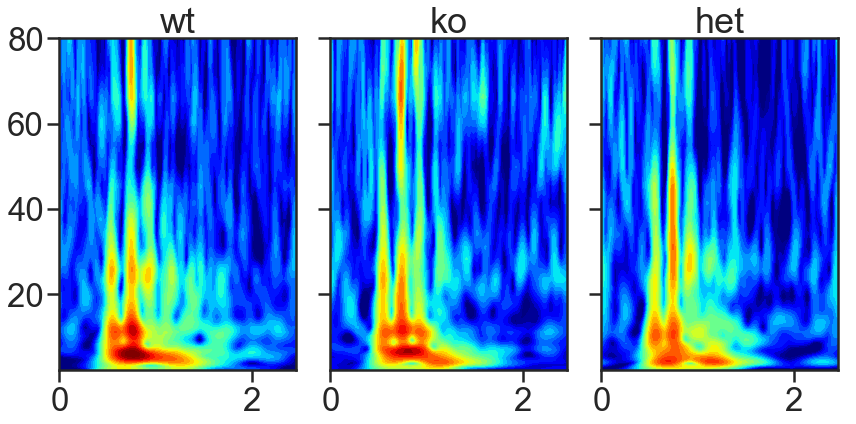

In [36]:
ls = []
ls2= []
ls_perm = []
sf_col = [0.01, 0.02, 0.04, 0.08, 0.14 ]
data = df_master
data = data[(data.stim1.str.contains('1'))
#               & (data.layer == 'l4') 
            & (data.training == 'post')
               ] 
# data = data[(data.paradigm.str.contains('odd')) | (data.stim1 == 'ctr2') ]
data = data[(data.times > 0.05) & (data.times < 2.5)]
data = data.groupby(['group' ,'et', 'times']).mean().reset_index()
data = data.sort_values(by=['group'], ascending=[False])
_data = data
# _data = _data[_data.cnt == '25']
param = 'group'
n =sorted(_data[param].unique()) 
f, ax = plt.subplots( 1, len(n), sharex=True, sharey=True, figsize=(12,6), facecolor = 'w')
t1, t2 = 500, 1500

for idx, val in enumerate((_data[param].unique())):
    
    #tmp = _data[_data['stim1']==sf].pivot_table(index = ['fname', 'et'], columns= 'times' ,values = 'lfp').mean(level=1)
    tmp = _data[_data[param]==val].pivot(index = 'et', columns= 'times' ,values = 'lfp') 
    tmp = tmp.T.dropna().T
    tf, time, frex, tf3d = oem.tf_cmw(ax[idx], tmp, show=True, log_scale=False)
    ax[idx].set_title('' + str(val))
    
    tf3_arr = np.dstack(tf3d)
    tf3_arr = 10*np.log10(tf3_arr/tf3_arr[:,:500,:].mean(axis=1, keepdims=1))
    
#     mask = frex[(frex>12) & (frex<25)]
#     ax[idx].plot(((tf[1, int(mask[0]):int(mask[-1]), :]).mean(axis=0)))
    ls_perm.append(tf3_arr)
    # this is because dB averaging does not equal to linear power averaging 
    tmp = np.dstack(tf3d)
    tmp = tmp.swapaxes(0,2)
    tmp = tmp/tmp[:,:500,:].mean(axis=1, keepdims=1)
    #include only positve power, quanitfy bands
   
    alpha = np.mean(tmp[(frex>8) & (frex<=12)][:,t1:t2,:], axis=1)
    alpha = np.mean(alpha,axis=0)

    beta = np.mean(tmp[(frex > 12) & (frex <= 30)][:,t1:t2,:], axis=1)
    beta = np.mean(beta, axis=0)

    low_gamma = np.mean(tmp[(frex > 30) & (frex <= 50)][:,t1:t2,:], axis=1)
    low_gamma = np.mean(low_gamma,axis=0)

    high_gamma = np.mean(tmp[(frex>50)][:,t1:t2,:] , axis=1)
    high_gamma = np.mean(high_gamma,axis=0)

    theta = np.mean(tmp[(frex>=4) & (frex<=8)][:,t1:t2,:], axis=1)
    theta = np.mean(theta,axis=0)

    tf_tmp = pd.DataFrame({'cond': val,  'beta':beta, 'hg': high_gamma,
                           'alpha': alpha,   'lg': low_gamma, 'theta': theta,
                   'index': np.arange(0, _data[_data[param]==val].et.unique().size)
                     })
    ls2.append(tf_tmp)
tf_tmp = pd.concat(ls2)
# tf_tmp = pd.melt(tf_out, id_vars=['cond'], value_vars=['theta', 'alpha', 'beta', 'lg','hg' ])
tf_tmp = pd.melt(tf_tmp, id_vars=['cond','index' ], 
                 value_vars=['theta', 'alpha', 'beta',  'lg','hg' ])
tf_out3 = tf_tmp.groupby(['cond','variable', 'index']).mean().reset_index()
plt.tight_layout()


# plt.savefig("nat-mov_tf.png", transparent=True)
# plt.savefig("cbar.png", transparent=True)

In [166]:
tf_out3['ucond'] = 'postn'


In [366]:
tmp = np.dstack(tf3d)
tmp = tmp.swapaxes(0,2)
tmp = tmp/tmp[:,:300,:].mean(axis=1, keepdims=1)
#include only positve power, quanitfy bands


array([[[ 2.3925,  0.304 ,  2.9371, ...,  0.4416,  1.3242,  1.5301],
        [ 2.4174,  0.3045,  2.934 , ...,  0.4358,  1.3221,  1.5238],
        [ 2.4418,  0.3049,  2.9304, ...,  0.4299,  1.3195,  1.5175],
        ...,
        [ 6.2786,  2.8066,  0.2117, ...,  0.3073,  3.6769,  1.7101],
        [ 6.2932,  2.805 ,  0.2132, ...,  0.3072,  3.6628,  1.6969],
        [ 6.3062,  2.803 ,  0.2146, ...,  0.307 ,  3.6485,  1.6833]],

       [[ 1.7998,  0.4942,  3.6486, ...,  0.469 ,  1.9176,  0.9707],
        [ 1.8228,  0.4912,  3.6368, ...,  0.4597,  1.9102,  0.9723],
        [ 1.8457,  0.4881,  3.6242, ...,  0.4504,  1.9017,  0.9739],
        ...,
        [ 3.7205,  6.2943,  0.1373, ...,  0.4142,  2.8297,  1.8591],
        [ 3.7011,  6.2775,  0.1378, ...,  0.4133,  2.8352,  1.8425],
        [ 3.6807,  6.2596,  0.1383, ...,  0.4121,  2.8404,  1.8255]],

       [[ 0.9767,  0.8382,  4.657 , ...,  0.6823,  1.9366,  0.672 ],
        [ 0.9924,  0.825 ,  4.6346, ...,  0.6697,  1.9314,  0.6785],
    

In [131]:
tf_out3.head()


cond variable  index     value  ucond
0  het    alpha      0  0.892759  npost
1  het    alpha      1  1.680466  npost
2  het    alpha      2  2.425369  npost
3  het    alpha      3  2.459073  npost
4  het    alpha      4  1.507192  npost

In [461]:
ls = []
ls2= []
ls_perm = []
sf_col = [0.01, 0.02, 0.04, 0.08, 0.14 ]
# _data = sert_df[(sert_df.training == 'post')
#               & (sert_df.stim1 == '1')
#               & (sert_df.stim2 == 'G')
#                & (sert_df.times < 2.5)]
_data = df_sf3
param = 'training'
n =sorted(_data[param].unique()) 
f, ax = plt.subplots( 1, len(n), sharex=True, sharey=True, figsize=(14,4), facecolor = 'w')
t1, t2 = 400, 500
ls_t2 = [120, 190, 260, 330, 400, 470, 540]
#ls_high = []
# _data = _data[  (_data.training_type == 'ori') 
#                 & (_data.training == 'oddball') 
#                & (_data.stim1==3)
#                 & (_data.et != 'KIC5')
#                ]  
# _data = tf_exp
# times = np.linspace(0,0.5,500)


for idx, val in enumerate(sorted(_data[param].unique(), reverse=True)):
    
    #tmp = _data[_data['stim1']==sf].pivot_table(index = ['fname', 'et'], columns= 'times' ,values = 'lfp').mean(level=1)
    tmp = _data[_data[param]==val].pivot(index = 'fname', columns= 'times' ,values = 'lfp') 
 
    tf, time, frex, tf3d = oem.tf_cmw(ax[idx], tmp, show=False, log_scale=False)
    ax[idx].set_title('' + str(val))
    
#     tf3_arr = np.dstack(tf3d)
#     tf3_arr = 10*np.log10(tf3_arr/tf3_arr[:,:500,:].mean(axis=1, keepdims=1))
    
#     mask = frex[(frex>12) & (frex<25)]
#     ax[idx].plot(((tf[1, int(mask[0]):int(mask[-1]), :]).mean(axis=0)))
#     ls_perm.append(tf3_arr)
    
    tmp = np.dstack(tf3d)
    tmp = tmp.swapaxes(0,2)
    tmp = 10*np.log10(tmp/tmp[:,:500,:].mean(axis=1, keepdims=1))
    for t2 in ls_t2:
        t1 = t2-70

        alpha = np.max(tmp[(frex>8) & (frex<=12)], axis=0)[500+t1: 500+t2]
        alpha = np.mean(alpha,axis=0)

        beta = np.max(tmp[(frex>12) & (frex<=25)], axis=0)[500+t1: 500+t2]
        beta = np.mean(beta,axis=0)

        low_gamma = np.max(tmp[(frex>30) & (frex<=50)], axis=0)[500+t1: 500+t2]
        low_gamma = np.mean(low_gamma,axis=0)

        high_gamma = np.max(tmp[(frex>50) ], axis=0)[500+t1: 500+t2]
        high_gamma = np.mean(high_gamma,axis=0)

#         theta = np.mean(tmp[(frex>=4) & (frex<=8)], axis=0)[1000*tw+50+t1: 1000*tw+50+t2]
#         theta = np.mean(theta,axis=0)


        tf_tmp = pd.DataFrame({'cond': val,  'beta':beta, 'hg': high_gamma,'window':str(t2/1000),
                               'alpha': alpha,   'lg': low_gamma, 
                       'index': np.arange(0, _data[_data[param]==val].fname.unique().size)
                 })
        ls.append(tf_tmp)
    tf_tmp = pd.concat(ls)
    ls2.append(tf_tmp)
tf_out = pd.concat(ls2)
tf_tmp = pd.melt(tf_out, id_vars=['cond'], value_vars=['alpha', 'beta', 'lg','hg' ])
tf_out = pd.melt(tf_out, id_vars=['window' ,'cond','index' ], 
                 value_vars=['alpha', 'beta',  'lg','hg' ])
tf_out = tf_out.groupby(['window' ,'cond','variable', 'index']).mean().reset_index()
plt.tight_layout()
# plt.savefig("nat-mov_tf.png", transparent=True)
# plt.savefig("nat-mov_tf.pdf", transparent=True)

NameError: name 'df_sf3' is not defined

In [167]:
tf_out4 = pd.concat([ tf_out, tf_out2, tf_out3])

In [115]:
tf_out.groupby(['cond', 'variable']).mean()

index     value
cond variable                 
het  alpha       3.5  2.618784
     beta        3.5  2.824298
     hg          3.5  1.332808
     lg          3.5  1.893053
     theta       3.5  9.643629
ko   alpha       4.0  3.162020
     beta        4.0  2.375326
     hg          4.0  1.218805
     lg          4.0  2.034315
     theta       4.0  9.111863
wt   alpha       3.0  1.352669
     beta        3.0  2.411941
     hg          3.0  0.925133
     lg          3.0  1.946882
     theta       3.0  4.536733

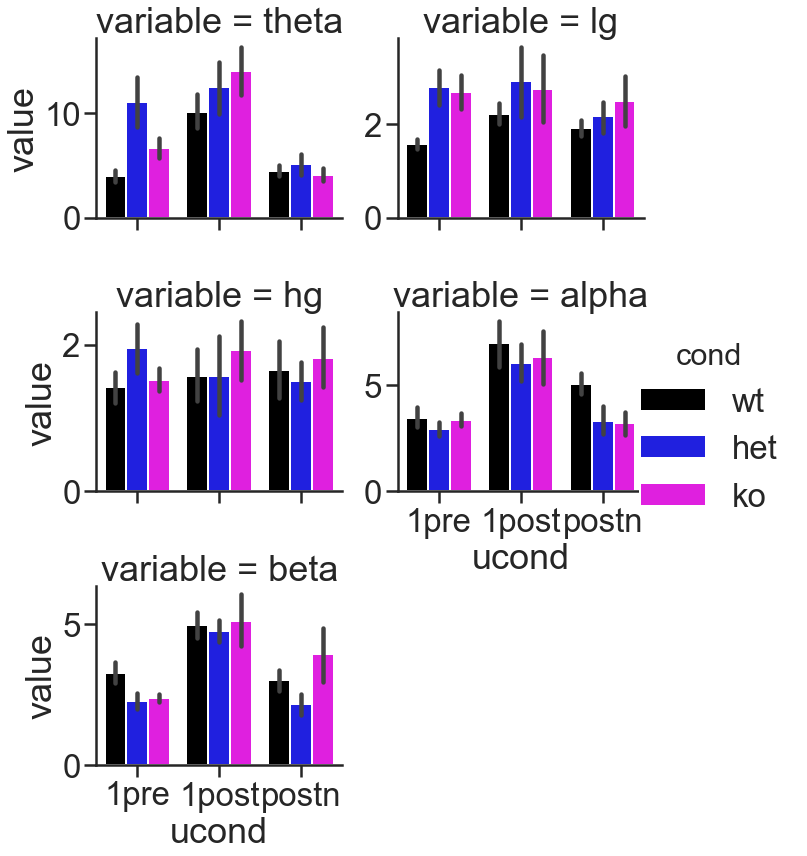

In [189]:
colors = ['green', 'crimson', 'gray']
fig_inp = tf_out4
# remove outliers
# fig_inp = fig_inp[fig_inp.groupby(['variable', 'group']).value.
#       transform(lambda x : (x<x.quantile(0.95))&(x>(x.quantile(0.05)))).eq(1)]
fig_inp = fig_inp.sort_values(by = ['cond'], ascending = [False])
g = sns.catplot(x="ucond", y="value", hue = 'cond',  data=fig_inp,  kind = 'bar', order = ['1pre', '1post', 'postn'],
                    ci = 68,  sharey = False, legend = True, hue_order = ['wt', 'het', 'ko'],
#                 order = reversed(['theta', 'alpha', 'beta', 'lg', 'hg']),
                   palette = colors_group, 
                col = 'variable', col_wrap = 2,
#                     capsize = 0.02, saturation = 1, col_wrap = 2,
                   height = 4, aspect = 1.2 )
plt.savefig("bar_tf-sert-l4-05-15.pdf", transparent=True)

In [400]:
tf_out2

cond variable  index      value group layer
0    ctr2    alpha      0   3.095382    fx    l4
1    ctr2    alpha      1  10.713810    fx    l4
2    ctr2    alpha      2   3.027048    fx    l4
3    ctr2    alpha      3  24.389253    fx    l4
4    ctr2    alpha      4   5.348943    fx    l4
5    ctr2    alpha      5  13.361412    fx    l4
6    ctr2    alpha      6  18.591898    fx    l4
7    ctr2    alpha      7   4.829398    fx    l4
8    ctr2    alpha      8  12.320841    fx    l4
9    ctr2    alpha      9   9.007282    fx    l4
10   ctr2    alpha     10  13.797161    fx    l4
11   ctr2    alpha     11   9.053456    fx    l4
12   ctr2    alpha     12  37.442488    fx    l4
13   ctr2    alpha     13   6.361240    fx    l4
14   ctr2    alpha     14  11.284391    fx    l4
15   ctr2    alpha     15   7.638222    fx    l4
16   ctr2    alpha     16  34.309481    fx    l4
17   ctr2    alpha     17  14.445271    fx    l4
18   ctr2    alpha     18   0.580177    fx    l4
19   ctr2    alpha     19   6.097898    fx    l4
20   ctr2    alpha     20  45.584092    fx    l4
21   ctr2    alpha     21   6.746815    fx    l4
22   ctr2    alpha     22  11.742449    fx    l4
23   ctr2     beta      0   3.257207    fx    l4
24   ctr2     beta      1   3.926215    fx    l4
25   ctr2     beta      2   1.039617    fx    l4
26   ctr2     beta      3   6.659158    fx    l4
27   ctr2     beta      4   1.360768    fx    l4
28   ctr2     beta      5   4.022411    fx    l4
29   ctr2     beta      6   5.591954    fx    l4
..    ...      ...    ...        ...   ...   ...
295  std3       lg     12   4.031154    fx    l4
296  std3       lg     13   2.833736    fx    l4
297  std3       lg     14   1.090087    fx    l4
298  std3       lg     15   9.702974    fx    l4
299  std3       lg     16   0.386686    fx    l4
300  std3       lg     17   6.610719    fx    l4
301  std3       lg     18   1.172487    fx    l4
302  std3       lg     19   1.966906    fx    l4
303  std3       lg     20   5.123998    fx    l4
304  std3    theta      0  10.965794    fx    l4
305  std3    theta      1   7.440340    fx    l4
306  std3    theta      2   1.479532    fx    l4
307  std3    theta      3   7.861340    fx    l4
308  std3    theta      4   0.337357    fx    l4
309  std3    theta      5   4.840928    fx    l4
310  std3    theta      6   8.849671    fx    l4
311  std3    theta      7   2.739617    fx    l4
312  std3    theta      8   9.063586    fx    l4
313  std3    theta      9   4.291568    fx    l4
314  std3    theta     10   5.238835    fx    l4
315  std3    theta     11   7.798770    fx    l4
316  std3    theta     12   0.391386    fx    l4
317  std3    theta     13   4.060715    fx    l4
318  std3    theta     14   5.875118    fx    l4
319  std3    theta     15  12.860414    fx    l4
320  std3    theta     16   0.800556    fx    l4
321  std3    theta     17  10.239748    fx    l4
322  std3    theta     18   5.801112    fx    l4
323  std3    theta     19   4.281809    fx    l4
324  std3    theta     20   3.856532    fx    l4

[325 rows x 6 columns]

In [351]:
fig_inp.head()

cond variable  index     value group layer
336  std3    theta      0  7.491515    wt    l4
337  std3    theta      1  0.615466    wt    l4
338  std3    theta      2  6.608568    wt    l4
339  std3    theta      3  3.777036    wt    l4
340  std3    theta      4  1.152693    wt    l4

In [481]:
tmp = fig_inp[fig_inp.variable == 'hg']

wt_std = tmp[(tmp.cond == 'std3') & (tmp.group == 'wt')].value.dropna().values
wt_dev = tmp[(tmp.cond == 'dev9') & (tmp.group == 'wt')].value.dropna().values
wt_ctr = tmp[(tmp.cond == 'ctr2') & (tmp.group == 'wt')].value.dropna().values

fx_std = tmp[(tmp.cond == 'std3') & (tmp.group == 'fx')].value.dropna().values
fx_dev = tmp[(tmp.cond == 'dev9') & (tmp.group == 'fx')].value.dropna().values
fx_ctr = tmp[(tmp.cond == 'ctr2') & (tmp.group == 'fx')].value.dropna().values

print np.mean(wt_std), sstat.sem(wt_std)
print np.mean(wt_dev), sstat.sem(wt_dev)
print np.mean(wt_ctr), sstat.sem(wt_ctr)


print (len(wt_std), len(fx_std))

# print sstat.kruskal(x1, x2, x3)

p1 =  sstat.mannwhitneyu(wt_std, wt_dev)[1]
p2 = sstat.mannwhitneyu(wt_std, wt_ctr)[1]
p3 =  sstat.mannwhitneyu(wt_dev, wt_ctr)[1]

p4 =  sstat.mannwhitneyu(fx_std, fx_dev)[1]
p5 =  sstat.mannwhitneyu(fx_std, fx_ctr)[1]
p6 =  sstat.mannwhitneyu(fx_dev, fx_ctr)[1]

p7 =  sstat.mannwhitneyu(wt_std, fx_std)[1]
p8 =  sstat.mannwhitneyu(wt_dev, fx_dev)[1]
p9 =  sstat.mannwhitneyu(wt_ctr, fx_ctr)[1]

pvals = np.array((p1, p2, p3, p4, p5, p6, p7, p8, p9))
adj = statsmodels.stats.multitest.multipletests(pvals, method='fdr_bh')
print pvals
print adj[1]

1.0988563362650874 0.1933401716301932
2.475942947989308 0.35424124689036907
3.3872746137511904 0.7958201283394755
(24, 21)
[4.6739e-04 6.5401e-05 3.2134e-01 7.9459e-02 2.0744e-03 6.3343e-02
 2.5836e-01 1.8442e-01 3.8694e-01]
[0.0021 0.0006 0.3615 0.143  0.0062 0.1425 0.3322 0.2766 0.3869]


In [350]:
ls_band = []
bands = ['theta', 'alpha', 'beta', 'lg', 'hg']
for idx, var in enumerate(bands):
    
    tmp = fig_inp[fig_inp.variable == var]
    ls_layer = []
    for lidx, lval in enumerate(sorted(tmp.layer.unique())):
        tmp2 = tmp[tmp.layer == lval]
        std = tmp2[tmp2.cond == 'std3'].value.dropna().values
        dev = tmp2[tmp2.cond == 'dev9'].value.dropna().values
        ctr = tmp2[tmp2.cond == 'ctr2'].value.dropna().values
        print var, lval
        std_mean, std_sem = np.mean(std), sstat.sem(std)
        dev_mean, dev_sem = np.mean(dev), sstat.sem(dev)
        ctr_mean, ctr_sem = np.mean(ctr), sstat.sem(ctr)
        
        
        print len(std), len(dev), len(ctr)
#         print sstat.kruskal(std, dev, ctr)

        std_dev = sstat.mannwhitneyu(std, dev)
        std_ctr = sstat.mannwhitneyu(std, ctr)
        dev_ctr = sstat.mannwhitneyu(dev, ctr)

        data_tmp = pd.DataFrame({'layer': lval, 'band': var, 'stim1': ['std', 'dev', 'ctr'], 
        'mean': [std_mean, dev_mean, ctr_mean ], 'sem': [std_sem, dev_sem, ctr_sem ], 
        'n_ch': [len(std), len(dev), len(ctr)], 'group': 'wt', 'comparison': ['std_dev', 'std_ctr', 'dev_ctr'],
        'p_val': [std_dev[1], std_ctr[1], dev_ctr[1]], 'u_stat': [std_dev[0], std_ctr[0], dev_ctr[0]],
                                 'test': 'MWU' })
        ls_layer.append(data_tmp)
        
        print "--------------------------"
    print '========================'
    ls_band.append(pd.concat(ls_layer))
stat_table = pd.concat(ls_band)
stat_table.head()

theta l4
45 45 47
--------------------------
alpha l4
45 45 47
--------------------------
beta l4
45 45 47
--------------------------
lg l4
45 45 47
--------------------------
hg l4
45 45 47
--------------------------


band comparison group layer      mean  n_ch     p_val       sem stim1  \
0  theta    std_dev    wt    l4  4.542160    45  0.001884  0.432212   std   
1  theta    std_ctr    wt    l4  7.043845    45  0.000312  0.595189   dev   
2  theta    dev_ctr    wt    l4  7.121142    47  0.371436  0.531876   ctr   
0  alpha    std_dev    wt    l4  3.483153    45  0.004362  0.481367   std   
1  alpha    std_ctr    wt    l4  5.656836    45  0.000081  0.697550   dev   

  test  u_stat  
0  MWU   653.0  
1  MWU   619.0  
2  MWU  1015.0  
0  MWU   687.0  
1  MWU   574.0

In [57]:
cols = ['group', 'band', 'layer', 'comparison', 'test', 'u_stat', 'p_val', 'stim1', 'n_ch', 'mean', 'sem' ]
stat_table[cols]

group   band layer comparison test  u_stat         p_val stim1  n_ch  \
0    wt  theta  l2/3    std_dev  MWU  1943.0  4.263050e-02   std    71   
1    wt  theta  l2/3    std_ctr  MWU  1657.0  1.573720e-03   dev    66   
2    wt  theta  l2/3    dev_ctr  MWU  1924.0  1.243084e-01   ctr    66   
0    wt  theta    l4    std_dev  MWU  1370.0  1.424870e-04   std    71   
1    wt  theta    l4    std_ctr  MWU   970.0  2.860228e-09   dev    61   
2    wt  theta    l4    dev_ctr  MWU  1393.0  2.018249e-03   ctr    65   
0    wt  theta  l5/6    std_dev  MWU  1326.0  3.146336e-03   std    62   
1    wt  theta  l5/6    std_ctr  MWU  1374.0  6.453716e-03   dev    60   
2    wt  theta  l5/6    dev_ctr  MWU  1742.0  3.814035e-01   ctr    60   
0    wt  alpha  l2/3    std_dev  MWU  1840.0  8.049894e-02   std    65   
1    wt  alpha  l2/3    std_ctr  MWU  1589.0  1.042946e-02   dev    66   
2    wt  alpha  l2/3    dev_ctr  MWU  1860.0  1.207592e-01   ctr    64   
0    wt  alpha    l4    std_dev  MWU  1537.0  2.535100e-04   std    70   
1    wt  alpha    l4    std_ctr  MWU  1212.0  1.700898e-05   dev    67   
2    wt  alpha    l4    dev_ctr  MWU  1831.0  1.943418e-01   ctr    60   
0    wt  alpha  l5/6    std_dev  MWU  1333.0  9.362393e-05   std    65   
1    wt  alpha  l5/6    std_ctr  MWU  1130.0  4.115643e-05   dev    66   
2    wt  alpha  l5/6    dev_ctr  MWU  1765.0  1.846988e-01   ctr    59   
0    wt   beta  l2/3    std_dev  MWU  1928.0  2.391283e-01   std    66   
1    wt   beta  l2/3    std_ctr  MWU  1839.0  1.295650e-01   dev    63   
2    wt   beta  l2/3    dev_ctr  MWU  1810.0  1.979462e-01   ctr    63   
0    wt   beta    l4    std_dev  MWU  1943.0  1.779543e-01   std    64   
1    wt   beta    l4    std_ctr  MWU  2035.0  3.086850e-01   dev    67   
2    wt   beta    l4    dev_ctr  MWU  2192.0  4.085043e-01   ctr    67   
0    wt   beta  l5/6    std_dev  MWU  1707.0  1.612433e-02   std    66   
1    wt   beta  l5/6    std_ctr  MWU  1246.0  1.698649e-04   dev    66   
2    wt   beta  l5/6    dev_ctr  MWU  1593.0  2.951628e-02   ctr    60   
0    wt     lg  l2/3    std_dev  MWU  1413.0  2.295159e-01   std    57   
1    wt     lg  l2/3    std_ctr  MWU  1679.0  2.265286e-01   dev    54   
2    wt     lg  l2/3    dev_ctr  MWU  1674.0  3.862942e-01   ctr    64   
0    wt     lg    l4    std_dev  MWU  1733.0  2.196239e-02   std    64   
1    wt     lg    l4    std_ctr  MWU  1467.0  9.200373e-04   dev    68   
2    wt     lg    l4    dev_ctr  MWU  2103.0  2.212628e-01   ctr    67   
0    wt     lg  l5/6    std_dev  MWU  2239.0  1.257961e-01   std    71   
1    wt     lg  l5/6    std_ctr  MWU  2144.0  1.962514e-01   dev    71   
2    wt     lg  l5/6    dev_ctr  MWU  2270.0  3.774019e-01   ctr    66   
0    wt     hg  l2/3    std_dev  MWU  1280.0  2.561732e-02   std    57   
1    wt     hg  l2/3    std_ctr  MWU  1123.0  4.631630e-04   dev    57   
2    wt     hg  l2/3    dev_ctr  MWU  1531.0  1.324746e-01   ctr    61   
0    wt     hg    l4    std_dev  MWU  1527.0  1.090372e-03   std    69   
1    wt     hg    l4    std_ctr  MWU  1348.0  3.446167e-05   dev    64   
2    wt     hg    l4    dev_ctr  MWU  1851.0  1.408826e-01   ctr    65   
0    wt     hg  l5/6    std_dev  MWU  1692.0  5.417609e-04   std    71   
1    wt     hg  l5/6    std_ctr  MWU  1283.0  9.519716e-07   dev    70   
2    wt     hg  l5/6    dev_ctr  MWU  1999.0  5.256831e-02   ctr    68   

        mean       sem  
0   5.548395  0.471636  
1   6.977301  0.600281  
2   7.762275  0.569878  
0   6.692041  0.552203  
1   9.266835  0.577510  
2  11.356414  0.526988  
0   4.645382  0.321690  
1   6.879225  0.584479  
2   6.779492  0.597071  
0   5.294349  0.534843  
1   7.003175  0.821804  
2   7.795167  0.804401  
0   5.585876  0.557448  
1   9.462033  0.877789  
2  10.287006  0.956474  
0   3.200013  0.264005  
1   5.763576  0.520095  
2   7.344981  0.805083  
0   3.891031  0.365280  
1   4.279578  0.396360  
2   4.783483  0.450471  
0   3.880643  0.372100  
1   3.966869  0.312917

In [29]:
tmp = tf_df[tf_df.groupby(['variable', 'group']).value.
      transform(lambda x : (x<x.quantile(0.95))&(x>(x.quantile(0.05)))).eq(1)]

## CSD Analysis

In [31]:
tmp.groupby(['variable', 'group'])["value"].quantile([0.05, 0.95]).unstack(level=1)

group                 fx         wt
variable                           
alpha    0.05   0.838460   1.158184
         0.95  19.579550  19.730198
beta     0.05   0.575822   0.795418
         0.95   8.356165  10.187731
hg       0.05   0.217408   0.283687
         0.95   4.158735   3.503097
lg       0.05   0.238324   0.376316
         0.95   2.951122   4.529299
theta    0.05   1.265337   1.590852
         0.95  26.515039  17.198007

In [179]:
tmp = np.dstack(tf3d)
tmp = tmp.swapaxes(0,2)

In [182]:
frex

array([ 2.    ,  2.1984,  2.4165,  2.6562,  2.9197,  3.2094,  3.5278,
        3.8777,  4.2624,  4.6853,  5.1501,  5.661 ,  6.2226,  6.8399,
        7.5185,  8.2643,  9.0842,  9.9854, 10.976 , 12.0648, 13.2617,
       14.5773, 16.0235, 17.6131, 19.3603, 21.281 , 23.3921, 25.7127,
       28.2636, 31.0674, 34.1495, 37.5372, 41.2611, 45.3544, 49.8537,
       54.7994, 60.2358, 66.2114, 72.7799, 80.    ])

In [135]:
frex

array([ 2.    ,  2.1984,  2.4165,  2.6562,  2.9197,  3.2094,  3.5278,
        3.8777,  4.2624,  4.6853,  5.1501,  5.661 ,  6.2226,  6.8399,
        7.5185,  8.2643,  9.0842,  9.9854, 10.976 , 12.0648, 13.2617,
       14.5773, 16.0235, 17.6131, 19.3603, 21.281 , 23.3921, 25.7127,
       28.2636, 31.0674, 34.1495, 37.5372, 41.2611, 45.3544, 49.8537,
       54.7994, 60.2358, 66.2114, 72.7799, 80.    ])

### Permutation test

In [ ]:
# tf3 = np.array_split(tf3d.as_matrix(), 108)
# make 3d array from list of 2d arrays

tf3_arr = np.dstack(tf3d)
tf3_arr = tf3_arr.swapaxes(0,2)
tf3_pre = 10*np.log10(tf3_arr/tf3_arr[:,:400,:].mean(axis=1, keepdims=1))
# reshape to 2d array for dataframe
f,s,tr = tf3_pre.shape
tf3d_pre = pd.DataFrame(tf3_pre.transpose(2,0,1).reshape(f*tr,-1))

In [ ]:
f, ax = plt.subplots(5,1, sharex=True, sharey=True, figsize=(8,12))
# time = np.linspace(0, 4, 4000 )
diff_map = post_map-pre_map
sf_col = [0.01, 0.02, 0.04, 0.08, 0.14 ]
contour_levels = np.arange(-10, 30, 1)
for i, val in enumerate(sf_col):
    ax[i].set_yscale('log')
    ax[i].set_yticks(np.logspace(np.log10(2),np.log10(80),6))
    ax[i].set_yticklabels(np.round(np.logspace(np.log10(2),np.log10(80),6)))
    
    hm = ax[i].contourf(time, frex, post_map[i], 40,  cmap = 'jet' , extend = 'both' )
    ax[i].set_ylabel('Frequency')
    cb_tf = plt.colorbar(hm, ax=ax[i])
    cb_tf.set_label('dB from baseline')
    ax[i].set_title(val)

stat_fun(H1): min=0.000000 max=37.605613
Running initial clustering
Found 31 clusters
Permuting ...
[........................................] 100.00000 |    Computing cluster p-values
Done.


Text(0,0.5,u'Frequency (Hz)')

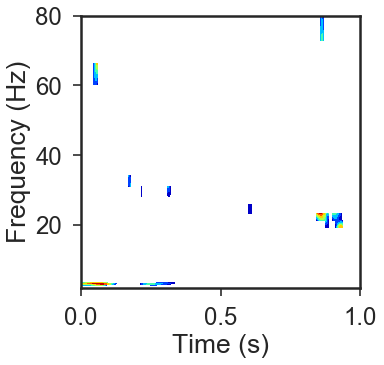

In [147]:

T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test([ls_perm[1], ls_perm[0]],
                             n_permutations=256, threshold = 15.0,  tail=0)
T_obs_plot = np.nan * np.ones_like(T_obs)
for c, p_val in zip(clusters, cluster_p_values):
    if p_val <= 0.05:
        T_obs_plot[c] = T_obs[c]

f, ax = plt.subplots(figsize = (5,5))
# ax.set_xlim(0,2.5)
# ax.set_yscale('log')
# hm = ax.set_yticks(np.logspace(np.log10(2),np.log10(80),6))
# ax.set_yticklabels(np.round(np.logspace(np.log10(2),np.log10(80),6)))
# ax.contourf(time, frex, T_obs.T, 
           
#            aspect='auto', origin='lower', cmap='gray')
hm = ax.contourf(time, frex, T_obs_plot.T, 
           
           aspect='auto', origin='lower', cmap='jet')
# plt.colorbar(hm)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
# plt.savefig("tf_permutation.png", transparent=True)
# plt.savefig("tf_permutation_sf_low2.pdf", transparent=True)

In [4]:
path = r"U:\Papers\Impaired Visual Familiarity Circuit in Fmr1 KO Mice\Sam\Data analysis for figures\RAW\Phase Shift\wtfx_all.hdf5"
df_units = pd.read_hdf(path)

In [164]:
df_fx.head()

cond      et                                              fname  \
0  Group2Bpost  ET#310  u:/Papers/Real FXS Paper/Data analysis for fig...   
1  Group2Bpost  ET#310  u:/Papers/Real FXS Paper/Data analysis for fig...   
2  Group2Bpost  ET#310  u:/Papers/Real FXS Paper/Data analysis for fig...   
3  Group2Bpost  ET#310  u:/Papers/Real FXS Paper/Data analysis for fig...   
4  Group2Bpost  ET#310  u:/Papers/Real FXS Paper/Data analysis for fig...   

     group        lfp  rec  times training  
0  Group2B  22.271868  003  0.000     post  
1  Group2B  19.565276  003  0.001     post  
2  Group2B  12.398786  003  0.002     post  
3  Group2B  14.972786  003  0.003     post  
4  Group2B   5.513098  003  0.004     post

In [27]:
a1

array([3.9216, 2.6667, 4.1667, 3.5714, 4.1667, 4.2553, 3.0303, 2.8571,
       4.5455, 4.3478, 3.2787, 2.9851, 4.0816])

In [136]:
import neurodsp
x = lfp
Fs = 1000
all_pac_methods = ['ozkurt', 'plv', 'glm', 'tort', 'canolty']
f_range_lo = (13, 30)
f_range_hi = (50, 200)
N_seconds_lo = .25
N_seconds_hi = .2

np.random.seed(0) # The tort and canolty methods uses random methods
pacs = np.zeros(len(all_pac_methods))
for i, m in enumerate(all_pac_methods):
    pacs[i] = neurodsp.compute_pac(x, x, Fs, f_range_lo, f_range_hi,
                               N_seconds_lo=N_seconds_lo, N_seconds_hi=N_seconds_hi,
                               pac_method=m)
    print('PAC strength = {:.4f}, {:s} method'.format(pacs[i], m))



PAC strength = 0.0726, ozkurt method
PAC strength = 0.0764, plv method
PAC strength = 0.0095, glm method
PAC strength = 0.0009, tort method
PAC strength = 1.3750, canolty method


In [51]:

# Parameters for comodulogram function
f_pha_bin_edges = np.arange(3, 22, 2)
f_amp_bin_edges = np.arange(20, 120, 4)
N_cycles_pha = 3
N_cycles_amp = 11

# Compute comodulogram
pac = neurodsp.compute_pac_comodulogram(x, x, Fs,
                                        f_pha_bin_edges, f_amp_bin_edges,
                                        N_cycles_pha=N_cycles_pha,
                                        N_cycles_amp=N_cycles_amp,
                                        pac_method='ozkurt')



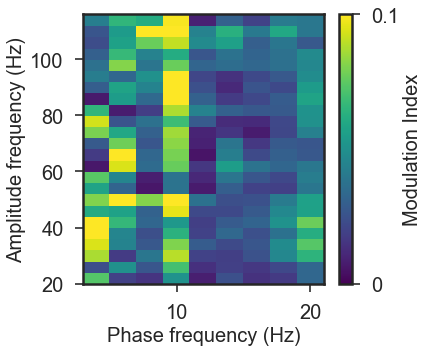

In [52]:
# Plot comodulogram
neurodsp.plot_pac_comodulogram(pac, f_pha_bin_edges, f_amp_bin_edges,
                               clim=(0,.1))

## SF decoding from LFP data

In [759]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, StratifiedKFold
from collections import defaultdict
from statsmodels.formula.api import ols
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

In [841]:
master_df['group'] = master_df.et.map(groups)
master_df['trial_n'] = master_df.index//1e3
master_df['rect_LFP'] = abs(master_df.lfp)

In [844]:
master_df.head()

times stim1      lfp   et    side        rec  \
0  0.000     2  -7.5660  017  left-2  017left-2   
1  0.001     2  -6.4277  017  left-2  017left-2   
2  0.002     2 -29.9320  017  left-2  017left-2   
3  0.003     2 -34.9621  017  left-2  017left-2   
4  0.004     2 -36.7808  017  left-2  017left-2   

                                               fname group  trial_n  rect_LFP  
0  U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-...    wt     -0.0    7.5660  
1  U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-...    wt      0.0    6.4277  
2  U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-...    wt      0.0   29.9320  
3  U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-...    wt      0.0   34.9621  
4  U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-...    wt      0.0   36.7808

In [ ]:
# clf = svm.SVC(kernel='linear', C=1)
ls_cond = []
rskf = RepeatedStratifiedKFold(n_splits = 4, n_repeats = 5,
     random_state = 3)
for gr in df2.group.unique():
    for w in time_w:
        df2_sub = df2[(df2.trial_spikes >= w[0]) & (df2.trial_spikes < w[1]) & (df2.group == gr)]
        resp_units = df2_sub.groupby('cluster_id').times.count().reset_index()
        resp_units = resp_units[resp_units.times > 10].cluster_id.unique()
        tmp = df2_sub[df2_sub.cluster_id.isin(resp_units)].groupby(['cluster_id', 
                                                'trial_n']).trial_spikes.count().reset_index()
        tmp2 = tmp.pivot('trial_n', 'cluster_id', 'trial_spikes')
        tmp2 = tmp2.fillna(0)

        ls = []
# coef_arr = np.zeros((100,5, _data.cuid.unique().size ))
        print gr, w

        x_ = tmp2.values
        y_ = sf_tuning.values()

        scores = cross_val_score(lr, x_, y_, cv = rskf)
#         print scores
        tmp_df = pd.DataFrame({'cv': i, 'group': gr, 'window': w[0], 'acc': scores})
        ls_cond.append(tmp_df)

In [924]:
rskf = RepeatedStratifiedKFold(n_splits = 4, n_repeats = 5,
     random_state = 3) 
lda = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage = 'auto')
# svm = SVC(C=1)
y_ = sf_tuning
time_w = [(0.35, 0.8), (0.35, 0.45), (0.45, 0.55), (0.55, 0.65), (0.65, 0.75)]
ls_cond = []
for gr in master_df.group.unique():
    for w in time_w:
        
        df_sub = master_df[(master_df.group == gr) & (master_df.times > w[0]) & (master_df.times < w[1])]
#         df_sub = df_sub.groupby(['group', 'rec', 'trial_n', 'times']).mean().reset_index()
        df_sub2 = df_sub.groupby(['fname', 'trial_n']).rect_LFP.mean().reset_index()
        x_ = df_sub2.pivot('trial_n', 'fname', 'rect_LFP')
#         X_scaled = preprocessing.scale(x_)
        x_ -= x_.min() 
        x_ /= x_.max()
        scores = cross_val_score(lda, x_, y_, cv = rskf)
        
        tmp_df = pd.DataFrame({'cv': i, 'group': gr, 'window': w[0], 'acc': scores})
        ls_cond.append(tmp_df)
out = pd.concat(ls_cond)
out.loc[:,'error'] = 1 - out.acc
out.head()

acc  cv group  window     error
0  0.700000   5    wt    0.35  0.300000
1  0.666667   5    wt    0.35  0.333333
2  0.700000   5    wt    0.35  0.300000
3  0.666667   5    wt    0.35  0.333333
4  0.600000   5    wt    0.35  0.400000

(0, 0.8000)

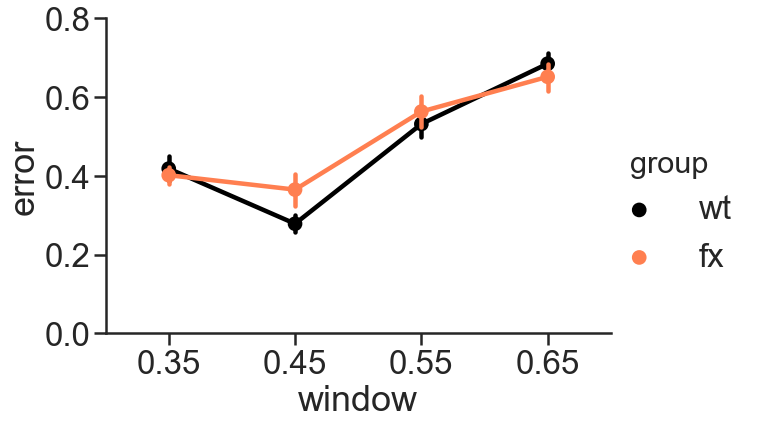

In [925]:
sns.catplot(x = 'window', y = 'error', data = out, hue = 'group', 
            kind = 'point', height = 6, aspect = 1.5, palette = colors_group , ci = 95)
plt.ylim(0, 0.8)

In [923]:
df_sub.head()

times stim1      lfp   et    side        rec  \
350  0.3504     2  26.0477  017  left-2  017left-2   
351  0.3514     2  43.5925  017  left-2  017left-2   
352  0.3524     2  32.9845  017  left-2  017left-2   
353  0.3534     2  38.0910  017  left-2  017left-2   
354  0.3544     2  41.9894  017  left-2  017left-2   

                                                 fname group  trial_n  \
350  U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-...    wt      0.0   
351  U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-...    wt      0.0   
352  U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-...    wt      0.0   
353  U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-...    wt      0.0   
354  U:\Data\pak6\figures\LFP\probe_64DA\FX\sf-nov-...    wt      0.0   

     rect_LFP  
350   26.0477  
351   43.5925  
352   32.9845  
353   38.0910  
354   41.9894

In [927]:
x_.shape

(120, 69)